# Physics-Informed Neural Network Implementation on Quadrotor Data

Importing needed libraries

In [2]:
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from torch.distributions import Normal, Independent, kl_divergence
from collections import namedtuple
from math import e, cos, sin, pi, atan2, asin, sqrt, tan

### Quadrotor Dynamical Data Generator

In [11]:
class Quadrotor_Dynamics_Generator():

  def __init__(self,
               x_size=26,
               y_size=12,
               traj_length=2,
               normalize=True,
               xy_offset=20,
               min_Z=0,
               max_Z=50,
               xydot_offset=60.0,
               min_Zdot = -30,
               max_Zdot = 30,
               min_accel_xy = -30,
               max_accel_xy = 30,
               min_accel_z = -30,
               max_accel_z = 30, 
               min_omega=-80,
               max_omega=80,
               min_omegadot=-80,
               max_omegadot=80,
               min_rp = -pi/2 + 0.1,
               max_rp = pi/2 - 0.1,
               min_rotor_rps = 0,
               max_rotor_rps = 1000,
               perturb_rps=10,
               ground_effect=False,
               wind_vel_offset = 25,
               Z_thresh=2,
               quad_mass=20
              ):

    self.x_size = x_size
    self.y_size = y_size
    self.traj_length = traj_length
    self.normalize = normalize
    self.xy_offset = xy_offset
    self.min_Z = min_Z
    self.max_Z = max_Z
    self.xydot_offset = xydot_offset

    self.min_rp = min_rp
    self.max_rp = max_rp
    self.min_rotor_bound = min_rotor_rps
    self.max_rotor_bound = max_rotor_rps
    self.perturb_rps = perturb_rps
    self.ground_effect = ground_effect
    self.Z_thresh = Z_thresh
    self.m = quad_mass
    self.constants = self.constants_init()

    # Initialize minmax data needed for relavent simulation parameters
    self.minmax_data = torch.tensor([[-self.xydot_offset, self.xydot_offset],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [min_Zdot, max_Zdot],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_z, max_accel_z],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot],
                                    [0, 0], #dt
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [min_rotor_rps, max_rotor_rps],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [-wind_vel_offset, wind_vel_offset],
                                    [0, 0],
                                    [0, 0],
                                    [0, 0],
                                    [0, 0],
                                    [0, 0],
                                    [0, 0],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [-self.xydot_offset, self.xydot_offset],
                                    [min_Zdot, max_Zdot],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_xy, max_accel_xy],
                                    [min_accel_z, max_accel_z],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omega, max_omega],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot],
                                    [min_omegadot, max_omegadot]])
    

  # Evolves the dynamics of quadrotor
  def eqn_mtn(self, state_vec, uu, dt, V_w, rotor_disturbances=False, rotor_spike_bound=100, linvel_offset=torch.zeros([3,]), angvel_offset=torch.zeros([3,])):

    ########     NESTED FUNCTION     ########

    # Verify boundness of Euler angles
    def theta_check(theta):
      # Parsing euler angles
      roll = theta[0]
      pitch = theta[1]
      yaw = theta[2]

      # Ensuring euler angles remain within [-pi, pi]
      roll_offset = torch.abs(torch.floor(roll / (2*pi)))
      pitch_offset = torch.abs(torch.floor(pitch / (2*pi)))
      yaw_offset = torch.abs(torch.floor(yaw / (2*pi)))

      if roll > pi:
        roll -= roll_offset * (2*pi)
      elif roll < -pi:
        roll += roll_offset * (2*pi)

      if pitch > pi:
        pitch -= pitch_offset * (2*pi)
      elif pitch < -pi:
        pitch += pitch_offset * (2*pi)

      if yaw > pi:
        yaw -= yaw_offset * (2*pi)
      elif yaw < -pi:
        yaw += yaw_offset * (2*pi)

      theta_transformed = torch.tensor([roll, pitch, yaw])
      return theta_transformed
    
    ###########   END OF NESTED FUNCTION   ###########
    
    # Parsing positional and velocity states
    x = state_vec[:3]
    theta = state_vec[3:6]
    xdot = state_vec[6:9]
    thetadot = state_vec[9:12]
    omega = state_vec[12:15]
    omegadot = state_vec[15:18]
    a = state_vec[18:]
    
    # Checking if current altitude is at ground effect threshold  
    if x[2] <= 2 and x[2] > 0:
      self.ground_effect = True
    else:
      self.ground_effect = False  
      
    #print(f'EQN_MTN BEFORE: xdot_prev: {xdot}, a: {a}, omega_prev: {omega}, omegadot: {omegadot}')


    # Initializing needed constants
    I = self.constants['I']
    I_r = self.constants['I_r']
    g = self.constants['g']
    m = self.constants['m']
    L = self.constants['L']
    b = self.constants['b']
    kf = self.constants['kf']
    km = self.constants['km']
    kd = self.constants['kd']
    d_array = self.constants['d_array']


    # Incorporating rotor spiking (if applicable)
    if rotor_disturbances == True:
      uu_observed = uu.clone()
      uu = self.perturb_rv(uu_observed, rotor_spike_bound=rotor_spike_bound)

    # Integrating body rates
    omega = omega + dt * omegadot

    # Ensuring commanded velocities keep quadrotor within defined state space
    if linvel_offset.any():
      xdot = linvel_offset
    else:
      xdot = xdot + dt * a
      
    if angvel_offset.any():
      thetadot = angvel_offset
    else: 
      thetadot = self.omega2thetadot(omega, theta)

    # Integrating positional states
    theta = theta + dt * thetadot
    x = x + dt * xdot

    # Ensuring euler angles lie within appropriate bounds
    theta = theta_check(theta)
    
    # Transforming inputs into $\omega_{i}^2$
    uu = torch.pow(uu, 2)

    # Computing quadrotor body rates from updated euler data
    omega = self.thetadot2omega(thetadot, theta)
    
    # Computing forces and moments from external perturbations
    V_w, F_w = self.inject_wind_peturb(V_w, dt)
    Vr_array = self.compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
    F_bf, F_bf_array = self.inject_blade_flapping_force(theta, uu, Vr_array)
    F_id, F_id_array = self.inject_induced_drag_force(theta, uu, Vr_array)
    
    if self.ground_effect: 
      Fg = self.inject_ground_effect(z=x[2],z_thresh=2)
    else:
      Fg = torch.zeros_like(F_bf)

    # Computing exogenous disturbances
    F_aero = F_bf + F_id + Fg + F_w
    tau_aero = self.inject_torque_perturb(F_bf_array, F_id_array, d_array)
    
    # Compute linear and angular accelerations.
    a = self.acceleration(uu, theta, xdot, m, g, kf, kd, F_aero, prev_a=a)
    omegadot = self.angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero, prev_ωdot=omegadot)

    # Updating state vector
    state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)
    #print(f'EQN_MTN AFTER: xdot_prev: {xdot}, a: {a}, omega_prev: {omega}, omegadot: {omegadot}, V_w: {V_w}')
    
    return state_vec, V_w, F_aero, tau_aero
  
  ####   QUADROTOR PHYSICS FUNCTIONS   ####
  
  # Compute translational accelerations
  def acceleration(self, inputs, angles, xdot, m, g, kf, kd, F_aero, prev_a=torch.zeros([3,])):
    gravity = torch.tensor([0,0,-g])
    R = self.rotation(angles)
    T = R @ self.thrust(inputs, kf)
    Fd = -kd * xdot
    a = gravity + (1/m) * (T + Fd + F_aero) - kd * prev_a
    return a

  # Compute angular accelerations
  def angular_acceleration(self, inputs, omega, I, I_r, L, b, km, tau_aero, prev_ωdot=torch.zeros([3,])):
    tau_m = self.motor_torques(inputs, L, b, km)
    tau_g = self.gyroscopic_torques(inputs, omega, I_r)
    
    #print(f'tau_m: {tau_m}, tau_aero: {tau_aero}, tau_g: {tau_g}\n')
    tau = (tau_m + tau_aero - tau_g)
    omegadot = torch.inverse(I) @ (tau - torch.linalg.cross(omega, I @ omega)) - km * prev_ωdot
    return omegadot
  
  # Compute torques, given current inputs, length of arm, drag coefficient, and moment coefficient.
  def motor_torques(self, inputs, L, b, km):
    # Inputs are values for ${\omega_i}^2$
    tau = torch.tensor([
        L * km * (inputs[0] - inputs[2]),
        L * km * (inputs[1] - inputs[3]),
        b * (inputs[0] - inputs[1] + inputs[2] - inputs[3])
    ])
    return tau
  
  # Compute thrust given current inputs and thrust coefficient.
  def thrust(self, inputs, kf):
    # Inputs are values for ${\omega_i}^2$
    T = torch.tensor([0, 0, kf * torch.sum(inputs)])
    return T

  # Compute gyroscopic torques on quadrotor
  def gyroscopic_torques(self, inputs, omega, I_r):
    # Parsing body rates
    pp = omega[0]
    qq = omega[1]
    
    # Untransforming squared inputs
    inputs = torch.sqrt(inputs)
    
    # Computing gyroscopic torques
    tau_g = torch.zeros([3,])
    tau_g[0] = I_r*qq*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
    tau_g[1] = -I_r*pp*(inputs[0] - inputs[1] + inputs[2] - inputs[3])
    
    return tau_g

  ####    END OF PHYSICS FUNCTIONS     ####


  ####  PERTURBATION/NOISE FUNCTIONS   ####

  def perturb_rv(self, uu, rotor_spike_bound=100):

    # High: perturb_rps minmax = -100, 100
    # Medium: perturb_rps_minmax = -50, 50

    max_rotor_perturb_rps = rotor_spike_bound
    min_rotor_perturb_rps = -rotor_spike_bound
    
    # Sampling rotor spiking values
    dω1 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω2 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω3 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    dω4 = random.random() * (max_rotor_perturb_rps - min_rotor_perturb_rps) + min_rotor_perturb_rps
    
    # Applying spiking values to rotor velocities
    uu[0] += dω1
    uu[1] += dω2
    uu[2] += dω3
    uu[3] += dω4

     # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20
    
    return uu
  
  def model_rotor_vels(self, uu, noise_bias=10, noise_std=15):
    
    # Sampling noise vector to perturb rotor velocities in realistic manner
    noise_uu = torch.normal(mean=torch.tensor(noise_bias), std=torch.tensor(noise_std), size=[4,])
    
    # Applying noise to rotor velocities
    uu += noise_uu
    
    # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20
    
    # Applying quantization step
    uu = torch.round(uu)
    
    return uu


  def compute_rotor_linvels(self, xdot, theta, omega, d_array, V_w):
    # VECTORIZE
    
    # Computing rotation matrix for  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing rotor linear velocities for each rotor
    Vr_array = torch.zeros([4,3])
    for rotor in range(4):
      Vr_array[rotor,:] = R.T @ (xdot - V_w) + torch.linalg.cross(omega, d_array[rotor,:])
    
    return Vr_array
    

  def inject_blade_flapping_force(self, theta, uu, Vr_array):
    # VECTORIZE
    
    # Defining needed aerodynamic coefficients
    Ct = 2e-3
    Ca = 5e-4
    Cb = 5e-4

    # Computing rotation matrix  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing sum of blade flapping forces coming from all rotors
    F_bf = torch.zeros([3,])
    F_bf_array = torch.zeros([4,3])
    mat = torch.tensor([[Ca,-Cb,0],
                        [Cb,Ca,0],
                        [0,0,0]])
    
    for rotor in range(uu.shape[0]):
      rotor_F_bf = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
      F_bf += rotor_F_bf
      F_bf_array[rotor,:] = rotor_F_bf

    return F_bf, F_bf_array

  def inject_induced_drag_force(self, theta, uu, Vr_array):
    # VECTORIZE
    # Defining needed aerodynamic coefficients
    Ct = 2e-3
    Cdx = 5e-4
    Cdy = 5e-4

    # Computing rotation matrix  (Body -> Inertial)
    R = self.rotation(theta)

    # Computing sum of induced drag forces from all rotors
    F_id = torch.zeros(3,)
    F_id_array = torch.zeros([4,3]) 
    mat = torch.tensor([[Cdx,0,0],
                        [0,Cdy,0],
                        [0,0,0]])
    
    for rotor in range(uu.shape[0]):
      rotor_F_id = -Ct * uu[rotor] * R @ mat @ Vr_array[rotor,:]
      F_id += rotor_F_id
      F_id_array[rotor,:] = rotor_F_id

    return F_id, F_id_array
  
  def inject_ground_effect(self, z, z_thresh):
  
    # Defining needed aerodynamic coefficient
    Cg = 1e-3

    # Computing ground effect force
    Fg_coeff = Cg / (4*z**2) - Cg / (z_thresh - z) ** 2
    Fg = Fg_coeff * torch.tensor([0,0,1])
    
    # Computing maximum allowed ground effect force based on quadrotor weight
    Fg_max = 0.4 * (self.m * 9.8)
    
    # Constraining ground effect force to be within realistic bounds
    if Fg[2] > Fg_max:
      Fg[2] = Fg_max
    elif Fg[2] < -Fg_max:
      Fg[2] = -Fg_max

    return Fg


  def inject_torque_perturb(self, F_bf_array, F_id_array, d_array):
    # VECTORIZE
    def skew_symmetric(d):
      Sd = torch.tensor([[0,-d[2],d[1]],
                        [d[2],0,-d[0]],
                        [-d[1],d[0],0]])
      return Sd

    tau_perturb = torch.zeros([3,])
    for rotor in range(4):
      d = d_array[rotor,:]
      F_bf = F_bf_array[rotor,:]
      F_id = F_id_array[rotor,:] 

      Sd = skew_symmetric(d)

      tau_perturb += Sd @ (F_bf + F_id)
    
    return tau_perturb
  
  def inject_wind_peturb(self, V_w, dt):
  
    # Computing matrices needed for wind update
    w_array1 = torch.tensor([80,75,24], dtype=torch.float32)
    w_array1 = torch.diag(w_array1)

    w_array2 = torch.tensor([1.65,1.5,1.9])
    w_array2 = torch.inverse(torch.diag(w_array2))

    # Computing updated wind force
    F_w = torch.tensor([
                    0.05 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.05 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.1 * V_w[2]**2 * torch.sign(V_w[2])
                  ])

    # Computing updated wind velocity
    w_d = torch.normal(mean=0, std=0.2, size=[3,])
    V_wdot = w_array2 @ (-V_w + w_array1 @ w_d)

    V_w += V_wdot * dt
    
    return V_w, F_w
  

  def apply_mm_gaussian_noise(self, xdot, a, ω, ωdot, V_w, max_num_peaks=5, num_points=500, gps_err_bias1=5e-2, gps_err_std1=1e-2, gyro_err_bias1=1e-2, gyro_err_std1=5e-2, 
                              gps_err_bias2=5e-1, gps_err_std2=6e-1, gyro_err_bias2=5e-1, gyro_err_std2=1.0):

    # Large Noise: gps_err_bias=0.2, gps_err_std=0.6, gyro_err_bias=5e-1, gyro_err_std=1e-3
    # Medium Noise: gps_err_bias=5e-2, gps_err_std=6e-3, gyro_err_bias=1e-2, gyro_err_std=1e-3

    # Preventing in-place computations
    xdot = xdot.clone()
    a = a.clone()
    ω = ω.clone()
    ωdot = ωdot.clone()

    num_peaks = random.randint(2,max_num_peaks)
    peak_weights = torch.rand([num_peaks,])
    peak_weights /= torch.sum(peak_weights)

    for i in range(num_peaks):
      
      # Computing sample size for noise peak
      N = int(torch.ceil(num_points * peak_weights[i])) if int(torch.ceil(num_points * peak_weights[i])) > 3 else 3

      # Sampling sensor noise characteristics
      gps_err_bias = random.random() * (gps_err_bias2 - gps_err_bias1) + gps_err_bias1
      gps_err_std = random.random() * (gps_err_std2 - gps_err_std1) + gps_err_std1
      gyro_err_bias = random.random() * (gyro_err_bias2 - gyro_err_bias1) + gyro_err_bias1
      gyro_err_std = random.random() * (gyro_err_std2 - gyro_err_std1) + gyro_err_std1
      V_w_err_bias = random.random() * (1 - 0.1) + 0.1
      V_w_err_std = random.random() * (1 - 1e-2) + 1e-2

      # Instantiating zero-mean gaussian noise for linear and angular data
      noise_xdot = torch.normal(mean=torch.tensor(gps_err_bias), std=torch.tensor(gps_err_std), size=[N,])
      noise_a = torch.normal(mean=torch.tensor(gps_err_bias*1.15), std=torch.tensor(gps_err_std*1.15), size=[N,])
      noise_ω = torch.normal(mean=torch.tensor(gyro_err_bias), std=torch.tensor(gyro_err_std), size=[N,])
      noise_ωdot = torch.normal(mean=torch.tensor(gyro_err_bias*1.15), std=torch.tensor(gyro_err_std*1.15), size=[N,])
      noise_V_w = torch.normal(mean=torch.tensor(V_w_err_bias), std=torch.tensor(V_w_err_std), size=[N,])

      # Shuffle the elements of the multimodal distribution
      shuffled_dist_xdot = noise_xdot[torch.randperm(len(noise_xdot))]
      shuffled_dist_a = noise_a[torch.randperm(len(noise_a))]
      shuffled_dist_ω = noise_ω[torch.randperm(len(noise_ω))]
      shuffled_dist_ωdot = noise_ωdot[torch.randperm(len(noise_ωdot))]
      shuffled_dist_V_w = noise_V_w[torch.randperm(len(noise_V_w))]

      # Parsing multimodal gaussian noise to disrupt sensor data
      noise_xdot = shuffled_dist_xdot[torch.randperm(3)]
      noise_a = shuffled_dist_a[torch.randperm(3)]
      noise_ω = shuffled_dist_ω[torch.randperm(3)]
      noise_ωdot = shuffled_dist_ωdot[torch.randperm(3)]
      noise_V_w = shuffled_dist_V_w[torch.randperm(3)]


    # Applying additive noise to positional signals
    xdot += noise_xdot
    a += noise_a
    ω += noise_ω
    ωdot += noise_ωdot
    V_w += noise_V_w

    return xdot, a, ω, ωdot, V_w
  
  ####   END OF PERTURBATION/NOISE FUNCTIONS    ####
  

  # Initializing needed constants for simulation
  def constants_init(self):

    m = torch.tensor([self.m])                      # Mass of quadrotor (kg)
    g = 9.806                                       # Gravitational force (m/s^2)
    L = torch.pow((m / 2.5), 1/3)                   # Length of quadrotor arm (rotor-to-center) (m)
    r_prop = L / 4                                  # Radius of quadrotor propellor
    A = pi * r_prop**2                              # Cross-sectional area of propellor

    # Defining inertia tensor of quadrotor (kg*m^2)
    I = torch.zeros([3,3])
    I[0,0] = 0.35 * m
    I[1,1] = 0.35 * m
    I[2,2] = 0.40 * m
    
    # Defining rotor inertia (kg*m^2)
    I_r = 4e-5*m*L**2

    # Defining quadrotor aerodynamic properties
    force_reg = 1e-3
    torque_reg = 5e-4
    rho = 1.225                                                 # Air density (kg/m^3)
    ω_hover = torch.sqrt((m*g) / (4*1e-3))                      # Angular velocity of rotors needed to hover (rad/s)
    km = (2.5*m*g) / (4*ω_hover**2) * torque_reg                # Aerodynamic moment coefficient (N*s^2)
    kf = 5e-3 * force_reg * m                                   # Aerodynamic force coefficient (N*s^2)
    C_d = 1.5                                                   # Aerodynamic drag coefficient

    # Translational and moment drag coefficient
    kd = 0.5 * rho * C_d * A
    b = 0.5 * r_prop**3 * rho * C_d  * A * torque_reg 

    # Defining individual rotor distances to quadrotor center of mass
    d_array = torch.zeros([4,3])
    rotor_angle = torch.tensor([pi/4, 3*pi/4, 5*pi/4, 7*pi/4])
    for rotor in range(d_array.shape[0]):
      d_array[rotor,0] = L * sin(rotor_angle[rotor])
      d_array[rotor,1] = L * cos(rotor_angle[rotor])
      d_array[rotor,2] = 0.2 * L

    # Updating internal quadrotor inertial properties
    constants = {'I':I, 'I_r':I_r, 'g':g, 'm':m, 'L':L, 'b':b, 'kf':kf, 'km':km, 'kd':kd, 'd_array':d_array}
    return constants


  # Computing ZYZ rotation matrix (Body -> Inertial)
  def rotation(self, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]
    yaw = theta[2]

    # Computing rotation matrix
    R = torch.tensor([[cos(roll)*cos(yaw) - cos(pitch)*sin(roll)*sin(yaw), -cos(yaw)*sin(roll) - cos(roll)*cos(pitch)*sin(yaw), sin(pitch)*sin(yaw)],
                      [cos(pitch)*cos(yaw)*sin(roll) + cos(roll)*sin(yaw), cos(roll)*cos(pitch)*cos(yaw) - sin(roll)*sin(yaw), -cos(yaw)*sin(pitch)],
                      [sin(roll)*sin(pitch), cos(roll)*sin(pitch), cos(pitch)]])

    return R

  def linvel_control(self, Z):
    # Applying appropriate translational velocity offsets based on
    # quadrotor's current pose outside of defined regions (in m/s)
    linvel_offset = torch.zeros([3,])
  
    # Altitude control.
    if Z > self.max_Z:
      linvel_offset[2] = -10
    elif Z < self.min_Z:
      linvel_offset[2] = 10

    return linvel_offset


  def roll_pitch_control(self, ROLL, PITCH):
    # Applying appropriate roll/pitch velocity offset based on
    # quadrotor's current attitude (in rad/s)
    euler_offset = torch.zeros([3,])

    if ROLL < self.min_rp:
      euler_offset[0] = pi/2
    elif ROLL > self.max_rp:
      euler_offset[0] = -(pi/2)

    if PITCH < self.min_rp:
      euler_offset[1] = pi/2
    elif PITCH > self.max_rp:
      euler_offset[1] = -(pi/2)

    return euler_offset
  

  def sample_quad_states(self, uu):
    # Sample random initial simulation states
    X = random.random() * (self.xy_offset + self.xy_offset) - self.xy_offset
    Y = random.random() * (self.xy_offset + self.xy_offset) - self.xy_offset
    Z = random.random() * (self.max_Z - self.min_Z) + self.min_Z
    x = torch.tensor([X, Y, Z])
    
    # Ground effect check
    if Z <= self.Z_thresh:
      self.ground_effect=True
    else:
      self.ground_effect=False

    ROLL = random.random() * (pi/2 + pi/2) - pi/2
    PITCH = random.random() * (pi/2 + pi/2) - pi/2
    YAW = random.random() * (pi + pi) - pi
    theta = torch.tensor([ROLL, PITCH, YAW])

    X_dot = random.random() * (5 + 5) - 5
    Y_dot = random.random() * (5 + 5) - 5
    Z_dot = random.random() * (5 + 5) - 5
    xdot = torch.tensor([X_dot, Y_dot, Z_dot])

    ROLL_dot = random.random() * (2*pi + 2*pi) - 2*pi
    PITCH_dot = random.random() * (2*pi + 2*pi) - 2*pi
    YAW_dot = random.random() * (2*pi + 2*pi) - 2*pi
    thetadot = torch.tensor([ROLL_dot, PITCH_dot, YAW_dot])

    # Initializing needed constants
    I = self.constants['I']
    I_r = self.constants['I_r']
    g = self.constants['g']
    m = self.constants['m']
    L = self.constants['L']
    b = self.constants['b']
    kf = self.constants['kf']
    km = self.constants['km']
    kd = self.constants['kd']
    d_array = self.constants['d_array']

    # Transforming inputs into $\omega_{i}^2$
    uu = torch.pow(uu, 2)

    # Computing quadrotor body rates
    omega = self.thetadot2omega(thetadot, theta)

    # Computing forces and moments from external perturbations
    V_w = torch.zeros([3,])
    V_w[0] = random.random() * (15 + 15) - 15
    V_w[1] = random.random() * (15 + 15) - 15
    V_w[2] = random.random() * (15 + 15) - 15

    F_w = torch.tensor([
                    0.05 * V_w[0]**2 * torch.sign(V_w[0]), 
                    0.05 * V_w[1]**2 * torch.sign(V_w[1]),
                    0.1 * V_w[2]**2 * torch.sign(V_w[2])
    ])
    
    Vr_array = self.compute_rotor_linvels(xdot, theta, omega, d_array, V_w)
    F_bf, F_bf_array = self.inject_blade_flapping_force(theta, uu, Vr_array)
    F_id, F_id_array = self.inject_induced_drag_force(theta, uu, Vr_array)
    
    if self.ground_effect: 
      Fg = self.inject_ground_effect(Z,self.Z_thresh)
    else:
      Fg = torch.zeros_like(F_bf)

    F_aero = F_bf + F_id + Fg + F_w
    tau_aero = self.inject_torque_perturb(F_bf_array, F_id_array, d_array)
    
    # Computing translational+rotational accelerations from sampled states
    a = self.acceleration(uu, theta, xdot, m, g, kf, kd, F_aero)
    omegadot = self.angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero)
   # print(f'(sampled accel): {a}, omegadot: {omegadot}\n')

    # Saving randomized states into state vector
    state_vec = torch.concat([x, theta, xdot, thetadot, omega, omegadot, a], dim=0)

    return state_vec, V_w


  def state_space_verify(self, Z, ROLL, PITCH):
    # Boolean that checks if quadrotor's states are within defined state space
    state_verified = False

    if Z > self.min_Z and abs(ROLL) < self.max_rp and abs(PITCH) < self.max_rp:

      state_verified = True

    return state_verified
  
  def quad_vel_verify(self, prev_state_vec, next_state_vec, linvel_offset, pitch_offset):
    vel_verified = True
    xdot_prev = prev_state_vec[6:9]
    thetadot_prev = prev_state_vec[9:12]

    xdot_next = next_state_vec[6:9]
    thetadot_next = next_state_vec[9:12]
    
    # Check to prevent offset velocities being included in 'quadout'
    if (xdot_next == linvel_offset).any() or (xdot_prev == linvel_offset).any() or \
      (thetadot_next == pitch_offset).any() or (thetadot_prev == pitch_offset).any():
        vel_verified = False

    return vel_verified

  def thetadot2omega(self, thetadot, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]

    # Computing rotation matrix (Inertial -> Body)
    R = torch.tensor([[1, 0, -sin(pitch)],
                      [0, cos(roll), cos(pitch)*sin(roll)],
                      [0, -sin(roll), cos(pitch)*cos(roll)]])

    # Computing angular body rates
    omega = R @ thetadot

    return omega


  def omega2thetadot(self, omega, theta):
    # Parsing euler angles
    roll = theta[0]
    pitch = theta[1]

    # Computing rotation matrix (Body -> Inertial)
    R_inv = torch.tensor([[1, sin(roll)*tan(pitch), cos(roll)*tan(pitch)],
                      [0, cos(roll), -sin(roll)],
                      [0, sin(roll)/cos(pitch), cos(roll)/cos(pitch)]])

    # Computing angular body rates
    thetadot = R_inv @ omega

    return thetadot

  
  def update_controls(self, uu, rotor_rps_bound=20):

    # Computing randomly-selected change in each rotor velocity of quadrotor
    dw1 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw2 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw3 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound
    dw4 = random.random() * (rotor_rps_bound + rotor_rps_bound) - rotor_rps_bound

    # Updating rotor velocities
    uu[0] += dw1
    uu[1] += dw2
    uu[2] += dw3
    uu[3] += dw4

    # Applying saturation limits
    for rotor in range(uu.shape[0]):
      if uu[rotor] > self.max_rotor_bound:
        uu[rotor] = self.max_rotor_bound - 20
      elif uu[rotor] < self.min_rotor_bound:
        uu[rotor] = self.min_rotor_bound + 20

    return uu
  
  
  def index_data_stacker(self, dataset, noise=False):
    # Parsing relevant data shapes
    num_targets = dataset.shape[0]
    stack_iters = dataset.shape[1]

    # Initializing index data objects needed for computation
    idx = torch.randperm(num_targets)
    idx = torch.unsqueeze(idx, dim=-1)
    idx_tnsr = torch.zeros([num_targets, stack_iters])
    '''
    # Ensuring idx_array.shape == idx_tnsr[:,:,i].shape 
    for _ in range(traj_length):
      idx_array = torch.concat([idx_array, idx], dim=1)
    idx_array = torch.unsqueeze(idx_array, dim=-1)
    '''
    # Updating each dimension of idx_tnsr with idx_array
    for stack in range(stack_iters):
      idx_tnsr[:,stack:stack+1] = idx
      
    if noise:
      noise_idx_tnsr = idx_tnsr[:,:12]
      return idx_tnsr.to(dtype=torch.int64), noise_idx_tnsr.to(dtype=torch.int64)

    return idx_tnsr.to(dtype=torch.int64) # ensure all entries are integers

  
  # Minmax normalization function  
  def minmax_norm(self, dataset):
    # Parsing relevant data shapes
    batch_size = dataset.shape[0]
    dynamical_data_dim = dataset.shape[2]

    dim_skips = [12] + list(range(20,26))

    for batch in range(batch_size):
      for dim in range(dynamical_data_dim):
        # Skipping sampling rate dimension to avoid normalization
        if dim in dim_skips:
          continue

        curr_sequence = dataset[batch,:,dim:dim+1]
        curr_min = self.minmax_data[dim,0]
        curr_max = self.minmax_data[dim,1]

        dataset[batch,:,dim:dim+1] = (curr_sequence - curr_min) / (curr_max - curr_min)

    return dataset

  
  # Minmax unnormalization function
  def minmax_unnorm(self, x_pred):

    batch_size = x_pred.shape[0]
    state_dim = x_pred.shape[1]
    
    # Unnormalizing input array trajectory-by-trajectory
    for batch in range(batch_size):
      for dim in range(state_dim):

        min_value = self.minmax_data[dim, 0]
        max_value = self.minmax_data[dim, 1]

        x_pred[batch,dim] = x_pred[batch,dim] * (max_value - min_value) + min_value
 
    return x_pred
  
  
  # Converting pytorch tensor into seqential (N x data dim) tensor
  def sequential_split(self, dataset):
    
    combined_quad_array = torch.empty([dataset.shape[0]*2, self.x_size+self.y_size])
    for iter,i in enumerate(range(0, 2*dataset.shape[0], 2)):

        added_inputs1 = dataset[iter:iter+1,0,12:26]
        added_inputs2 = dataset[iter:iter+1,1,12:26]

        traj1 = dataset[iter:iter+1,0,:12]
        traj2 = dataset[iter:iter+1,1,:12]
        traj3 = dataset[iter:iter+1,1,26:]

        array1 = torch.concat([traj1,added_inputs1,traj2], dim=-1)
        array2 = torch.concat([traj2,added_inputs2,traj3], dim=-1)

        traj_array = torch.concat([array1, array2], dim=0)
        combined_quad_array[i:i+2,:] = traj_array

    return combined_quad_array
  

  def generate_random_signs(self, size):
    # Generate random integers (0 or 1)
    random_ints = torch.randint(0, 2, (size,))
    
    # Map 0 to -1 and 1 to 1
    signs = 2 * random_ints - 1
    
    return signs
  
  def generate_test_traj(self, seq_length, perturb_params, gaussian_noise=True):
    
    # Initializing quadrotor output array
    quadout = torch.zeros([seq_length, self.traj_length, self.x_size+self.y_size])
    
    # Parsing sensor perturb parameters
    rotor_spike_bound = perturb_params[0]
    wind_profile = perturb_params[1]
    V_w = wind_profile * self.generate_random_signs(size=3)
  
    disturb_quad_at = 1
    disturbance_iter = 0

    # Initializing input trajectory from our controller.
    w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
    uu = torch.tensor([w1, w2, w3, w4])
      
    # Sampling initial quadrotor states
    state_vec, V_w = self.sample_quad_states(uu)
    
    # Sampling initial sampling rate
    dt = random.random() * (0.2 - 0.0001) + 0.0001

    # Saving current state as previous one
    prev_state_vec = state_vec
    
    for i in range(seq_length):

      while True:
        
        transition_complete = False
        for j in range(self.traj_length):
          
          # Integrating dynamical states
          if disturbance_iter % disturb_quad_at == 0:
            next_state_vec, _, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w, rotor_disturbances=True, rotor_spike_bound=rotor_spike_bound)

            # Resetting irregular disturbance count
            disturb_quad_at = np.ceil(random.random() * 10)
            disturbance_iter = 0
          else:
            next_state_vec, _, _, _ = self.eqn_mtn(prev_state_vec, uu, dt, V_w)
            
          Z = next_state_vec[2]
          ROLL = next_state_vec[3]
          PITCH = next_state_vec[4]

          # Verifying that candidate next state is within defined state space
          state_verified = self.state_space_verify(Z, ROLL, PITCH)
          
          if not state_verified: 
            
            # Evolving states with forcing terms until quadrotor back in admissible state space
            while True:
              linvel_offset = self.linvel_control(Z)
              rp_offset = self.roll_pitch_control(ROLL, PITCH)
              
              next_state_vec, _, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w=torch.zeros([3,]), 
                                                      linvel_offset=linvel_offset, angvel_offset=rp_offset)
              
              Z = next_state_vec[2]
              ROLL = next_state_vec[3]
              PITCH = next_state_vec[4]
              
              # Verifying that candidate next state is within defined state space
              state_verified = self.state_space_verify(Z, ROLL, PITCH)
              no_vel_offsets = self.quad_vel_verify(prev_state_vec, next_state_vec, linvel_offset, rp_offset)
              
              # Resetting states until quadrotor back in admissible state space
              prev_state_vec = next_state_vec
              
              if state_verified and no_vel_offsets:
                linvel_offset = torch.zeros([3,])
                rp_offset = torch.zeros([3,])
                break
      
            # Reset for loop that was forming current transistion in 'quadout' tensor
            break
          
          else:
            # Capturing previous/next positional, velocity, and angular states, current sampling rate, and controls (rotor speeds)
            # of quadrotor
            xdot_prev = prev_state_vec[6:9]
            omega_prev = prev_state_vec[12:15]
            omegadot = prev_state_vec[15:18]
            a = prev_state_vec[18:]
            
            theta_next = next_state_vec[3:6]
            thetadot_next = next_state_vec[9:12]
            xdot_next = next_state_vec[6:9]
            omega_next = next_state_vec[12:15]
            omegadot_next = next_state_vec[15:18]
            a_next = next_state_vec[18:]
            
            # Applying multimodal Gaussian noise to previous states
            if gaussian_noise: xdot_prev, a, omega_prev, omegadot, V_w = self.apply_mm_gaussian_noise(xdot_prev, a, omega_prev, 
                                                                                   omegadot, V_w)
            
            # MODEL INPUTS
            quadout[i,j,:3] = xdot_prev
            quadout[i,j,3:6] = a
            quadout[i,j,6:9] = omega_prev
            quadout[i,j,9:12] = omegadot
            quadout[i,j,12:13] = dt
            quadout[i,j,13:17] = uu
            quadout[i,j,17:20] = V_w
            quadout[i,j,20:23] = theta_next 
            quadout[i,j,23:26] = thetadot_next
            
            # MODEL OUTPUTS
            quadout[i,j,26:29] = xdot_next
            quadout[i,j,29:32] = a_next
            quadout[i,j,32:35] = omega_next
            quadout[i,j,35:] = omegadot_next
            
            # If valid transitions formed, break while loop
            if j == self.traj_length-1: transition_complete = True 
            
            # Setting new states to previous ones
            prev_state_vec = next_state_vec
            
            disturbance_iter += 1
        
        # Updating rotor velocities and sampling next dt
        uu = self.update_controls(uu)
        dt = random.random() * (0.2 - 0.0001) + 0.0001
        
        if transition_complete: break  
    
    # Normalize data entries (if applicable)
    if self.normalize: quadout = self.minmax_norm(quadout)

    return quadout
    
      
  
  def generate_rand_dynamical_dataset(self, sample_size):
    # Initializing quadrotor output array
    quadout = torch.zeros([sample_size, self.traj_length, self.x_size+self.y_size])

    # Setting print checkpoint variable
    print_after = int(sample_size / 50)

    # Implemented try-except catch in case early data generation stoppage
    try:

      # Step through the simulation, updating the state.
      disturbance_iter = 0
      disturb_quad_at = 500
      for i in range(sample_size):

        # Initializing input trajectory from our controller.
        w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
        uu = torch.tensor([w1, w2, w3, w4])
        
        # Sampling new inertial constants
        self.constants = self.constants_init()
          
        # Sampling initial quadrotor states
        state_vec, V_w = self.sample_quad_states(uu)

        # Resampling next sampling rate
        dt = random.random() * (0.2 - 0.0001) + 0.0001

        # Saving current state as previous one
        prev_state_vec = state_vec

        while True:
          
          transition_complete = False
          for j in range(self.traj_length):
            
            # Integrating dynamical states
            if disturbance_iter % disturb_quad_at == 0:
              next_state_vec, V_w, _, _  = self.eqn_mtn(prev_state_vec, uu, dt, V_w, rotor_disturbances=True)

              # Resetting irregular disturbance count
              disturb_quad_at = np.ceil(random.random() * 2000)
              disturbance_iter = 0
            else:
              next_state_vec, V_w, _, _ = self.eqn_mtn(prev_state_vec, uu, dt, V_w)
              
            Z = next_state_vec[2]
            ROLL = next_state_vec[3]
            PITCH = next_state_vec[4]

            # Verifying that candidate next state is within defined state space
            state_verified = self.state_space_verify(Z, ROLL, PITCH)
            
            if not state_verified:
              # Sampling new rotor velocities from our controller.
              w1 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w2 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w3 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              w4 = random.random() * (self.max_rotor_bound - self.min_rotor_bound) + self.min_rotor_bound
              uu = torch.tensor([w1, w2, w3, w4])
              
              # Sampling new quadrotor states until admissible transistion(s) is received
              state_vec, V_w = self.sample_quad_states(uu)
              prev_state_vec = state_vec
              break
            
            else:
              # Capturing previous/next positional, velocity, and angular states, current sampling rate, and controls (rotor speeds)
              # of quadrotor
              xdot_prev = prev_state_vec[6:9]
              omega_prev = prev_state_vec[12:15]
              omegadot = prev_state_vec[15:18]
              a = prev_state_vec[18:]
              
              theta_next = next_state_vec[3:6]
              thetadot_next = next_state_vec[9:12]
              xdot_next = next_state_vec[6:9]
              omega_next = next_state_vec[12:15]
              omegadot_next = next_state_vec[15:18]
              a_next = next_state_vec[18:]
              
              # MODEL INPUTS
              quadout[i,j,:3] = xdot_prev
              quadout[i,j,3:6] = a
              quadout[i,j,6:9] = omega_prev
              quadout[i,j,9:12] = omegadot
              quadout[i,j,12:13] = dt
              quadout[i,j,13:17] = self.model_rotor_vels(uu)
              quadout[i,j,17:20] = V_w
              quadout[i,j,20:23] = theta_next 
              quadout[i,j,23:26] = thetadot_next
              
              # MODEL OUTPUTS
              quadout[i,j,26:29] = xdot_next
              quadout[i,j,29:32] = a_next
              quadout[i,j,32:35] = omega_next
              quadout[i,j,35:] = omegadot_next
              
              # If valid transitions formed, break while loop
              if j == self.traj_length-1: transition_complete = True 
              
              # Updating rotor velocities and sampling next dt
              uu = self.update_controls(uu)
              dt = random.random() * (0.2 - 0.0001) + 0.0001
              
              # Setting new states to previous ones
              prev_state_vec = next_state_vec
              disturbance_iter += 1
          
          if transition_complete: break  
          
        if i % print_after == 0: print(f"Sample {i} reached!\n")
      
      print(f"Sample {i+1} reached. All samples collected!\n")

      # Normalize data entries (if applicable)
      if self.normalize: quadout = self.minmax_norm(quadout.clone())

      return quadout
    
    except KeyboardInterrupt:
      # Printing data generation stoppage message and initializing dataset needed for early stoppage 
      print(f"Data generation stopped at sample {i}. Will need to normalize data separately for model consumption! (use db.minmax_norm(traj_dataset))")
      quadout_early = torch.empty([i, self.traj_length, self.x_size+self.y_size])
      quadout_early = quadout[:i,:,:]
      
      return quadout_early
     


In [9]:
db = Quadrotor_Dynamics_Generator(normalize=False)

quadout = db.generate_rand_dynamical_dataset(sample_size=int(2e6))

Sample 0 reached!

Sample 40000 reached!

Sample 80000 reached!

Sample 120000 reached!

Sample 160000 reached!

Sample 200000 reached!

Sample 240000 reached!

Sample 280000 reached!

Sample 320000 reached!

Sample 360000 reached!

Sample 400000 reached!

Sample 440000 reached!

Sample 480000 reached!

Sample 520000 reached!

Sample 560000 reached!

Sample 600000 reached!

Sample 640000 reached!

Sample 680000 reached!

Sample 720000 reached!

Sample 760000 reached!

Sample 800000 reached!

Sample 840000 reached!

Sample 880000 reached!

Sample 920000 reached!

Sample 960000 reached!

Sample 1000000 reached!

Sample 1040000 reached!

Sample 1080000 reached!

Sample 1120000 reached!

Sample 1160000 reached!

Sample 1200000 reached!

Sample 1240000 reached!

Sample 1280000 reached!

Sample 1320000 reached!

Sample 1360000 reached!

Sample 1400000 reached!

Sample 1440000 reached!

Sample 1480000 reached!

Sample 1520000 reached!

Sample 1560000 reached!

Sample 1600000 reached!

Sample 

In [11]:
np.save('quad_traj_PINN_dataset_2e6_no_noise_no_disturbance.npy', arr=quadout.detach().numpy())

In [8]:
quadout[:,:,12]

tensor([[0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0

In [8]:
np.save('quad_traj_dataset_1e6_dkf_test.npy', norm_quadout.detach().numpy())

In [6]:
norm_quadout = db.minmax_norm(quadout.clone())

In [3]:
db = Quadrotor_Dynamics_Generator(normalize=False, traj_length=5)
quadout = db.generate_rand_dynamical_dataset(sample_size=int(5e5))

Sample 0 reached!

Sample 100000 reached!

Sample 200000 reached!

Sample 300000 reached!

Sample 400000 reached!

Sample 500000 reached. All samples collected!



In [6]:
updated_quadout = torch.from_numpy(np.load('quad_traj_PINN_dataset_2e6_no_noise_no_disturbance.npy'))
combined_quad_array = np.empty([updated_quadout.shape[0]*2, 35])
for iter,i in enumerate(range(0, 2*updated_quadout.shape[0], 2)):

    added_inputs1 = updated_quadout[iter:iter+1,0,12:23]
    added_inputs2 = updated_quadout[iter:iter+1,1,12:23]

    traj1 = updated_quadout[iter:iter+1,0,:12]
    traj2 = updated_quadout[iter:iter+1,1,:12]
    traj3 = updated_quadout[iter:iter+1,1,23:]
    #traj4 = updated_quadout[iter:iter+1,observed_dim,0,:12]
    #traj5 = updated_quadout[iter:iter+1,observed_dim,1,:12]
    #traj6 = updated_quadout[iter:iter+1,observed_dim,1,23:]
    array1 = torch.concat([traj1,added_inputs1,traj2], dim=-1)
    array2 = torch.concat([traj2,added_inputs2,traj3], dim=-1)

    traj_array = np.concatenate([array1, array2], axis=0)
    combined_quad_array[i:i+2,:] = traj_array

In [7]:
data = {'prev_xdot':combined_quad_array[:,0],'prev_ydot':combined_quad_array[:,1],'prev_zdot':combined_quad_array[:,2],
        'prev_ax':combined_quad_array[:,3],'prev_ay':combined_quad_array[:,4],'prev_az':combined_quad_array[:,5],
        'prev_wx':combined_quad_array[:,6],'prev_wy':combined_quad_array[:,7],'prev_wz':combined_quad_array[:,8],
        'prev_wxdot':combined_quad_array[:,9],'prev_wydot':combined_quad_array[:,10],'prev_wzdot':combined_quad_array[:,11], 'dt':combined_quad_array[:,12],
        'R1':combined_quad_array[:,13],'R2':combined_quad_array[:,14],'R3':combined_quad_array[:,15],'R4':combined_quad_array[:,16],
        'next_roll':combined_quad_array[:,17],'next_pitch':combined_quad_array[:,18],'next_yaw':combined_quad_array[:,19],
        'next_rolldot':combined_quad_array[:,20],'next_pitchdot':combined_quad_array[:,21],'next_yawdot':combined_quad_array[:,22],
        'next_xdot':combined_quad_array[:,23],'next_ydot':combined_quad_array[:,24],'next_zdot':combined_quad_array[:,25],
        'next_ax':combined_quad_array[:,26],'next_ay':combined_quad_array[:,27],'next_az':combined_quad_array[:,28],
        'next_wx':combined_quad_array[:,29],'next_wy':combined_quad_array[:,30],'next_wz':combined_quad_array[:,31],
        'next_wxdot':combined_quad_array[:,32],'next_wydot':combined_quad_array[:,33],'next_wzdot':combined_quad_array[:,34]}


df = pd.DataFrame(data)

In [8]:
df_new = df.copy()
num_samples = df.shape[0]
idx_array = []

for i in range(0,num_samples,2):

    curr_trans = df_new.iloc[i:i+2,:]
    if (np.abs(curr_trans['next_wx']) > 80).any() or (np.abs(curr_trans['next_wy']) > 80).any() or (np.abs(curr_trans['next_wz']) > 80).any() or \
        (np.abs(curr_trans['next_wxdot']) > 80).any() or (np.abs(curr_trans['next_wydot']) > 80).any() or (np.abs(curr_trans['next_wzdot']) > 80).any() or \
        (np.abs(curr_trans['next_rolldot']) > 80).any() or (np.abs(curr_trans['next_pitchdot']) > 80).any() or (np.abs(curr_trans['next_yawdot']) > 80).any():
        idx_array.extend([i, i+1])


df_new.drop(idx_array, inplace=True)
#df_new.to_csv('quad_traj_dataframe_filtered_high_noise.csv')

In [9]:
quadout = torch.empty([int(df_new.shape[0]/2),2,35])
for iter,i in enumerate(range(0, df_new.shape[0], 2)):

    curr_sample = torch.from_numpy(df_new.iloc[i:i+2,:].values)
    prev_states = curr_sample[0:1,:12]
    prev_add_inputs = curr_sample[0:1,12:23]
    prev_trans_states = curr_sample[0:1,23:]
    next_add_inputs = curr_sample[1:2,12:23]
    next_states = curr_sample[1:2,23:]

    # Storing observed and latent states back into quadout tensor
    quadout[iter,0:1,:12] = prev_states
    quadout[iter,0:1,12:23] = prev_add_inputs
    quadout[iter,0:1,23:] = prev_trans_states
    quadout[iter,1:2,:12] = prev_trans_states
    quadout[iter,1:2,12:23] = next_add_inputs
    quadout[iter,1:2,23:] = next_states

In [10]:
quadout.shape

torch.Size([1999924, 2, 35])

In [20]:
db = Quadrotor_Dynamics_Generator()
norm_quadout = db.minmax_norm(quadout.clone())

In [19]:
norm_quadout

tensor([[[ 4.9925e-01,  4.1952e-01,  4.3263e-01,  4.8247e-01,  5.3621e-01,
           4.2049e-01,  4.3534e-01,  4.2843e-01,  4.9881e-01,  4.9819e-01,
           5.0115e-01,  4.8696e-01,  1.0000e-02,  4.5100e-01,  4.6300e-01,
           3.9800e-01,  7.0700e-01,  1.1796e+00,  3.8185e-01, -2.7390e+00,
          -1.5165e+01, -2.5106e+00, -1.2167e+01,  4.9916e-01,  4.1970e-01,
           4.3184e-01,  4.9975e-01,  5.1009e-01,  4.7875e-01,  4.3356e-01,
           4.2878e-01,  4.8760e-01,  4.7996e-01,  5.1822e-01,  4.8696e-01],
         [ 4.9916e-01,  4.1970e-01,  4.3184e-01,  4.9975e-01,  5.1009e-01,
           4.7875e-01,  4.3356e-01,  4.2878e-01,  4.8760e-01,  4.7996e-01,
           5.1822e-01,  4.8696e-01,  1.0000e-02,  5.0100e-01,  4.6100e-01,
           4.1800e-01,  6.8900e-01,  1.0277e+00,  3.5705e-01, -2.8605e+00,
          -1.5189e+01, -2.4802e+00, -1.2147e+01,  4.9916e-01,  4.1975e-01,
           4.3162e-01,  4.9144e-01,  5.2898e-01,  4.3938e-01,  4.3160e-01,
           4.3109e-01,  

In [30]:
def thrust(inputs, kf):
    # Ensure inputs is a batch tensor
    # Inputs shape should be (batch_size, num_inputs), typically (batch_size, 4)
    # kf should be a scalar or a tensor of shape (batch_size,) if it varies per batch
    
    # Compute thrust
    # For each row in inputs, compute kf * sum(inputs)
    T = torch.cat([
        torch.zeros(inputs.size(0), 2),  # Shape: (batch_size, 2), zeros for the x and y components
        kf * torch.sum(inputs, dim=1, keepdim=True)  # Shape: (batch_size, 1), thrust in the z direction
    ], dim=1)  # Concatenate along columns to get shape (batch_size, 3)

    return T


def motor_torques(inputs, L, b, km):
    # Ensure inputs is a batch tensor
    # Inputs shape should be (batch_size, 4)
    # L, b, km should be scalars or tensors of shape (batch_size,) if they vary per batch
    
    # Calculate torques
    tau = torch.stack([
        L * km * (inputs[:, 0] - inputs[:, 2]),
        L * km * (inputs[:, 1] - inputs[:, 3]),
        b * (inputs[:, 0] - inputs[:, 1] + inputs[:, 2] - inputs[:, 3])
    ], dim=1)  # Shape of tau will be (batch_size, 3)

    return tau


def rotation(theta):
    # Ensure theta is a batch tensor
    # theta shape: (batch_size, 3)
    
    batch_size = theta.size(0)
    
    # Initialize rotation matrices
    R = torch.zeros((batch_size, 3, 3), device=theta.device)
    
    # Extract roll, pitch, and yaw for each sample in the batch
    roll = theta[:, 0]
    pitch = theta[:, 1]
    yaw = theta[:, 2]
    
    # Compute rotation matrices for each sample in the batch
    cos_roll = torch.cos(roll)
    sin_roll = torch.sin(roll)
    cos_pitch = torch.cos(pitch)
    sin_pitch = torch.sin(pitch)
    cos_yaw = torch.cos(yaw)
    sin_yaw = torch.sin(yaw)
    
    R[:, 0, 0] = cos_roll * cos_yaw - cos_pitch * sin_roll * sin_yaw
    R[:, 0, 1] = -cos_yaw * sin_roll - cos_roll * cos_pitch * sin_yaw
    R[:, 0, 2] = sin_pitch * sin_yaw

    R[:, 1, 0] = cos_pitch * cos_yaw * sin_roll + cos_roll * sin_yaw
    R[:, 1, 1] = cos_roll * cos_pitch * cos_yaw - sin_roll * sin_yaw
    R[:, 1, 2] = -cos_yaw * sin_pitch

    R[:, 2, 0] = sin_roll * sin_pitch
    R[:, 2, 1] = cos_roll * sin_pitch
    R[:, 2, 2] = cos_pitch

    return R


def acceleration(inputs, angles, xdot, m, g, kf, kd, prev_a):
    
    # Defining gravity vector
    gravity = torch.tensor([0, 0, -g])  # Ensure gravity is on the same device as inputs
    
    # Compute rotation matrix for each batch
    R = rotation(angles)
    
    # Compute thrust for each batch
    T = torch.bmm(R, thrust(inputs, kf).unsqueeze(2)).squeeze(2)  # Adjust shape for batch matrix multiplication
    
    # Compute drag force
    Fd = -kd * xdot
    
    # Compute acceleration
    a = gravity.unsqueeze(0) + (1 / m).unsqueeze(1) * (T + Fd) - kd * prev_a
    
    return a


def angular_acceleration(inputs, omega, I, I_r, L, b, km, prev_ωdot):
    # Compute motor torques for each batch
    tau_m = motor_torques(inputs, L, b, km)

    # Compute gyroscopic torques for each batch
    #tau_g = gyroscopic_torques(inputs, omega, I_r)

    # Compute total torque
    #tau = tau_m + tau_aero - tau_g

    # Compute inverse of I for each batch
    I = torch.tile(I, [omega.size(0),1,1])
    I_inv = torch.linalg.inv(I)  # Shape: [batch_size, 3, 3]

    # Compute I @ omega for each batch
    omega_expanded = omega.unsqueeze(2)  # Shape: [batch_size, 3, 1]
    I_omega = torch.bmm(I, omega_expanded)  # Shape: [batch_size, 3, 1]

    # Compute omega_cross: omega x (I @ omega)
    I_omega_squeezed = I_omega.squeeze(2)  # Shape: [batch_size, 3]
    omega_cross = torch.cross(omega, I_omega_squeezed, dim=1)  # Shape: [batch_size, 3]

    # Ensure tau_minus_omega_cross is of shape [batch_size, 3]
    tau_minus_omega_cross = tau_m - omega_cross

    # Compute angular acceleration
    tau_minus_omega_cross_expanded = tau_minus_omega_cross.unsqueeze(2)  # Shape: [batch_size, 3, 1]
    omegadot = torch.bmm(I_inv, tau_minus_omega_cross_expanded).squeeze(2)  # Shape: [batch_size, 3]
    omegadot = omegadot - km * prev_ωdot  # Shape: [batch_size, 3]

    return omegadot


def theta_check(theta):
    # Parsing euler angles
    roll = theta[:, 0]   # Adjust to handle batch input
    pitch = theta[:, 1]  # Adjust to handle batch input
    yaw = theta[:, 2]    # Adjust to handle batch input

    # Ensuring euler angles remain within [-pi, pi]
    roll_offset = torch.abs(torch.floor(roll / (2 * torch.tensor([pi]))))
    pitch_offset = torch.abs(torch.floor(pitch / (2 * torch.tensor([pi]))))
    yaw_offset = torch.abs(torch.floor(yaw / (2 * torch.tensor([pi]))))

    roll = torch.where(roll > torch.tensor([pi]),
                       roll - roll_offset * (2 * torch.tensor([pi])),
                       roll)
    roll = torch.where(roll < torch.tensor([-pi]),
                       roll + roll_offset * (2 * torch.tensor([pi])),
                       roll)

    pitch = torch.where(pitch > torch.tensor([pi]),
                        pitch - pitch_offset * (2 * torch.tensor([pi])),
                        pitch)
    pitch = torch.where(pitch < torch.tensor([-pi]),
                        pitch + pitch_offset * (2 * torch.tensor([pi])),
                        pitch)

    yaw = torch.where(yaw > torch.tensor([pi]),
                      yaw - yaw_offset * (2 * torch.tensor([pi])),
                      yaw)
    yaw = torch.where(yaw < torch.tensor([-pi]),
                      yaw + yaw_offset * (2 * torch.tensor([pi])),
                      yaw)

    theta_transformed = torch.stack([roll, pitch, yaw], dim=1)
    return theta_transformed



def thetadot2omega(thetadot, theta):
    # Ensure inputs are batch tensors
    # thetadot shape: (batch_size, 3)
    # theta shape: (batch_size, 3)

    batch_size = theta.size(0)

    # Initialize rotation matrices
    R = torch.zeros((batch_size, 3, 3))
    
    # Compute rotation matrices for each sample in the batch
    roll = theta[:, 0]
    pitch = theta[:, 1]

    R[:, 0, 0] = 1
    R[:, 1, 1] = torch.cos(roll)
    R[:, 1, 2] = torch.cos(pitch) * torch.sin(roll)
    R[:, 2, 1] = -torch.sin(roll)
    R[:, 2, 2] = torch.cos(pitch) * torch.cos(roll)
    R[:, 0, 2] = -torch.sin(pitch)

    # Compute angular body rates
    omega = torch.bmm(R, thetadot.unsqueeze(2)).squeeze(2)  # Batch matrix multiplication

    return omega



def omega2thetadot(omega, theta):
    # Ensure inputs are batch tensors
    # omega shape: (batch_size, 3)
    # theta shape: (batch_size, 3)

    batch_size = theta.size(0)

    # Initialize rotation matrices
    R_inv = torch.zeros((batch_size, 3, 3))
    
    # Extract roll and pitch for each sample in the batch
    roll = theta[:, 0]
    pitch = theta[:, 1]
    
    # Compute inverse rotation matrices for each sample in the batch
    R_inv[:, 0, 0] = 1
    R_inv[:, 0, 1] = torch.sin(roll) * torch.tan(pitch)
    R_inv[:, 0, 2] = torch.cos(roll) * torch.tan(pitch)
    R_inv[:, 1, 1] = torch.cos(roll)
    R_inv[:, 1, 2] = -torch.sin(roll)
    R_inv[:, 2, 1] = torch.sin(roll) / torch.cos(pitch)
    R_inv[:, 2, 2] = torch.cos(roll) / torch.cos(pitch)

    # Compute angular rates
    thetadot = torch.bmm(R_inv, omega.unsqueeze(2)).squeeze(2)  # Batch matrix multiplication

    return thetadot


def gyroscopic_torques(inputs, omega, I_r):
    # Ensure inputs and omega are batch tensors
    # inputs shape: (batch_size, num_inputs) e.g., (batch_size, 4)
    # omega shape: (batch_size, 3)
    # I_r shape: scalar or (batch_size,) if it varies per batch

    # Untransforming squared inputs
    inputs_sqrt = torch.sqrt(inputs)
    
    # Compute gyroscopic torques
    # Extract body rates
    pp = omega[:, 0]  # Shape: (batch_size,)
    qq = omega[:, 1]  # Shape: (batch_size,)
    
    # Compute individual components of tau_g
    tau_g_0 = I_r * qq * (inputs_sqrt[:, 0] - inputs_sqrt[:, 1] + inputs_sqrt[:, 2] - inputs_sqrt[:, 3])
    tau_g_1 = -I_r * pp * (inputs_sqrt[:, 0] - inputs_sqrt[:, 1] + inputs_sqrt[:, 2] - inputs_sqrt[:, 3])
    
    # Concatenate torques along the last dimension
    tau_g = torch.stack([tau_g_0, tau_g_1, torch.zeros(inputs.size(0), device=inputs.device)], dim=1)
    
    return tau_g

In [26]:
########     PARAM DEFINITIONS    ########
# state_vecs - Ground-truth state vector of quadrotor   (Size: Batch Size x 12)
# pred_vec - Predicted state vector of quadrotor       (Size: Batch Size x 12)
# uu - Control vector of quadrotor (rotor velocities)  (Size: Batch Size x 4)
# dt - Time step of ode integration step               (Size: Batch Size x 1)

# Initializing inertial properties of quadrotor
constants = db.constants_init()
I = constants['I']
I_r = constants['I_r']
g = constants['g']
m = constants['m']
L = constants['L']
b = constants['b']
kf = constants['kf']
km = constants['km']
kd = constants['kd']
d_array = constants['d_array']


#print(f"State Vector: {state_vec.type()}")
#print(f"Predicted State Vector: {pred_state_vec.type()}")

# Looping through each sample-prediction pair in batch
batch_size = quadout_eval.shape[0]
#tot_residuals = torch.tensor([])

# Parsing ground-truth state vectors and control
xdot_prev = quadout_eval[:,:3].clone()
accel_prev = quadout_eval[:,3:6].clone()
omega_prev = quadout_eval[:,6:9].clone()
omegadot_prev = quadout_eval[:,9:12].clone()
#theta_prev = quadout_eval[:,20:23]
theta_next = quadout_eval[:,17:20].clone()
thetadot_next = quadout_eval[:,20:23].clone()

batch_uu = quadout_eval[:,13:17].clone()
xdot_next = quadout_eval[:,23:26].clone()
accel_next = quadout_eval[:,26:29].clone()
omega_next = quadout_eval[:,29:32].clone()
omegadot_next = quadout_eval[:,32:].clone()

curr_dt = quadout_eval[:,12].clone()
curr_dt = curr_dt.unsqueeze(-1)

# Integrating body rates
omega = omega_prev + curr_dt * omegadot_prev
#thetadot = omega2thetadot(omega, theta_prev)
omega = thetadot2omega(thetadot_next, theta_next)

# Transforming uu into ${\omega_i}^2$
uu = torch.pow(batch_uu, 2)

# Parsing recorded forces and moments for batch transitions
#F_aero = forces_and_moments[:,-1,:3]
#tau_aero = forces_and_moments[:,-1,3:]

# Compute linear and angular accelerations
a = acceleration(uu, theta_next, xdot_prev, m, g, kf, kd, accel_prev)
omegadot = angular_acceleration(uu, omega, I, I_r, L, b, km, omegadot_prev)

# Computing linear + angular velocity/acceleration residuals
xdot_residuals = torch.pow(xdot_prev + curr_dt * a - xdot_next, 2)
accel_residuals = torch.pow(a - accel_next, 2)
omega_residuals = torch.pow(omega - omega_next, 2)
omegadot_residuals = torch.pow(omegadot - omegadot_next, 2)

# Concatenating residuals along the last dimension (assuming all tensors are N x 3)
residuals = torch.cat((xdot_residuals, accel_residuals, omega_residuals, omegadot_residuals), dim=1)

# Summing along the appropriate dimensions to get batch residual error
batch_residuals = torch.sum(residuals, dim=1)  # Sum along dimension 1 (columns)

print(f'xdot_residuals: {xdot_residuals}, accel_residuals: {accel_residuals}, omega_residuals: {omega_residuals}, omegadot_residuals: {omegadot_residuals}\n')

# Computing and storing batch residual error
#batch_residuals = torch.sum(torch.cat((xdot_residuals, accel_residuals, omega_residuals, omegadot_residuals)))
#tot_residuals = torch.cat([tot_residuals, torch.tensor([batch_residuals])])

xdot_residuals: tensor([[5.8204e-04, 1.4149e-03, 2.3439e-03],
        [3.4368e-04, 1.7598e-04, 2.3878e-03],
        [3.4718e-04, 4.3974e-04, 1.6780e-04],
        ...,
        [2.9037e-05, 6.1337e-05, 2.3955e-03],
        [4.3332e-07, 7.5589e-05, 1.1493e-03],
        [1.4831e-06, 4.4709e-07, 2.3908e-03]]), accel_residuals: tensor([[1.1525e-01, 1.6995e-02, 4.6789e-02],
        [4.8241e-05, 1.2612e-03, 2.4032e-02],
        [2.2188e-02, 2.3223e-02, 9.6444e-04],
        ...,
        [3.3364e-03, 1.8052e-03, 1.3005e-03],
        [1.7644e-05, 2.4331e-02, 3.9883e-03],
        [4.3311e-05, 5.2125e-05, 1.7281e-05]]), omega_residuals: tensor([[9.5628e-05, 7.6525e-04, 1.6992e-03],
        [1.4651e-04, 5.7777e-03, 1.0288e-02],
        [5.2324e-04, 3.9509e-03, 8.0698e-04],
        ...,
        [2.7978e-04, 3.4129e-03, 8.7515e-04],
        [3.7327e-03, 2.1596e-02, 4.1851e-03],
        [2.0041e-03, 1.9978e-02, 1.5332e-03]]), omegadot_residuals: tensor([[7.5515e-05, 1.5986e-03, 3.5527e-13],
        [3.

In [27]:
torch.mean(batch_residuals)

tensor(0.1536)

In [334]:
########     PARAM DEFINITIONS    ########
# state_vecs - Ground-truth state vector of quadrotor   (Size: Batch Size x 12)
# pred_vec - Predicted state vector of quadrotor       (Size: Batch Size x 12)
# uu - Control vector of quadrotor (rotor velocities)  (Size: Batch Size x 4)
# dt - Time step of ode integration step               (Size: Batch Size x 1)

# Initializing inertial properties of quadrotor
constants = db.constants_init()
I = constants['I']
I_r = constants['I_r']
g = constants['g']
m = constants['m']
L = constants['L']
b = constants['b']
kf = constants['kf']
km = constants['km']
kd = constants['kd']
d_array = constants['d_array']


#print(f"State Vector: {state_vec.type()}")
#print(f"Predicted State Vector: {pred_state_vec.type()}")

# Looping through each sample-prediction pair in batch
batch_size = quadout_eval.shape[0]
tot_residuals = torch.tensor([])
for i in range(batch_size):
    
    # Parsing ground-truth state vectors and control
    xdot_prev = quadout_eval[i,:3].clone()
    accel_prev = quadout_eval[i,3:6].clone()
    omega_prev = quadout_eval[i,6:9].clone()
    omegadot_prev = quadout_eval[i,9:12].clone()
    theta_prev = quadout_eval[i,20:23]
    theta_next = quadout_eval[i,23:26].clone()
    thetadot_next = quadout_eval[i,26:29].clone()

    batch_uu = quadout_eval[i,13:17].clone()
    xdot_next = quadout_eval[i,29:32].clone()
    accel_next = quadout_eval[i,32:35].clone()
    omega_next = quadout_eval[i,35:38].clone()
    omegadot_next = quadout_eval[i,38:].clone()
    
    curr_dt = quadout_eval[i,12].clone()
    
    # Integrating body rates
    omega = omega_prev + curr_dt * omegadot_prev
    thetadot = db.omega2thetadot(omega, theta_prev)
    omega = db.thetadot2omega(thetadot_next, theta_next)
    
    # Transforming uu into ${\omega_i}^2$
    uu = torch.pow(batch_uu, 2)
    
    # Parsing recorded forces and moments for each transition
    F_aero = forces_and_moments[i,:3]
    tau_aero = forces_and_moments[i,3:]
    
    # Compute linear and angular accelerations
    a = db.acceleration(uu, theta_next, xdot_prev, m, g, kf, kd, F_aero, accel_prev)
    omegadot = db.angular_acceleration(uu, omega, I, I_r, L, b, km, tau_aero, omegadot_prev)

    # Computing linear + angular velocity/acceleration residuals
    xdot_residuals = torch.pow(xdot_prev + curr_dt * accel_prev - xdot_next, 2)
    accel_residuals = torch.pow(a - accel_next, 2)
    omega_residuals = torch.pow(omega - omega_next, 2)
    omegadot_residuals = torch.pow(omegadot - omegadot_next, 2)
    
    print(f'xdot_residuals: {xdot_residuals}, accel_residuals: {accel_residuals}, omega_residuals: {omega_residuals}, omegadot_residuals: {omegadot_residuals}\n')
    
    # Computing and storing batch residual error
    batch_residuals = torch.sum(torch.cat((xdot_residuals, accel_residuals, omega_residuals, omegadot_residuals)))
    tot_residuals = torch.cat([tot_residuals, torch.tensor([batch_residuals])])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([0.2671, 0.0304, 0.3813]), omega_residuals: tensor([0., 0., 0.]), omegadot_residuals: tensor([0.0146, 0.0047, 0.9449])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([2.4911e-08, 1.3984e-08, 1.5018e-08]), omega_residuals: tensor([0., 0., 0.]), omegadot_residuals: tensor([0., 0., 0.])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([3.6207e-06, 1.6081e-05, 4.3728e-04]), omega_residuals: tensor([0., 0., 0.]), omegadot_residuals: tensor([0., 0., 0.])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([5.2278e-08, 8.3035e-07, 2.7064e-07]), omega_residuals: tensor([0., 0., 0.]), omegadot_residuals: tensor([0., 0., 0.])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([6.5942e-04, 1.3265e-03, 1.0046e-06]), omega_residuals: tensor([0., 0., 0.]), omegadot_residuals: tensor([0., 0., 0.])

xdot_residuals: tensor([0., 0., 0.]), accel_residuals: tensor([8.1527e-06, 1.4719e-05, 3.6

In [338]:
torch.mean(tot_residuals)

tensor(0.0039)

### Defining Quadrotor PINN Model

In [4]:
class LSTM_PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_lstm_layers=2, dropout=0.05):
        super(LSTM_PINN, self).__init__()
        
        self.input_size = input_dim
        self.output_size = output_dim
        self.hidden_size = hidden_dim
        self.num_lstm_layers = num_lstm_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_lstm_layers, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        # Activation function and dropout
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout) if dropout > 0 else nn.Identity()

    def forward(self, x, is_testing=False):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        if is_testing: x[:,-1,17:] = torch.zeros([x.size(0),12])
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Only take the output from the final time step
        out = out[:, -1, :]
        
        # Fully connected layers
        out = self.activation(self.fc1(out))
        out = self.activation(self.fc2(out))
        out = self.dropout(out)
        
        out = self.fc3(out)
        
        return out

### Defining PINN Loss Function

In [5]:
# Batch function for residual loss computation
def compute_batch_residuals(input, input_unnorm, dt_array):#, forces_and_moments):

    ########     PARAM DEFINITIONS    ########
    # state_vecs - Ground-truth state vector of quadrotor   (Size: Batch Size x 12)
    # pred_vec - Predicted state vector of quadrotor       (Size: Batch Size x 12)
    # uu - Control vector of quadrotor (rotor velocities)  (Size: Batch Size x 4)
    # dt - Time step of ode integration step               (Size: Batch Size x 1)
    
    ######    START OF NESTED BATCH FUNCTIONS    ######
    
    def thrust(inputs, kf):
        # Ensure inputs is a batch tensor
        # Inputs shape should be (batch_size, num_inputs), typically (batch_size, 4)
        # kf should be a scalar or a tensor of shape (batch_size,) if it varies per batch
        
        # Compute thrust
        # For each row in inputs, compute kf * sum(inputs)
        T = torch.cat([
            torch.zeros(inputs.size(0), 2),  # Shape: (batch_size, 2), zeros for the x and y components
            kf * torch.sum(inputs, dim=1, keepdim=True)  # Shape: (batch_size, 1), thrust in the z direction
        ], dim=1)  # Concatenate along columns to get shape (batch_size, 3)

        return T


    def motor_torques(inputs, L, b, km):
        # Ensure inputs is a batch tensor
        # Inputs shape should be (batch_size, 4)
        # L, b, km should be scalars or tensors of shape (batch_size,) if they vary per batch
        
        # Calculate torques
        tau = torch.stack([
            L * km * (inputs[:, 0] - inputs[:, 2]),
            L * km * (inputs[:, 1] - inputs[:, 3]),
            b * (inputs[:, 0] - inputs[:, 1] + inputs[:, 2] - inputs[:, 3])
        ], dim=1)  # Shape of tau will be (batch_size, 3)

        return tau


    def rotation(theta):
        # Ensure theta is a batch tensor
        # theta shape: (batch_size, 3)
        
        batch_size = theta.size(0)
        
        # Initialize rotation matrices
        R = torch.zeros((batch_size, 3, 3), device=theta.device)
        
        # Extract roll, pitch, and yaw for each sample in the batch
        roll = theta[:, 0]
        pitch = theta[:, 1]
        yaw = theta[:, 2]
        
        # Compute rotation matrices for each sample in the batch
        cos_roll = torch.cos(roll)
        sin_roll = torch.sin(roll)
        cos_pitch = torch.cos(pitch)
        sin_pitch = torch.sin(pitch)
        cos_yaw = torch.cos(yaw)
        sin_yaw = torch.sin(yaw)
        
        R[:, 0, 0] = cos_roll * cos_yaw - cos_pitch * sin_roll * sin_yaw
        R[:, 0, 1] = -cos_yaw * sin_roll - cos_roll * cos_pitch * sin_yaw
        R[:, 0, 2] = sin_pitch * sin_yaw

        R[:, 1, 0] = cos_pitch * cos_yaw * sin_roll + cos_roll * sin_yaw
        R[:, 1, 1] = cos_roll * cos_pitch * cos_yaw - sin_roll * sin_yaw
        R[:, 1, 2] = -cos_yaw * sin_pitch

        R[:, 2, 0] = sin_roll * sin_pitch
        R[:, 2, 1] = cos_roll * sin_pitch
        R[:, 2, 2] = cos_pitch

        return R


    def acceleration(inputs, angles, xdot, m, g, kf, kd, prev_a):
        
        # Defining gravity vector
        gravity = torch.tensor([0, 0, -g])  # Ensure gravity is on the same device as inputs
        
        # Compute rotation matrix for each batch
        R = rotation(angles)
        
        # Compute thrust for each batch
        T = torch.bmm(R, thrust(inputs, kf).unsqueeze(2)).squeeze(2)  # Adjust shape for batch matrix multiplication
        
        # Compute drag force
        Fd = -kd * xdot
        
        # Compute acceleration
        a = gravity.unsqueeze(0) + (1 / m).unsqueeze(1) * (T + Fd) - kd * prev_a
        
        return a


    def angular_acceleration(inputs, omega, I, I_r, L, b, km, prev_ωdot):
        # Compute motor torques for each batch
        tau_m = motor_torques(inputs, L, b, km)

        # Compute gyroscopic torques for each batch
        #tau_g = gyroscopic_torques(inputs, omega, I_r)

        # Compute total torque
        #tau = tau_m + tau_aero - tau_g

        # Compute inverse of I for each batch
        I = torch.tile(I, [omega.size(0),1,1])
        I_inv = torch.linalg.inv(I)  # Shape: [batch_size, 3, 3]

        # Compute I @ omega for each batch
        omega_expanded = omega.unsqueeze(2)  # Shape: [batch_size, 3, 1]
        I_omega = torch.bmm(I, omega_expanded)  # Shape: [batch_size, 3, 1]

        # Compute omega_cross: omega x (I @ omega)
        I_omega_squeezed = I_omega.squeeze(2)  # Shape: [batch_size, 3]
        omega_cross = torch.cross(omega, I_omega_squeezed, dim=1)  # Shape: [batch_size, 3]

        # Ensure tau_minus_omega_cross is of shape [batch_size, 3]
        tau_minus_omega_cross = tau_m - omega_cross

        # Compute angular acceleration
        tau_minus_omega_cross_expanded = tau_minus_omega_cross.unsqueeze(2)  # Shape: [batch_size, 3, 1]
        omegadot = torch.bmm(I_inv, tau_minus_omega_cross_expanded).squeeze(2)  # Shape: [batch_size, 3]
        omegadot = omegadot - km * prev_ωdot  # Shape: [batch_size, 3]

        return omegadot


    def thetadot2omega(thetadot, theta):
        # Ensure inputs are batch tensors
        # thetadot shape: (batch_size, 3)
        # theta shape: (batch_size, 3)

        batch_size = theta.size(0)

        # Initialize rotation matrices
        R = torch.zeros((batch_size, 3, 3))
        
        # Compute rotation matrices for each sample in the batch
        roll = theta[:, 0]
        pitch = theta[:, 1]

        R[:, 0, 0] = 1
        R[:, 1, 1] = torch.cos(roll)
        R[:, 1, 2] = torch.cos(pitch) * torch.sin(roll)
        R[:, 2, 1] = -torch.sin(roll)
        R[:, 2, 2] = torch.cos(pitch) * torch.cos(roll)
        R[:, 0, 2] = -torch.sin(pitch)

        # Compute angular body rates
        omega = torch.bmm(R, thetadot.unsqueeze(2)).squeeze(2)  # Batch matrix multiplication

        return omega


    '''
    def omega2thetadot(omega, theta):
        # Ensure inputs are batch tensors
        # omega shape: (batch_size, 3)
        # theta shape: (batch_size, 3)

        batch_size = theta.size(0)

        # Initialize rotation matrices
        R_inv = torch.zeros((batch_size, 3, 3))
        
        # Extract roll and pitch for each sample in the batch
        roll = theta[:, 0]
        pitch = theta[:, 1]
        
        # Compute inverse rotation matrices for each sample in the batch
        R_inv[:, 0, 0] = 1
        R_inv[:, 0, 1] = torch.sin(roll) * torch.tan(pitch)
        R_inv[:, 0, 2] = torch.cos(roll) * torch.tan(pitch)
        R_inv[:, 1, 1] = torch.cos(roll)
        R_inv[:, 1, 2] = -torch.sin(roll)
        R_inv[:, 2, 1] = torch.sin(roll) / torch.cos(pitch)
        R_inv[:, 2, 2] = torch.cos(roll) / torch.cos(pitch)

        # Compute angular rates
        thetadot = torch.bmm(R_inv, omega.unsqueeze(2)).squeeze(2)  # Batch matrix multiplication

        return thetadot
    '''

    def gyroscopic_torques(inputs, omega, I_r):
        # Ensure inputs and omega are batch tensors
        # inputs shape: (batch_size, num_inputs) e.g., (batch_size, 4)
        # omega shape: (batch_size, 3)
        # I_r shape: scalar or (batch_size,) if it varies per batch

        # Untransforming squared inputs
        inputs_sqrt = torch.sqrt(inputs)
        
        # Compute gyroscopic torques
        # Extract body rates
        pp = omega[:, 0]  # Shape: (batch_size,)
        qq = omega[:, 1]  # Shape: (batch_size,)
        
        # Compute individual components of tau_g
        tau_g_0 = I_r * qq * (inputs_sqrt[:, 0] - inputs_sqrt[:, 1] + inputs_sqrt[:, 2] - inputs_sqrt[:, 3])
        tau_g_1 = -I_r * pp * (inputs_sqrt[:, 0] - inputs_sqrt[:, 1] + inputs_sqrt[:, 2] - inputs_sqrt[:, 3])
        
        # Concatenate torques along the last dimension
        tau_g = torch.stack([tau_g_0, tau_g_1, torch.zeros(inputs.size(0), device=inputs.device)], dim=1)
        
        return tau_g
    
    ######     END OF NESTED BATCH FUNCTIONS    ######
    
    # Initializing inertial properties of quadrotor
    constants = db.constants_init()
    I = constants['I']
    I_r = constants['I_r']
    g = constants['g']
    m = constants['m']
    L = constants['L']
    b = constants['b']
    kf = constants['kf']
    km = constants['km']
    kd = constants['kd']

    with torch.no_grad():
        # Recomputing predicted next states (for residual loss)
        pred_state_vecs = model(input)

    # Unnormalizing prediction data for computations
    pred_state_vecs = pred_state_vecs.clone()
    pred_state_vecs = db.minmax_unnorm(pred_state_vecs)
    
    # Parsing predicted state vectors
    xdot_pred = pred_state_vecs[:,:3].clone()
    accel_pred = pred_state_vecs[:,3:6].clone()
    omega_pred = pred_state_vecs[:,6:9].clone()
    omegadot_pred = pred_state_vecs[:,9:].clone()
    
    
    #print(f"State Vector: {state_vec.type()}")
    #print(f"Predicted State Vector: {pred_state_vec.type()}")
    
    # Parsing ground-truth state vectors and control
    xdot_prev = input_unnorm[:,:3].clone()
    accel_prev = input_unnorm[:,3:6].clone()
    omega_prev = input_unnorm[:,6:9].clone()
    omegadot_prev = input_unnorm[:,9:12].clone()
    #theta_prev = input_unnorm[:,19:22]
    theta_next = input_unnorm[:,16:19].clone()
    thetadot_next = input_unnorm[:,19:22].clone()
    batch_uu = input_unnorm[:,12:16].clone()


    # Parsing batch sampling rates
    curr_dt = dt_array.clone()
    curr_dt = curr_dt.unsqueeze(-1)

    # Integrating body rates
    omega = omega_prev + curr_dt * omegadot_prev
    #thetadot = omega2thetadot(omega, theta_prev)
    omega = thetadot2omega(thetadot_next, theta_next)

    # Transforming uu into ${\omega_i}^2$
    uu = torch.pow(batch_uu, 2)

    # Parsing recorded forces and moments for batch transitions
    #F_aero = forces_and_moments[:,:3]
    #tau_aero = forces_and_moments[:,3:]

    # Compute linear and angular accelerations
    a = acceleration(uu, theta_next, xdot_prev, m, g, kf, kd, accel_prev)
    omegadot = angular_acceleration(uu, omega, I, I_r, L, b, km, omegadot_prev)

    # Computing linear + angular velocity/acceleration residuals
    xdot_residuals = torch.pow(xdot_prev + curr_dt * a - xdot_pred, 2)
    accel_residuals = torch.pow(a - accel_pred, 2)
    omega_residuals = torch.pow(omega - omega_pred, 2)
    omegadot_residuals = torch.pow(omegadot - omegadot_pred, 2)

    # Concatenating residuals along the last dimension (assuming all tensors are N x 3)
    residuals = torch.cat((xdot_residuals, accel_residuals, omega_residuals, omegadot_residuals), dim=1)

    # Summing along the appropriate dimensions to get batch residual error
    batch_residuals = torch.sum(residuals, dim=1)  # Sum along dimension 1 (columns)

    # Computing average residuals from entire batch of current state estimates
    return torch.mean(batch_residuals)


In [6]:
def compute_AE(state_vec, pred_state_vec):
  # Computing absolute prediction error (AE)
  state_diff = np.abs(state_vec - pred_state_vec)
  AE_array = np.sum(state_diff, axis=1)
  
  return AE_array


def scaled_compute_AE(state_vec, pred_state_vec):
  # Computing absolute prediction error (AE)
  scaled_state_diff = np.abs((state_vec - pred_state_vec) / state_vec) * 100
  scaled_AE_array = np.mean(scaled_state_diff)

  return scaled_AE_array


def plot_all_functions(pred_states, prev_states, next_states, dt, num_rows=2, num_cols=3):

  # Detaching gradients of tensors for plotting purposes
  prev_states = prev_states.detach().numpy()
  pred_states = pred_states.detach().numpy()
  next_states = next_states.detach().numpy()
  states = np.concatenate([prev_states[:,np.newaxis,:], next_states[:,np.newaxis,:]], axis=1)
  
  # Computing batch absolute error and logging error of first sample
  batch_size = pred_states.shape[0]
  plt_idx = random.randint(0,batch_size-1)
  AE_array = compute_AE(next_states, pred_states)
  print(f"Average Absolute Error (AAE) of Plotted Sample: {AE_array[plt_idx]}")

  # Defining plot figures for both velocity/acceleration predictions
  figure, axis = plt.subplots(num_rows, num_cols)
  figure2, axis2 = plt.subplots(num_rows, num_cols)

  # Obtaining simulation time vector 'tspan'
  t = 0
  tspan = np.zeros([2,])
  for i in range(tspan.shape[0]):
    tspan[i] = t
    t += dt[plt_idx]

  # Plotting everything for the first sample in the test batch
  y_labels = [r'$\dot{X}$ (m/s)', r'$\dot{Y}$ (m/s)', r'$\dot{Z}$ (m/s)',
              r'$\ddot{X}$ (m/$s^{2}$)', r'$\ddot{Y}$ (m/$s^{2}$)', r'$\ddot{Z}$ (m/$s^{2}$)',
              r'$\omega_x$ ($rad/s$)', r'$\omega_y$ ($rad/s$)', r'$\omega_z$ ($rad/s$)',
              r'$\dot{\omega}_x$ ($rad/s^{2}$)', r'$\dot{\omega}_y$ ($rad/s^{2}$)', r'$\dot{\omega}_z$ ($rad/s^{2}$)']

  i = 0
  for row in range(num_rows):
    for col in range(num_cols):

      # Obtaining prediction performance for each positional state
      axis[row,col].plot(tspan, states[plt_idx,:,i], ':ko', markersize=7.5)
      axis[row,col].plot(tspan[-1], pred_states[plt_idx,i], 'r*', markersize=7.5)
      time_offset = 0.33*(tspan[1] - tspan[0])
      axis[row,col].set_xlim(tspan[0] - time_offset, tspan[1] + time_offset)
      axis[row,col].set_ylabel(y_labels[i], fontsize=12)
      """
      axis[row].fill_between(
          tspan,
          pred_plot_array[:, row] - var[0, :, row],
          pred_plot_array[:, row] + var[0, :, row],
          alpha=0.2,
          facecolor='#65c9f7',
          interpolate=True)
      """
      if row == 0 and col == 0: axis[row,col].legend(['pred','real'], fontsize=6)
      plt.plot()
      axis[row,col].grid(False)
      i += 1

  figure.supxlabel(r"Time $(s)$")
  figure.tight_layout(pad=1.0)

  # Looping over velocity predictions
  for row in range(num_rows):
    for col in range(num_cols):

      # Obtaining prediction performance for each positional state
      axis2[row,col].plot(tspan, states[plt_idx,:,i], ':ko', markersize=7.5)
      axis2[row,col].plot(tspan[-1], pred_states[plt_idx,i], 'r*', markersize=7.5)
      time_offset = 0.33*(tspan[1] - tspan[0])
      axis2[row,col].set_xlim(tspan[0] - time_offset, tspan[1] + time_offset)
      axis2[row,col].set_ylabel(y_labels[i], fontsize=12)

      if row == 0 and col == 0: axis[row,col].legend(['real','pred'], fontsize=6)
      plt.plot()
      axis2[row,col].grid(False)
      i += 1

  figure2.supxlabel(r"Time $(s)$")
  figure2.tight_layout(pad=1.0)
  plt.show()

### PINN Training Loop

In [7]:
# Initializing data & training step parameters
NUM_EPOCHS = 100
PLOT_AFTER = 1
BATCH_SIZE = 5000
TRAIN_TEST_SPLIT = 499924
TRAJ_LENGTH = 2
COLLECT_TRAINING_LOSS_AFTER = int(1e1)

In [34]:
'''
def shuffle_data(traj_dataset, traj_dataset_unnorm, forces_and_moments, shuffle_test=False):
   # print(f'traj_dataset: {traj_dataset.shape}, traj_dataset_unnorm: {traj_dataset_unnorm.shape}')
    idx_tnsr, force_idx_tnsr = db.index_data_stacker(traj_dataset, force=True)
    if shuffle_test:
        train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:, :])
        train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:,:])
        train_forces_and_moments = torch.gather(forces_and_moments, dim=0, index=force_idx_tnsr[TRAIN_TEST_SPLIT:,:])
        
        test_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])
        test_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])
        test_forces_and_moments = torch.gather(forces_and_moments, dim=0, index=force_idx_tnsr[TRAIN_TEST_SPLIT:,:])

        return train_dataset, test_dataset, train_dataset_unnorm, test_dataset_unnorm, train_forces_and_moments, test_forces_and_moments

    train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr)
    train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr)
    train_forces_and_moments = torch.gather(forces_and_moments, dim=0, index=force_idx_tnsr)
    return train_dataset, train_dataset_unnorm, train_forces_and_moments
'''

"\ndef shuffle_data(traj_dataset, traj_dataset_unnorm, forces_and_moments, shuffle_test=False):\n   # print(f'traj_dataset: {traj_dataset.shape}, traj_dataset_unnorm: {traj_dataset_unnorm.shape}')\n    idx_tnsr, force_idx_tnsr = db.index_data_stacker(traj_dataset, force=True)\n    if shuffle_test:\n        train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:, :])\n        train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:,:])\n        train_forces_and_moments = torch.gather(forces_and_moments, dim=0, index=force_idx_tnsr[TRAIN_TEST_SPLIT:,:])\n        \n        test_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])\n        test_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])\n        test_forces_and_moments = torch.gather(forces_and_moments, dim=0, index=force_idx_tnsr[TRAIN_TEST_SPLIT:,:])\n\n        return train_dataset, test_datas

In [8]:
def shuffle_data(traj_dataset, traj_dataset_unnorm, shuffle_test=False):
   # print(f'traj_dataset: {traj_dataset.shape}, traj_dataset_unnorm: {traj_dataset_unnorm.shape}')
    idx_tnsr = db.index_data_stacker(traj_dataset)
    if shuffle_test:
        train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:, :])
        train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[TRAIN_TEST_SPLIT:,:])
        test_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])
        test_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr[:TRAIN_TEST_SPLIT,:])

        return train_dataset, test_dataset, train_dataset_unnorm, test_dataset_unnorm

    train_dataset = torch.gather(traj_dataset, dim=0, index=idx_tnsr)
    train_dataset_unnorm = torch.gather(traj_dataset_unnorm, dim=0, index=idx_tnsr)
    return train_dataset, train_dataset_unnorm

In [44]:
db = Quadrotor_Dynamics_Generator()
traj_dataset = norm_quadout.clone() #torch.from_numpy(np.load('quad_traj_dataset_1.9e6_PINN_no_noise_no_disturbance.npy'))
traj_dataset_unnorm = quadout.clone() #torch.from_numpy(np.load('quad_traj_dataset_1.9e6_PINN_no_noise_no_disturbance_unnorm.npy'))
#forces_and_moments = #torch.from_numpy(np.load('quad_traj_correct_dataset_2e6_high_disturbance_aero_force+moment_data.npy'))

#traj_dataset = torch.concat([traj_dataset[:,0,:], traj_dataset[:,1,:]], dim=0)
#traj_dataset_unnorm = torch.concat([traj_dataset_unnorm[:,0,:], traj_dataset_unnorm[:,1,:]], dim=0)
train_dataset, test_dataset, train_dataset_unnorm, test_dataset_unnorm = shuffle_data(traj_dataset, traj_dataset_unnorm, shuffle_test=True)

In [45]:
traj_dataset.shape

torch.Size([1999924, 2, 35])

In [46]:
train_dataset.shape

torch.Size([1500000, 2, 35])

Epoch: 0, Batch Testing Loss: 48846.09765625, Batch AAE: 708.98876953125 w/ Std Dev: 29.437864303588867
Average Absolute Error (AAE) of Plotted Sample: 670.021728515625


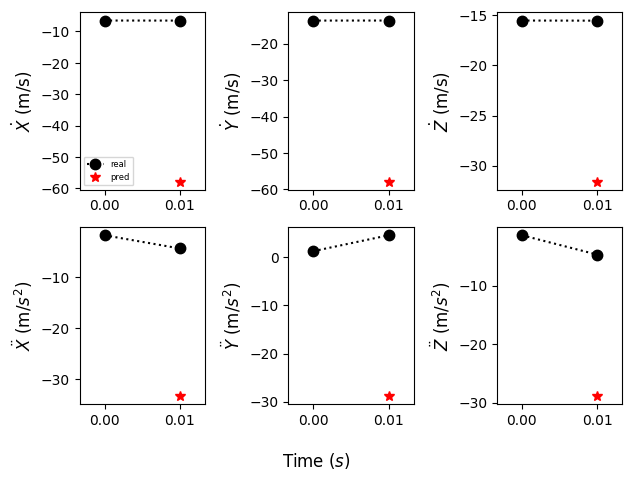

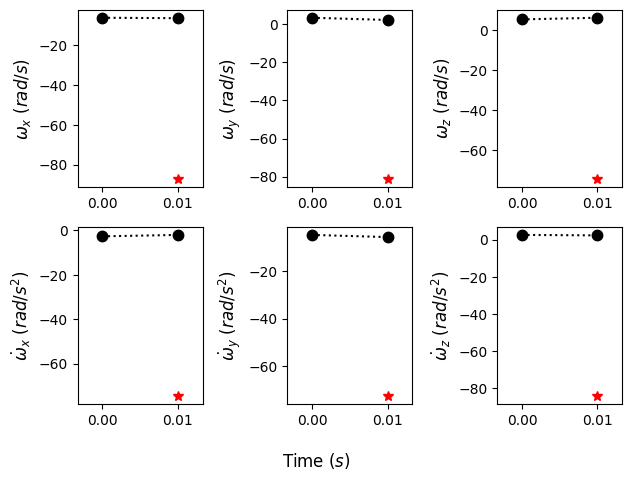

Current Batch Train Loss: 46181.31640625

Current Batch Train Loss: 9043.994140625

Current Batch Train Loss: 2551.491455078125

Current Batch Train Loss: 1154.8936767578125

Current Batch Train Loss: 1178.555419921875

Current Batch Train Loss: 995.8952026367188

Current Batch Train Loss: 987.4628295898438

Current Batch Train Loss: 978.2669067382812

Current Batch Train Loss: 962.3688354492188

Current Batch Train Loss: 967.2192993164062

Current Batch Train Loss: 962.22265625

Current Batch Train Loss: 946.419189453125

Current Batch Train Loss: 940.9246215820312

Current Batch Train Loss: 929.9232788085938

Current Batch Train Loss: 931.46728515625

Current Batch Train Loss: 908.7180786132812

Current Batch Train Loss: 888.9758911132812

Current Batch Train Loss: 813.12158203125

Current Batch Train Loss: 784.93115234375

Current Batch Train Loss: 787.1433715820312

Current Batch Train Loss: 788.1859130859375

Current Batch Train Loss: 778.5397338867188

Current Batch Train Loss: 7

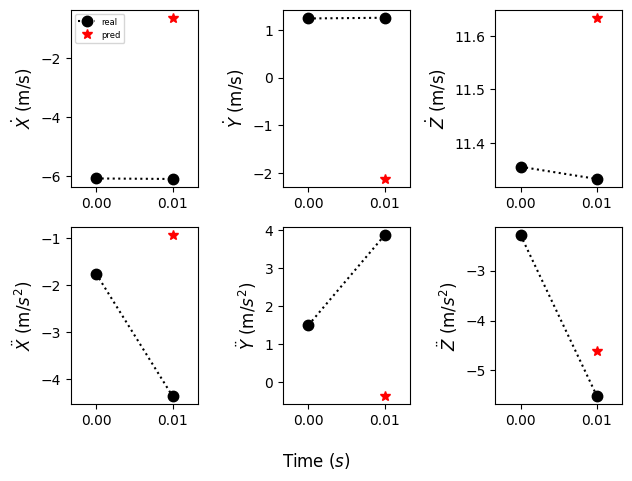

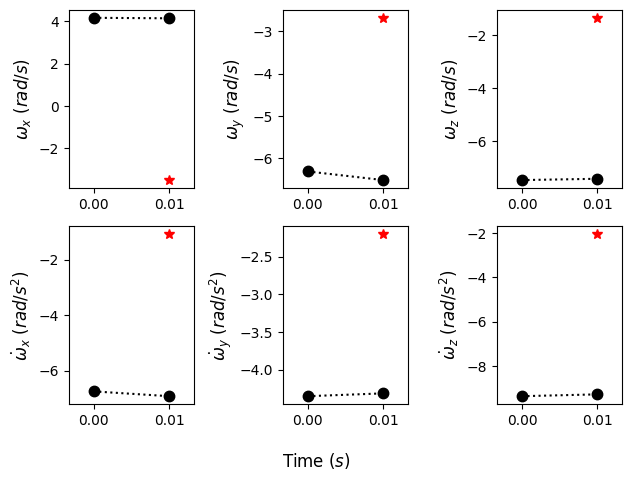

Current Batch Train Loss: 741.495849609375

Current Batch Train Loss: 749.4348754882812

Current Batch Train Loss: 738.343017578125

Current Batch Train Loss: 754.008544921875

Current Batch Train Loss: 737.1255493164062

Current Batch Train Loss: 749.1477661132812

Current Batch Train Loss: 743.70947265625

Current Batch Train Loss: 718.8367919921875

Current Batch Train Loss: 722.074951171875

Current Batch Train Loss: 732.9408569335938

Current Batch Train Loss: 709.4951171875

Current Batch Train Loss: 709.3386840820312

Current Batch Train Loss: 711.862060546875

Current Batch Train Loss: 696.3195190429688

Current Batch Train Loss: 673.4335327148438

Current Batch Train Loss: 643.5130615234375

Current Batch Train Loss: 646.8742065429688

Current Batch Train Loss: 655.555908203125

Current Batch Train Loss: 642.2117919921875

Current Batch Train Loss: 645.957763671875

Current Batch Train Loss: 630.547119140625

Current Batch Train Loss: 631.3204956054688

Current Batch Train Los

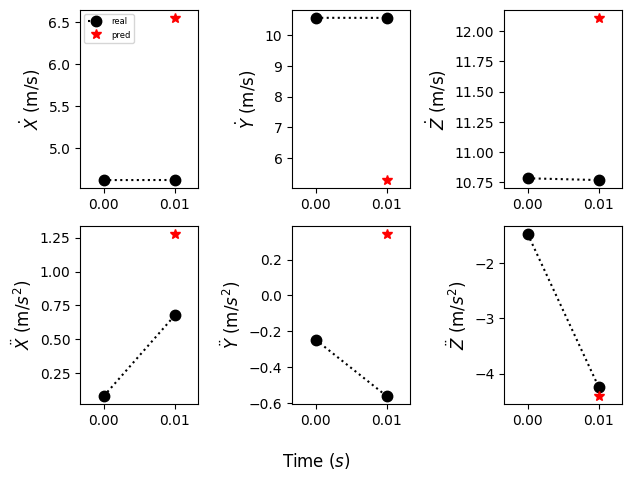

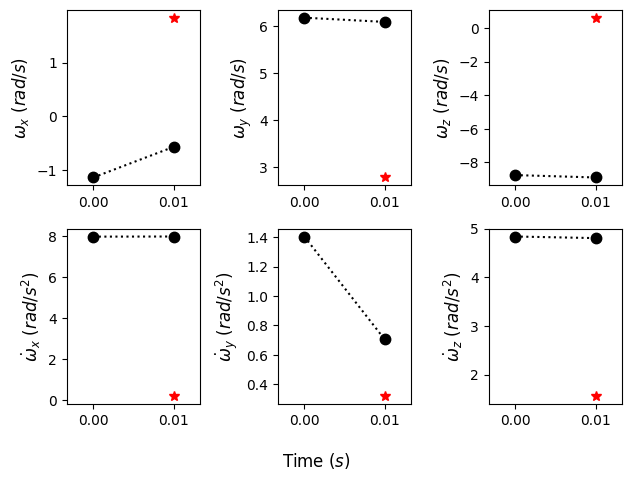

Current Batch Train Loss: 627.7764892578125

Current Batch Train Loss: 614.6474609375

Current Batch Train Loss: 611.7311401367188

Current Batch Train Loss: 608.5836791992188

Current Batch Train Loss: 611.0850830078125

Current Batch Train Loss: 610.1080932617188

Current Batch Train Loss: 601.57763671875

Current Batch Train Loss: 603.3993530273438

Current Batch Train Loss: 595.2344970703125

Current Batch Train Loss: 591.5845336914062

Current Batch Train Loss: 587.9634399414062

Current Batch Train Loss: 581.2981567382812

Current Batch Train Loss: 594.5120239257812

Current Batch Train Loss: 594.8215942382812

Current Batch Train Loss: 588.0375366210938

Current Batch Train Loss: 586.3362426757812

Current Batch Train Loss: 586.5750732421875

Current Batch Train Loss: 567.5653076171875

Current Batch Train Loss: 575.3432006835938

Current Batch Train Loss: 564.47998046875

Current Batch Train Loss: 568.2045288085938

Current Batch Train Loss: 555.4452514648438

Current Batch Tra

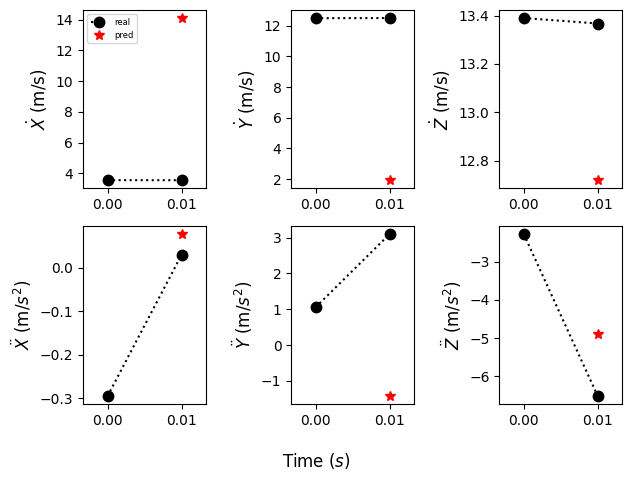

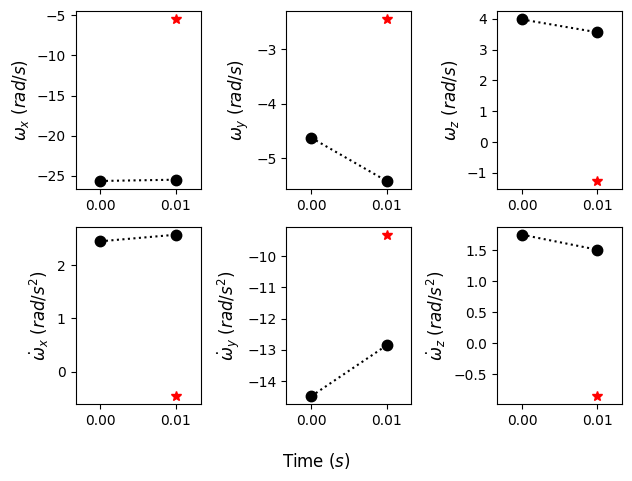

Current Batch Train Loss: 506.5842590332031

Current Batch Train Loss: 504.1830749511719

Current Batch Train Loss: 498.4803466796875

Current Batch Train Loss: 490.4017028808594

Current Batch Train Loss: 479.0103759765625

Current Batch Train Loss: 476.3721923828125

Current Batch Train Loss: 482.04595947265625

Current Batch Train Loss: 474.15484619140625

Current Batch Train Loss: 471.5284729003906

Current Batch Train Loss: 478.01611328125

Current Batch Train Loss: 475.26953125

Current Batch Train Loss: 465.37493896484375

Current Batch Train Loss: 463.8129577636719

Current Batch Train Loss: 447.78167724609375

Current Batch Train Loss: 456.7787780761719

Current Batch Train Loss: 458.5614013671875

Current Batch Train Loss: 445.3746643066406

Current Batch Train Loss: 434.441162109375

Current Batch Train Loss: 434.8755187988281

Current Batch Train Loss: 423.4181823730469

Current Batch Train Loss: 425.52313232421875

Current Batch Train Loss: 414.86236572265625

Current Batc

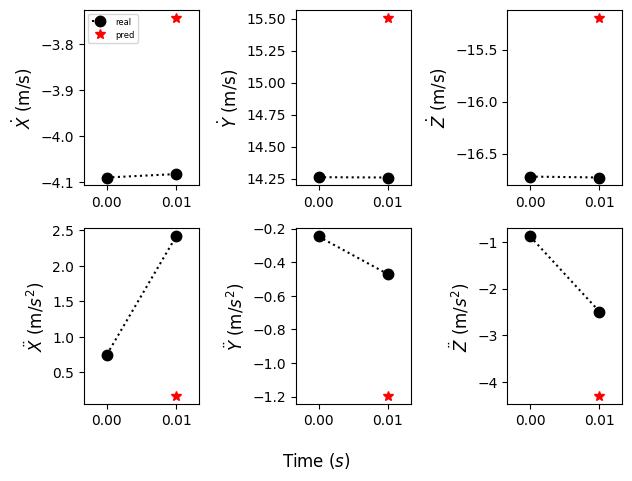

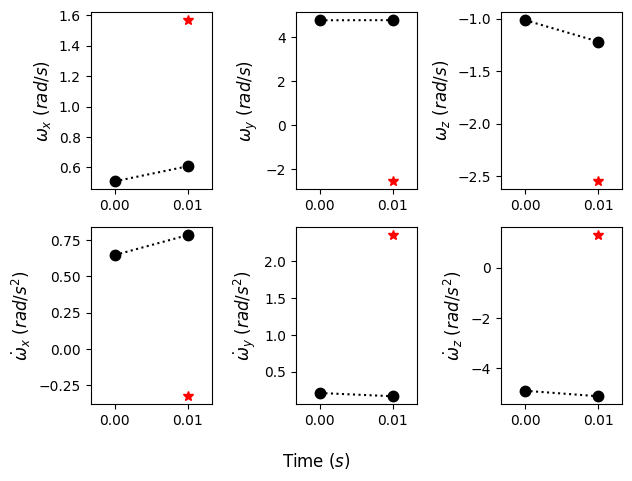

Current Batch Train Loss: 378.10784912109375

Current Batch Train Loss: 369.86566162109375

Current Batch Train Loss: 372.72607421875

Current Batch Train Loss: 366.1028137207031

Current Batch Train Loss: 372.1769104003906

Current Batch Train Loss: 367.8976135253906

Current Batch Train Loss: 374.2381896972656

Current Batch Train Loss: 365.0517272949219

Current Batch Train Loss: 362.72967529296875

Current Batch Train Loss: 364.1742858886719

Current Batch Train Loss: 360.5976867675781

Current Batch Train Loss: 363.371337890625

Current Batch Train Loss: 353.1210021972656

Current Batch Train Loss: 351.679931640625

Current Batch Train Loss: 357.6056213378906

Current Batch Train Loss: 352.9557189941406

Current Batch Train Loss: 353.0260314941406

Current Batch Train Loss: 349.0284729003906

Current Batch Train Loss: 352.9256286621094

Current Batch Train Loss: 344.8497009277344

Current Batch Train Loss: 350.31304931640625

Current Batch Train Loss: 345.7118225097656

Current Ba

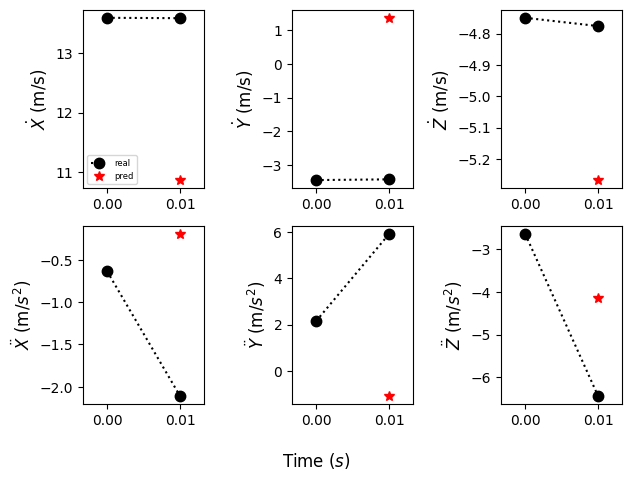

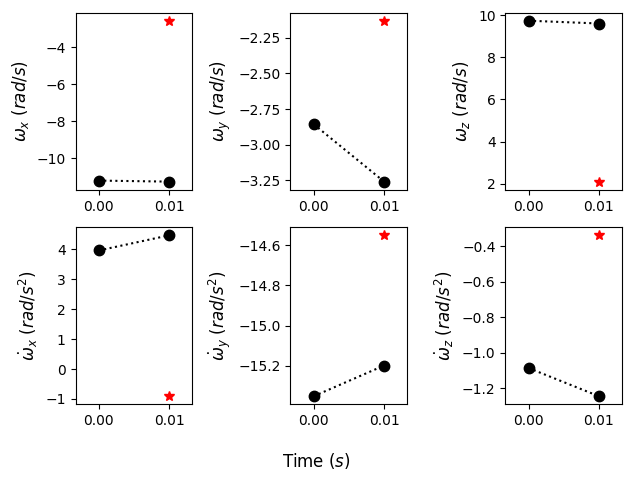

Current Batch Train Loss: 342.34356689453125

Current Batch Train Loss: 339.66583251953125

Current Batch Train Loss: 339.85333251953125

Current Batch Train Loss: 340.4862976074219

Current Batch Train Loss: 329.99176025390625

Current Batch Train Loss: 334.1642761230469

Current Batch Train Loss: 338.1353454589844

Current Batch Train Loss: 333.67498779296875

Current Batch Train Loss: 325.3108825683594

Current Batch Train Loss: 334.21697998046875

Current Batch Train Loss: 332.1628723144531

Current Batch Train Loss: 332.6774597167969

Current Batch Train Loss: 327.8683166503906

Current Batch Train Loss: 327.1671142578125

Current Batch Train Loss: 324.2507629394531

Current Batch Train Loss: 327.6459045410156

Current Batch Train Loss: 325.9649353027344

Current Batch Train Loss: 333.43389892578125

Current Batch Train Loss: 326.68389892578125

Current Batch Train Loss: 324.2402648925781

Current Batch Train Loss: 325.7462463378906

Current Batch Train Loss: 325.7596435546875

Cu

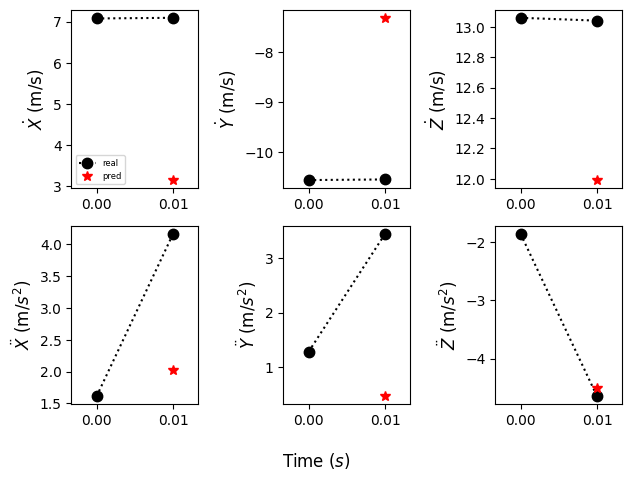

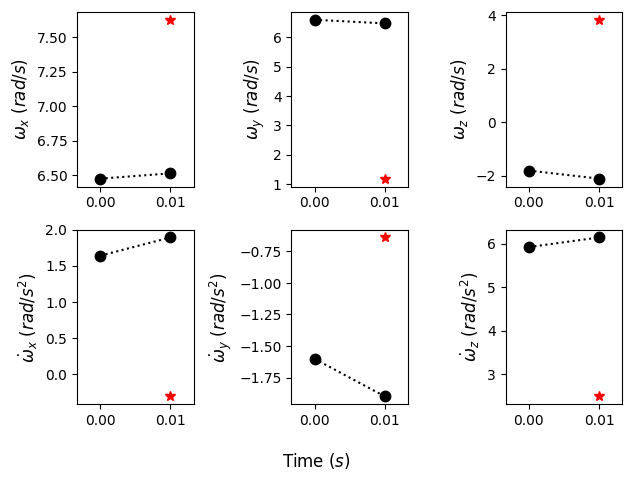

Current Batch Train Loss: 311.9156494140625

Current Batch Train Loss: 314.3175964355469

Current Batch Train Loss: 313.4688415527344

Current Batch Train Loss: 306.2139587402344

Current Batch Train Loss: 306.5372009277344

Current Batch Train Loss: 307.2442932128906

Current Batch Train Loss: 300.4564514160156

Current Batch Train Loss: 294.6844482421875

Current Batch Train Loss: 295.6143493652344

Current Batch Train Loss: 296.7632141113281

Current Batch Train Loss: 290.7928771972656

Current Batch Train Loss: 285.6236572265625

Current Batch Train Loss: 286.1787109375

Current Batch Train Loss: 278.0273132324219

Current Batch Train Loss: 273.3022155761719

Current Batch Train Loss: 270.28338623046875

Current Batch Train Loss: 273.4438781738281

Current Batch Train Loss: 273.4979248046875

Current Batch Train Loss: 261.736083984375

Current Batch Train Loss: 264.062744140625

Current Batch Train Loss: 258.00811767578125

Current Batch Train Loss: 259.1207580566406

Current Batch

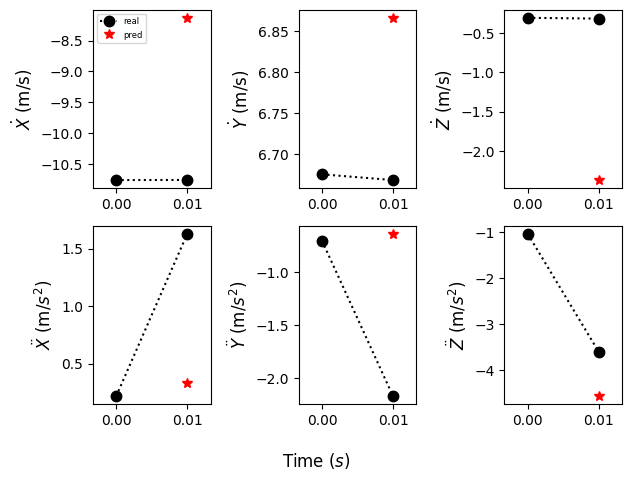

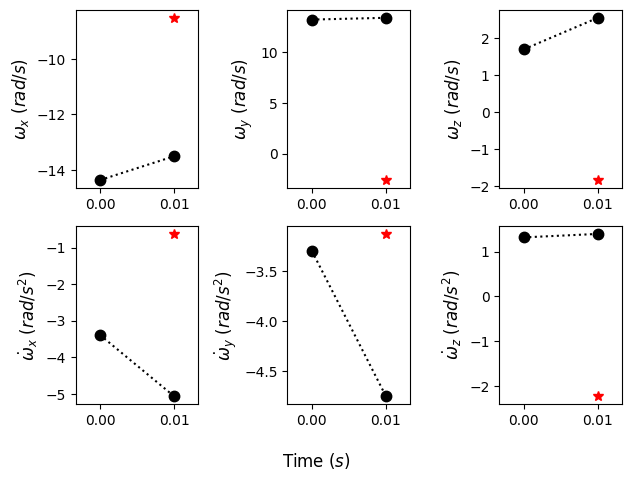

Current Batch Train Loss: 243.1746826171875

Current Batch Train Loss: 245.1558074951172

Current Batch Train Loss: 243.5196075439453

Current Batch Train Loss: 243.85830688476562

Current Batch Train Loss: 242.72010803222656

Current Batch Train Loss: 243.19439697265625

Current Batch Train Loss: 239.48272705078125

Current Batch Train Loss: 233.7643280029297

Current Batch Train Loss: 233.8667755126953

Current Batch Train Loss: 232.17257690429688

Current Batch Train Loss: 233.0076904296875

Current Batch Train Loss: 236.20936584472656

Current Batch Train Loss: 232.3184814453125

Current Batch Train Loss: 223.43179321289062

Current Batch Train Loss: 224.86216735839844

Current Batch Train Loss: 222.7280731201172

Current Batch Train Loss: 223.3900909423828

Current Batch Train Loss: 220.6974334716797

Current Batch Train Loss: 221.26808166503906

Current Batch Train Loss: 224.40345764160156

Current Batch Train Loss: 219.64947509765625

Current Batch Train Loss: 220.66957092285156

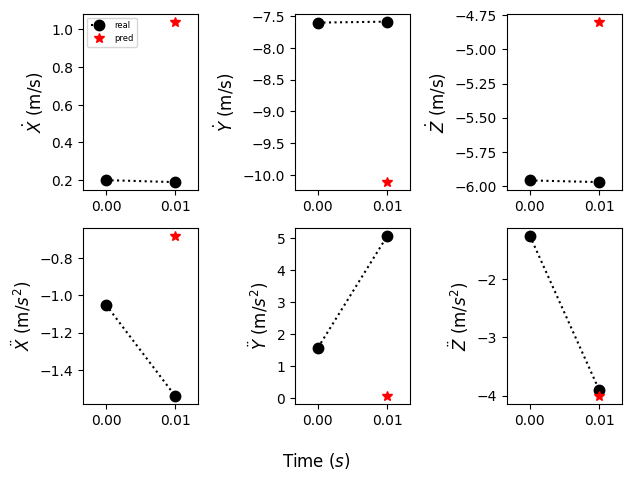

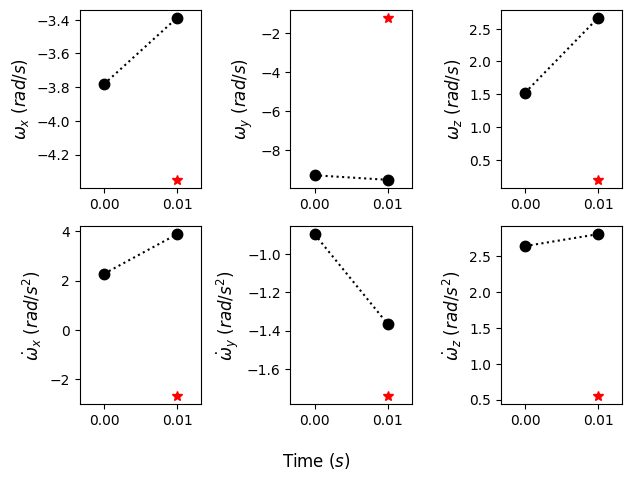

Current Batch Train Loss: 206.66600036621094

Current Batch Train Loss: 216.78057861328125

Current Batch Train Loss: 213.31314086914062

Current Batch Train Loss: 208.46371459960938

Current Batch Train Loss: 214.64952087402344

Current Batch Train Loss: 210.36985778808594

Current Batch Train Loss: 207.67318725585938

Current Batch Train Loss: 208.55831909179688

Current Batch Train Loss: 215.58633422851562

Current Batch Train Loss: 208.363525390625

Current Batch Train Loss: 209.91896057128906

Current Batch Train Loss: 207.8956756591797

Current Batch Train Loss: 227.946044921875

Current Batch Train Loss: 206.7064666748047

Current Batch Train Loss: 208.08799743652344

Current Batch Train Loss: 206.77297973632812

Current Batch Train Loss: 203.59054565429688

Current Batch Train Loss: 203.6002960205078

Current Batch Train Loss: 202.85276794433594

Current Batch Train Loss: 210.6506805419922

Current Batch Train Loss: 205.23716735839844

Current Batch Train Loss: 205.571258544921

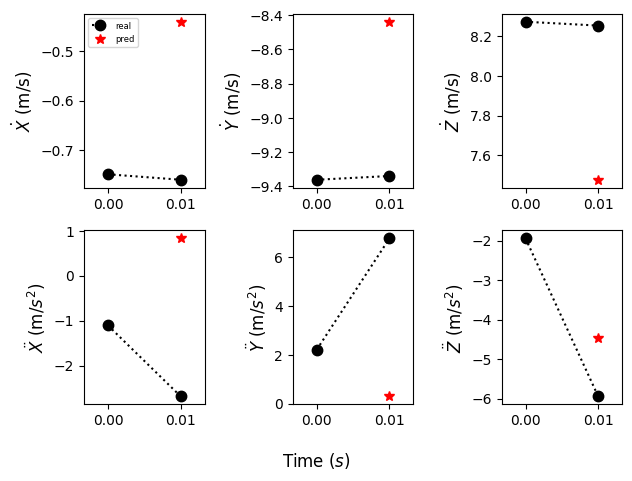

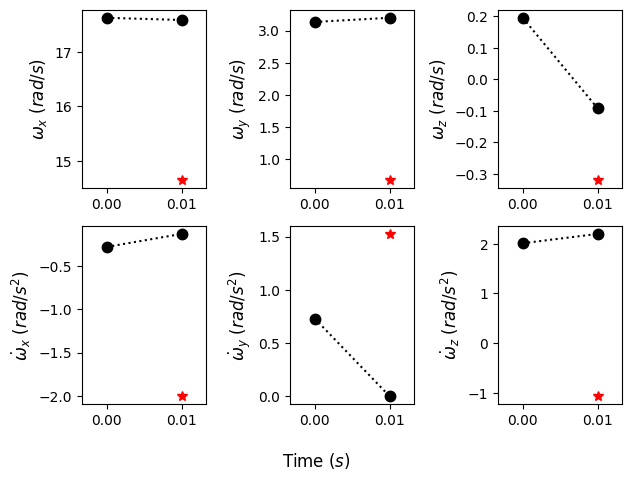

Current Batch Train Loss: 206.00564575195312

Current Batch Train Loss: 206.35806274414062

Current Batch Train Loss: 203.50477600097656

Current Batch Train Loss: 210.32894897460938

Current Batch Train Loss: 205.59938049316406

Current Batch Train Loss: 202.9907684326172

Current Batch Train Loss: 199.82760620117188

Current Batch Train Loss: 205.82948303222656

Current Batch Train Loss: 194.03822326660156

Current Batch Train Loss: 200.07350158691406

Current Batch Train Loss: 204.95413208007812

Current Batch Train Loss: 201.06349182128906

Current Batch Train Loss: 205.64297485351562

Current Batch Train Loss: 202.849609375

Current Batch Train Loss: 199.29263305664062

Current Batch Train Loss: 212.3176727294922

Current Batch Train Loss: 202.42742919921875

Current Batch Train Loss: 201.6659393310547

Current Batch Train Loss: 204.0050811767578

Current Batch Train Loss: 201.03089904785156

Current Batch Train Loss: 203.81326293945312

Current Batch Train Loss: 201.9851837158203

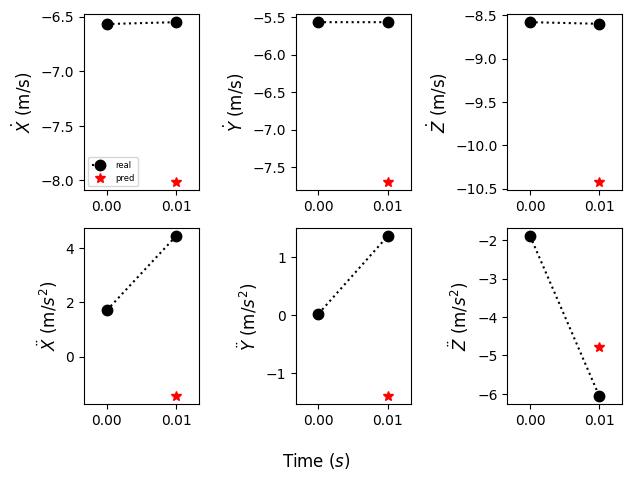

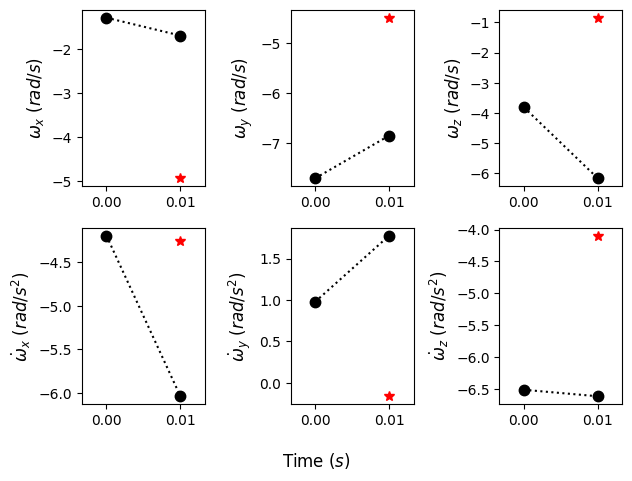

Current Batch Train Loss: 199.80386352539062

Current Batch Train Loss: 201.11282348632812

Current Batch Train Loss: 203.48687744140625

Current Batch Train Loss: 205.61180114746094

Current Batch Train Loss: 195.2550506591797

Current Batch Train Loss: 200.00802612304688

Current Batch Train Loss: 204.56707763671875

Current Batch Train Loss: 199.16775512695312

Current Batch Train Loss: 200.6997528076172

Current Batch Train Loss: 194.88658142089844

Current Batch Train Loss: 199.1295623779297

Current Batch Train Loss: 197.87188720703125

Current Batch Train Loss: 192.580322265625

Current Batch Train Loss: 201.4653778076172

Current Batch Train Loss: 195.03407287597656

Current Batch Train Loss: 195.22445678710938

Current Batch Train Loss: 218.230712890625

Current Batch Train Loss: 210.55772399902344

Current Batch Train Loss: 198.19769287109375

Current Batch Train Loss: 198.53741455078125

Current Batch Train Loss: 196.06578063964844

Current Batch Train Loss: 198.363739013671

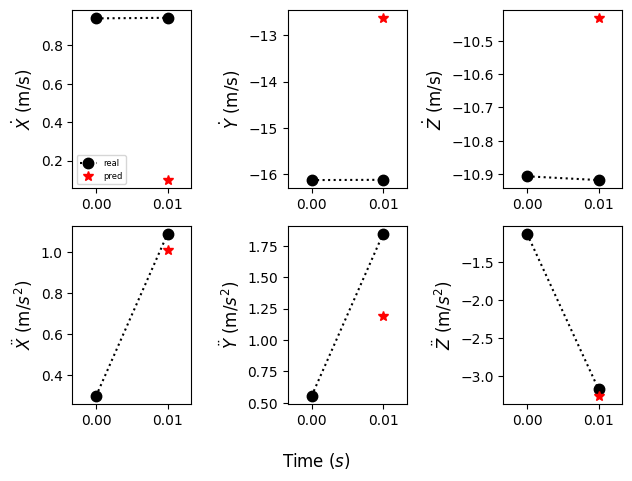

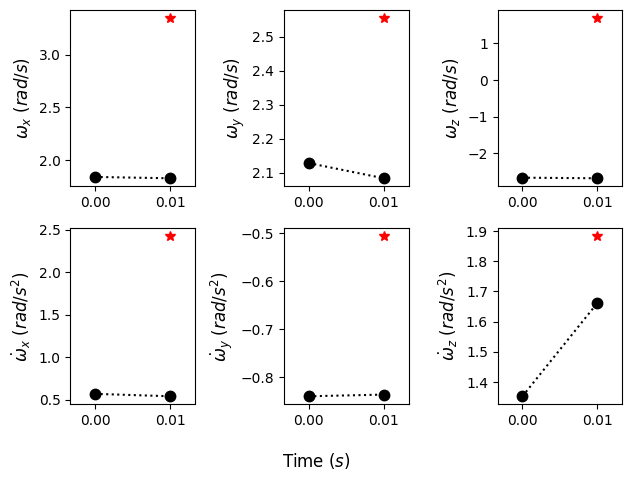

Current Batch Train Loss: 201.26425170898438

Current Batch Train Loss: 203.83811950683594

Current Batch Train Loss: 200.98565673828125

Current Batch Train Loss: 194.9541778564453

Current Batch Train Loss: 201.07217407226562

Current Batch Train Loss: 194.08082580566406

Current Batch Train Loss: 193.01963806152344

Current Batch Train Loss: 193.02056884765625

Current Batch Train Loss: 202.8833770751953

Current Batch Train Loss: 194.9056396484375

Current Batch Train Loss: 193.6801300048828

Current Batch Train Loss: 195.79090881347656

Current Batch Train Loss: 195.11007690429688

Current Batch Train Loss: 199.79461669921875

Current Batch Train Loss: 194.80088806152344

Current Batch Train Loss: 199.9067840576172

Current Batch Train Loss: 197.4097900390625

Current Batch Train Loss: 199.00096130371094

Current Batch Train Loss: 195.91558837890625

Current Batch Train Loss: 193.29898071289062

Current Batch Train Loss: 193.6263427734375

Current Batch Train Loss: 197.21612548828

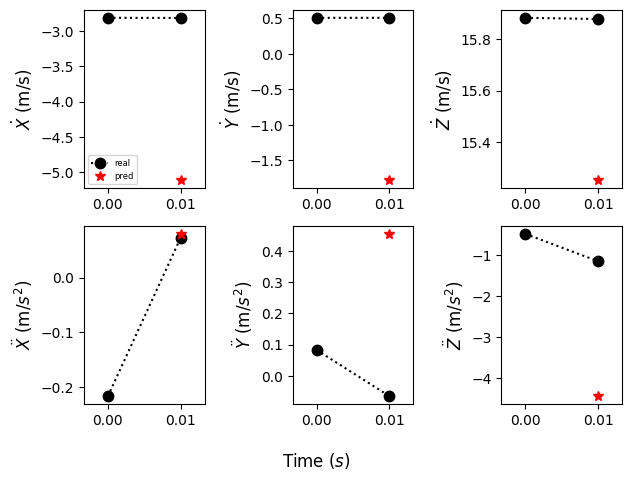

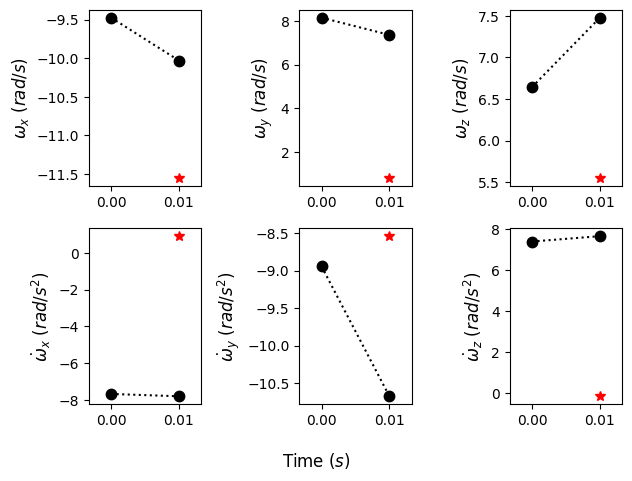

Current Batch Train Loss: 193.4010772705078

Current Batch Train Loss: 195.5773468017578

Current Batch Train Loss: 197.41014099121094

Current Batch Train Loss: 194.36489868164062

Current Batch Train Loss: 195.63851928710938

Current Batch Train Loss: 193.75030517578125

Current Batch Train Loss: 194.96165466308594

Current Batch Train Loss: 188.49363708496094

Current Batch Train Loss: 187.8722381591797

Current Batch Train Loss: 192.3275146484375

Current Batch Train Loss: 195.07566833496094

Current Batch Train Loss: 191.58775329589844

Current Batch Train Loss: 207.67648315429688

Current Batch Train Loss: 194.5704803466797

Current Batch Train Loss: 204.27883911132812

Current Batch Train Loss: 191.51312255859375

Current Batch Train Loss: 198.79197692871094

Current Batch Train Loss: 196.32888793945312

Current Batch Train Loss: 194.7389373779297

Current Batch Train Loss: 190.71803283691406

Current Batch Train Loss: 188.13015747070312

Current Batch Train Loss: 192.0737304687

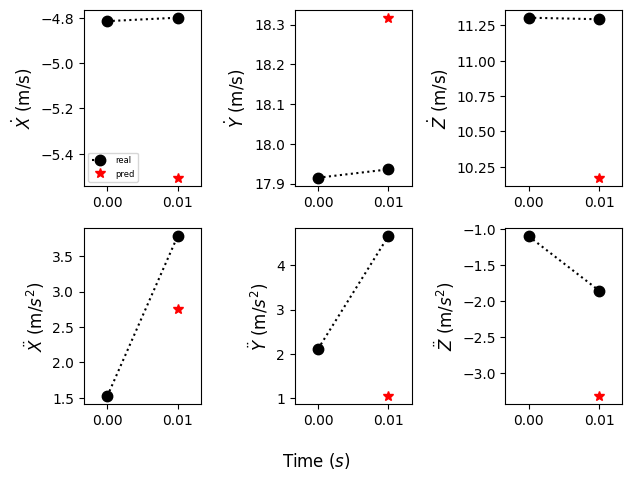

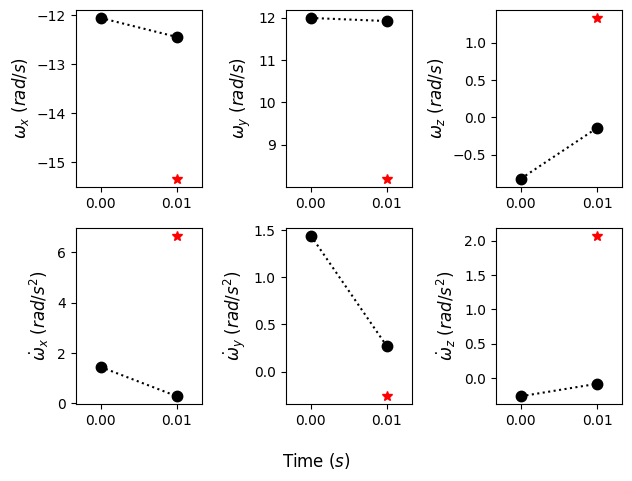

Current Batch Train Loss: 192.9247589111328

Current Batch Train Loss: 189.93453979492188

Current Batch Train Loss: 197.20469665527344

Current Batch Train Loss: 198.8416748046875

Current Batch Train Loss: 195.80587768554688

Current Batch Train Loss: 191.93942260742188

Current Batch Train Loss: 200.17884826660156

Current Batch Train Loss: 192.7323760986328

Current Batch Train Loss: 191.38955688476562

Current Batch Train Loss: 191.3828582763672

Current Batch Train Loss: 192.64517211914062

Current Batch Train Loss: 202.19715881347656

Current Batch Train Loss: 190.22360229492188

Current Batch Train Loss: 190.2777557373047

Current Batch Train Loss: 195.20973205566406

Current Batch Train Loss: 188.9085235595703

Current Batch Train Loss: 190.60633850097656

Current Batch Train Loss: 187.11993408203125

Current Batch Train Loss: 199.1047821044922

Current Batch Train Loss: 193.84600830078125

Current Batch Train Loss: 188.67543029785156

Current Batch Train Loss: 189.16552734375

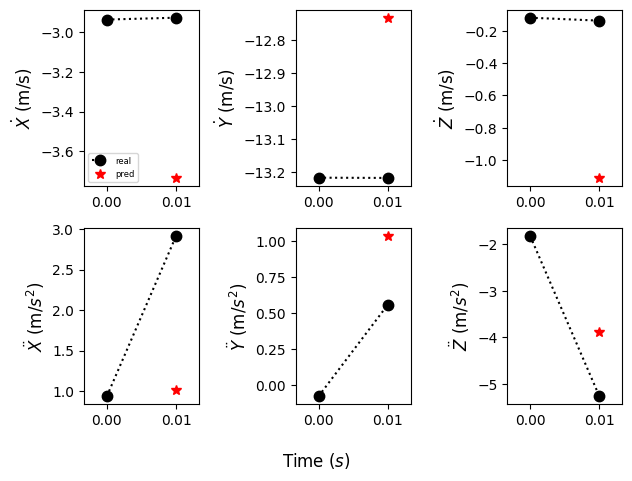

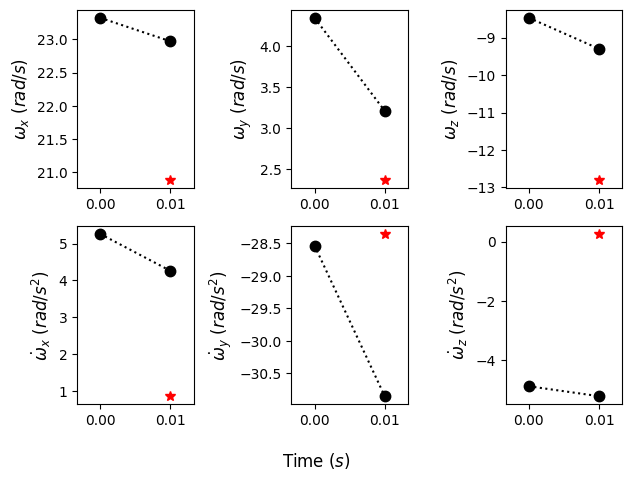

Current Batch Train Loss: 190.97984313964844

Current Batch Train Loss: 190.51531982421875

Current Batch Train Loss: 188.09507751464844

Current Batch Train Loss: 189.1669464111328

Current Batch Train Loss: 190.7362823486328

Current Batch Train Loss: 187.12367248535156

Current Batch Train Loss: 190.89004516601562

Current Batch Train Loss: 188.90658569335938

Current Batch Train Loss: 193.3903350830078

Current Batch Train Loss: 188.60353088378906

Current Batch Train Loss: 182.38018798828125

Current Batch Train Loss: 187.54237365722656

Current Batch Train Loss: 187.55923461914062

Current Batch Train Loss: 192.7037353515625

Current Batch Train Loss: 193.61305236816406

Current Batch Train Loss: 188.6141815185547

Current Batch Train Loss: 188.61631774902344

Current Batch Train Loss: 185.35972595214844

Current Batch Train Loss: 187.71163940429688

Current Batch Train Loss: 191.34974670410156

Current Batch Train Loss: 185.6415252685547

Current Batch Train Loss: 187.6465911865

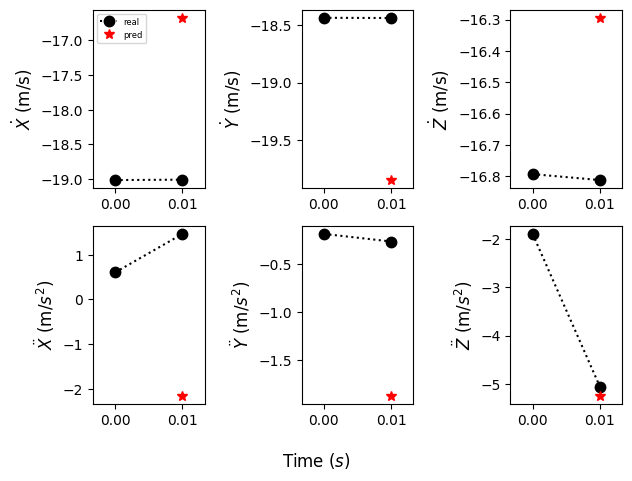

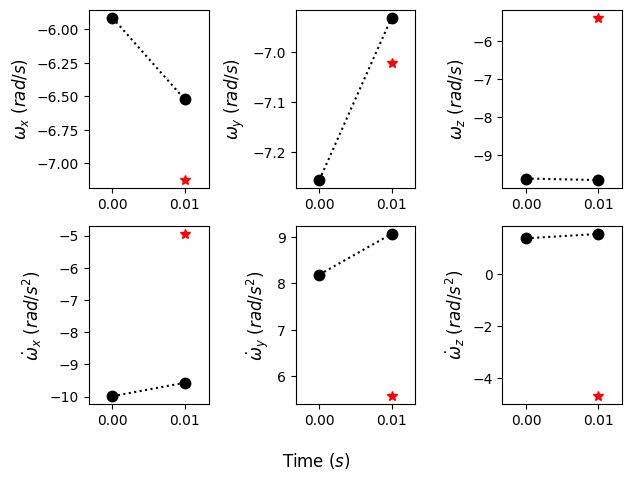

Current Batch Train Loss: 189.10841369628906

Current Batch Train Loss: 186.46119689941406

Current Batch Train Loss: 191.57489013671875

Current Batch Train Loss: 183.9567413330078

Current Batch Train Loss: 187.3833465576172

Current Batch Train Loss: 191.41725158691406

Current Batch Train Loss: 185.40682983398438

Current Batch Train Loss: 189.15480041503906

Current Batch Train Loss: 187.83489990234375

Current Batch Train Loss: 188.4381561279297

Current Batch Train Loss: 193.10377502441406

Current Batch Train Loss: 193.43795776367188

Current Batch Train Loss: 189.60055541992188

Current Batch Train Loss: 184.078369140625

Current Batch Train Loss: 184.9823455810547

Current Batch Train Loss: 188.187744140625

Current Batch Train Loss: 187.0092315673828

Current Batch Train Loss: 183.83872985839844

Current Batch Train Loss: 184.15589904785156

Current Batch Train Loss: 187.39242553710938

Current Batch Train Loss: 186.7713165283203

Current Batch Train Loss: 187.77682495117188

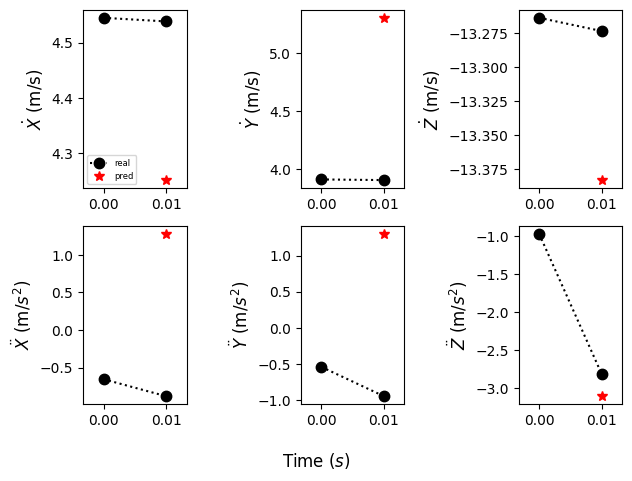

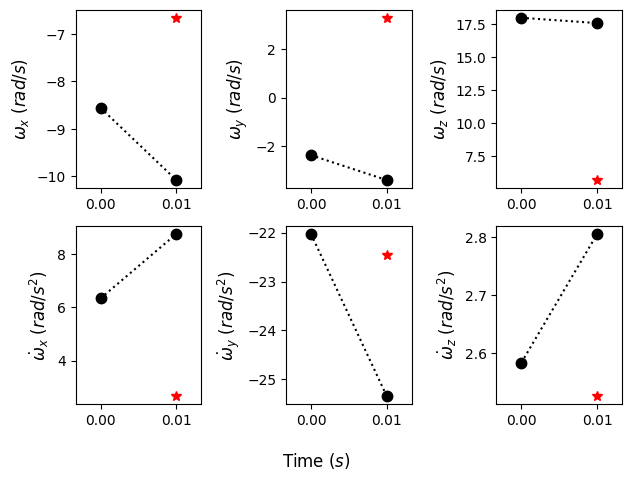

Current Batch Train Loss: 185.38294982910156

Current Batch Train Loss: 188.12477111816406

Current Batch Train Loss: 182.5614013671875

Current Batch Train Loss: 185.71524047851562

Current Batch Train Loss: 186.2954864501953

Current Batch Train Loss: 186.5314178466797

Current Batch Train Loss: 183.50808715820312

Current Batch Train Loss: 185.77565002441406

Current Batch Train Loss: 188.67355346679688

Current Batch Train Loss: 189.30528259277344

Current Batch Train Loss: 184.51182556152344

Current Batch Train Loss: 181.7791290283203

Current Batch Train Loss: 184.405517578125

Current Batch Train Loss: 186.65646362304688

Current Batch Train Loss: 183.4767303466797

Current Batch Train Loss: 178.0532989501953

Current Batch Train Loss: 182.1031951904297

Current Batch Train Loss: 188.0679931640625

Current Batch Train Loss: 181.64666748046875

Current Batch Train Loss: 183.51324462890625

Current Batch Train Loss: 183.25160217285156

Current Batch Train Loss: 183.31167602539062

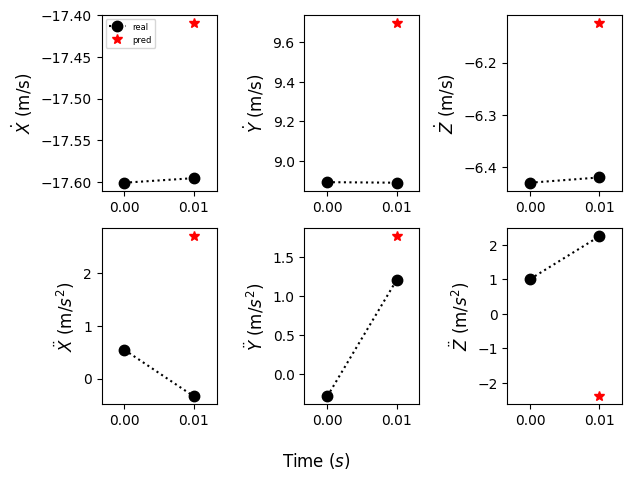

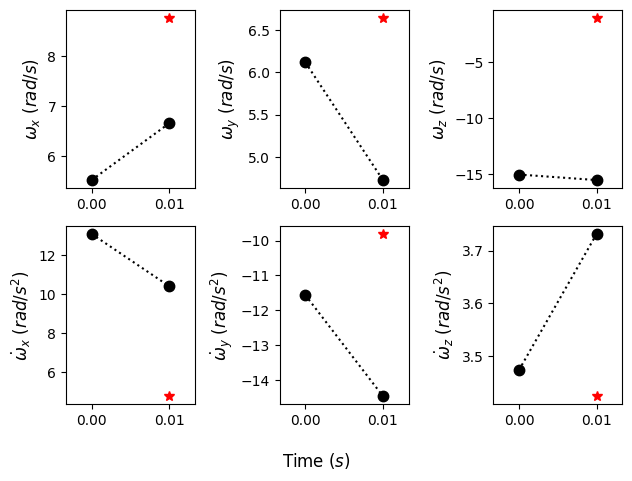

Current Batch Train Loss: 182.62217712402344

Current Batch Train Loss: 182.52047729492188

Current Batch Train Loss: 180.40289306640625

Current Batch Train Loss: 182.5623779296875

Current Batch Train Loss: 184.73178100585938

Current Batch Train Loss: 183.86769104003906

Current Batch Train Loss: 182.63722229003906

Current Batch Train Loss: 180.1500701904297

Current Batch Train Loss: 189.03826904296875

Current Batch Train Loss: 180.3883819580078

Current Batch Train Loss: 182.2156982421875

Current Batch Train Loss: 182.19679260253906

Current Batch Train Loss: 192.91746520996094

Current Batch Train Loss: 180.86582946777344

Current Batch Train Loss: 181.39105224609375

Current Batch Train Loss: 183.88584899902344

Current Batch Train Loss: 182.8927764892578

Current Batch Train Loss: 180.97084045410156

Current Batch Train Loss: 181.37445068359375

Current Batch Train Loss: 182.7430877685547

Current Batch Train Loss: 185.15260314941406

Current Batch Train Loss: 179.5539245605

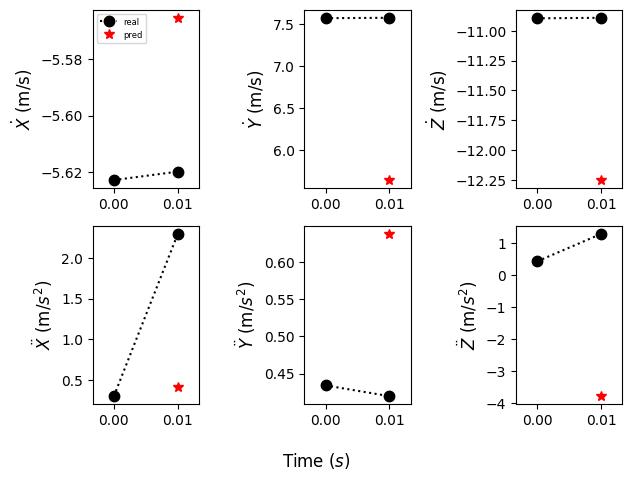

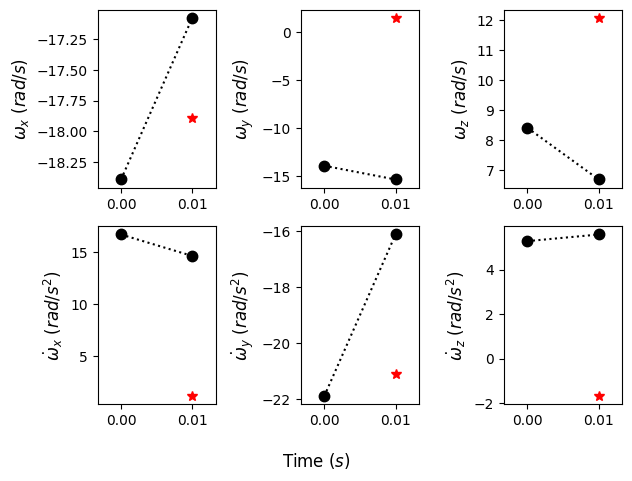

Current Batch Train Loss: 181.27084350585938

Current Batch Train Loss: 182.60154724121094

Current Batch Train Loss: 184.72657775878906

Current Batch Train Loss: 177.77415466308594

Current Batch Train Loss: 184.60533142089844

Current Batch Train Loss: 179.3044891357422

Current Batch Train Loss: 182.59243774414062

Current Batch Train Loss: 178.84413146972656

Current Batch Train Loss: 178.8417510986328

Current Batch Train Loss: 176.5254669189453

Current Batch Train Loss: 180.99134826660156

Current Batch Train Loss: 181.0929412841797

Current Batch Train Loss: 179.47825622558594

Current Batch Train Loss: 175.92991638183594

Current Batch Train Loss: 176.92320251464844

Current Batch Train Loss: 177.97994995117188

Current Batch Train Loss: 183.11627197265625

Current Batch Train Loss: 182.28704833984375

Current Batch Train Loss: 184.22035217285156

Current Batch Train Loss: 180.91903686523438

Current Batch Train Loss: 180.53643798828125

Current Batch Train Loss: 176.14538574

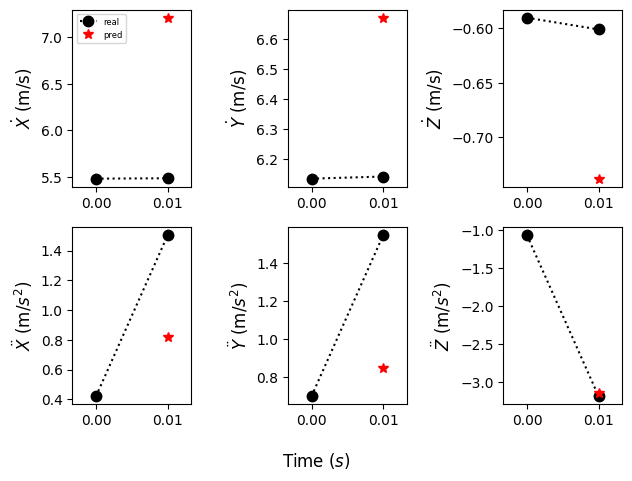

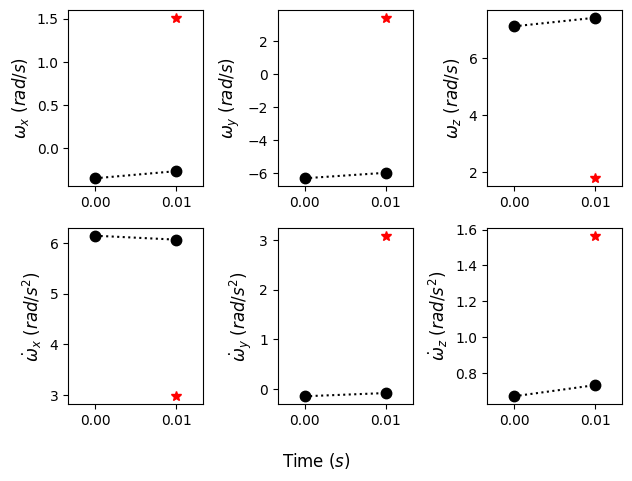

Current Batch Train Loss: 178.1103057861328

Current Batch Train Loss: 175.85935974121094

Current Batch Train Loss: 182.947021484375

Current Batch Train Loss: 180.06016540527344

Current Batch Train Loss: 179.3366241455078

Current Batch Train Loss: 179.1569061279297

Current Batch Train Loss: 182.0794677734375

Current Batch Train Loss: 179.208740234375

Current Batch Train Loss: 177.13540649414062

Current Batch Train Loss: 176.32498168945312

Current Batch Train Loss: 180.65550231933594

Current Batch Train Loss: 178.0350799560547

Current Batch Train Loss: 177.88369750976562

Current Batch Train Loss: 176.8134002685547

Current Batch Train Loss: 179.57107543945312

Current Batch Train Loss: 181.14053344726562

Current Batch Train Loss: 178.03427124023438

Current Batch Train Loss: 180.4165496826172

Current Batch Train Loss: 179.09046936035156

Current Batch Train Loss: 180.23609924316406

Current Batch Train Loss: 172.23548889160156

Current Batch Train Loss: 176.88807678222656


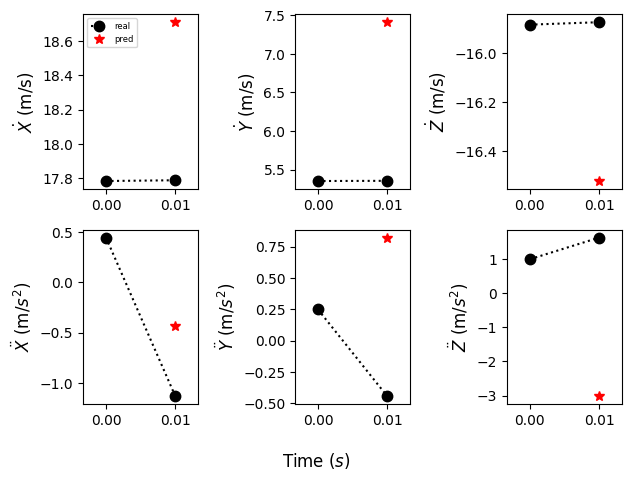

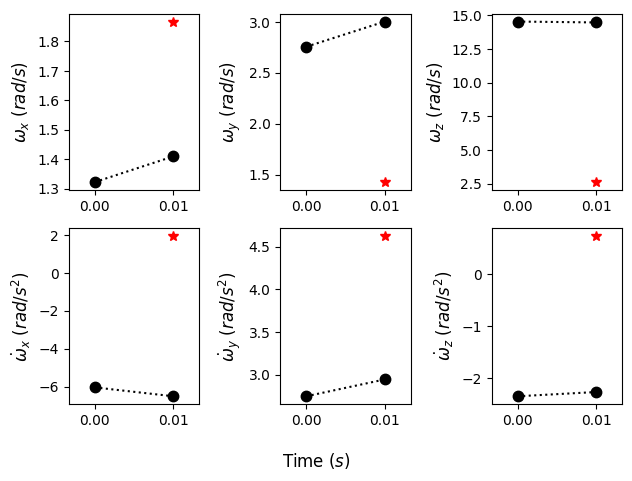

Current Batch Train Loss: 178.02093505859375

Current Batch Train Loss: 179.31417846679688

Current Batch Train Loss: 174.55972290039062

Current Batch Train Loss: 178.9909210205078

Current Batch Train Loss: 178.5300750732422

Current Batch Train Loss: 177.13363647460938

Current Batch Train Loss: 173.97781372070312

Current Batch Train Loss: 173.2256317138672

Current Batch Train Loss: 172.16329956054688

Current Batch Train Loss: 177.80752563476562

Current Batch Train Loss: 176.6073455810547

Current Batch Train Loss: 176.379638671875

Current Batch Train Loss: 173.61447143554688

Current Batch Train Loss: 180.10899353027344

Current Batch Train Loss: 177.62767028808594

Current Batch Train Loss: 178.66366577148438

Current Batch Train Loss: 169.7116241455078

Current Batch Train Loss: 177.1358642578125

Current Batch Train Loss: 174.9385528564453

Current Batch Train Loss: 175.11917114257812

Current Batch Train Loss: 173.58448791503906

Current Batch Train Loss: 173.4089965820312

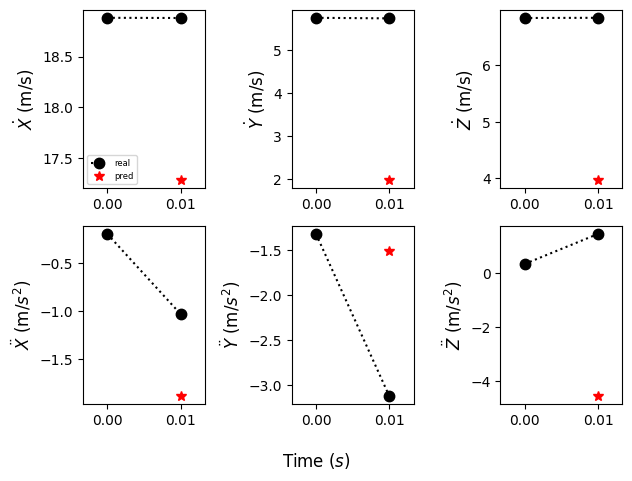

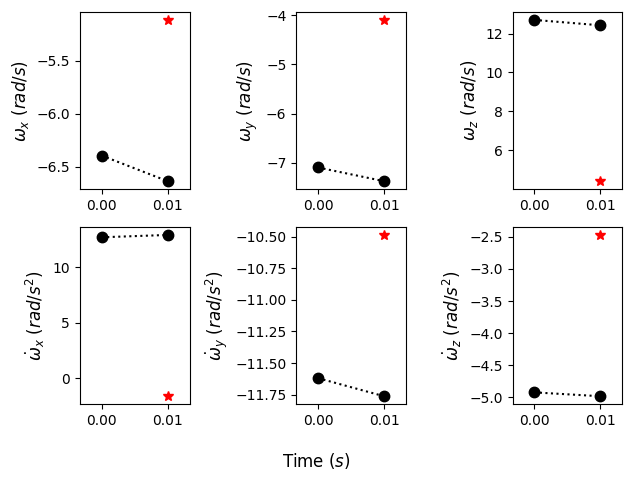

Current Batch Train Loss: 174.7344970703125

Current Batch Train Loss: 176.17173767089844

Current Batch Train Loss: 176.58367919921875

Current Batch Train Loss: 170.49575805664062

Current Batch Train Loss: 170.61727905273438

Current Batch Train Loss: 171.81771850585938

Current Batch Train Loss: 173.31272888183594

Current Batch Train Loss: 173.14524841308594

Current Batch Train Loss: 173.94912719726562

Current Batch Train Loss: 170.93148803710938

Current Batch Train Loss: 172.88909912109375

Current Batch Train Loss: 176.08746337890625

Current Batch Train Loss: 176.87037658691406

Current Batch Train Loss: 173.1765899658203

Current Batch Train Loss: 173.02357482910156

Current Batch Train Loss: 171.41070556640625

Current Batch Train Loss: 175.53594970703125

Current Batch Train Loss: 168.49038696289062

Current Batch Train Loss: 173.36016845703125

Current Batch Train Loss: 171.60008239746094

Current Batch Train Loss: 175.7462615966797

Current Batch Train Loss: 173.4750671

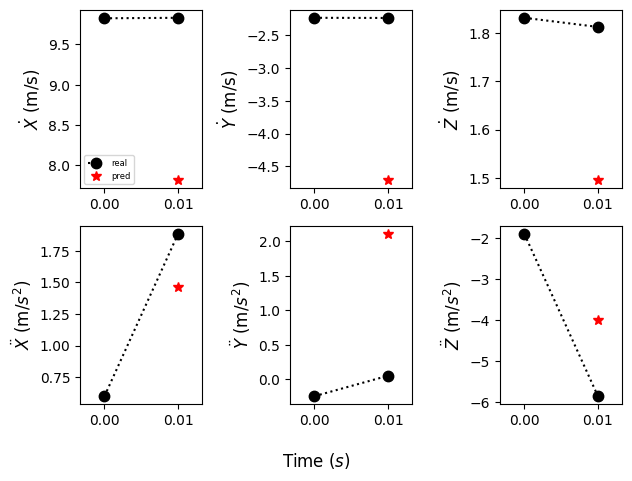

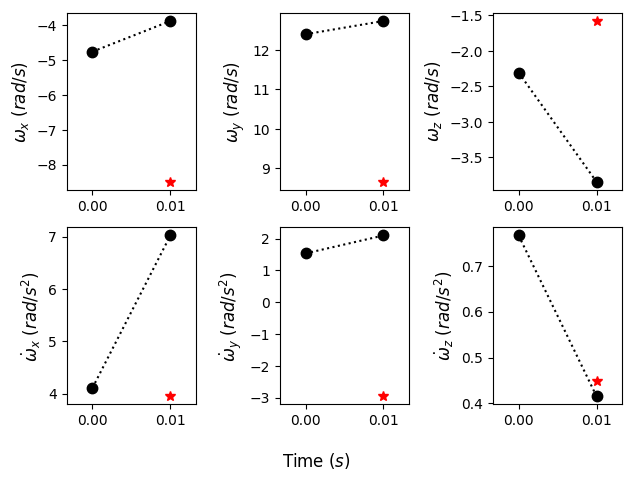

Current Batch Train Loss: 170.18247985839844

Current Batch Train Loss: 171.9999542236328

Current Batch Train Loss: 170.89837646484375

Current Batch Train Loss: 172.86959838867188

Current Batch Train Loss: 171.99951171875

Current Batch Train Loss: 174.43128967285156

Current Batch Train Loss: 173.1449432373047

Current Batch Train Loss: 168.25196838378906

Current Batch Train Loss: 170.81829833984375

Current Batch Train Loss: 170.16136169433594

Current Batch Train Loss: 172.68756103515625

Current Batch Train Loss: 171.93362426757812

Current Batch Train Loss: 166.52734375

Current Batch Train Loss: 176.33932495117188

Current Batch Train Loss: 171.24209594726562

Current Batch Train Loss: 171.32437133789062

Current Batch Train Loss: 169.67025756835938

Current Batch Train Loss: 176.16748046875

Current Batch Train Loss: 173.83547973632812

Current Batch Train Loss: 169.09133911132812

Current Batch Train Loss: 174.70872497558594

Current Batch Train Loss: 167.69712829589844

Cu

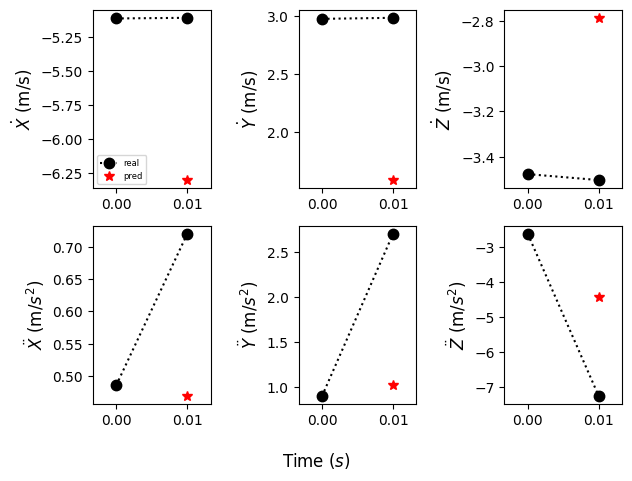

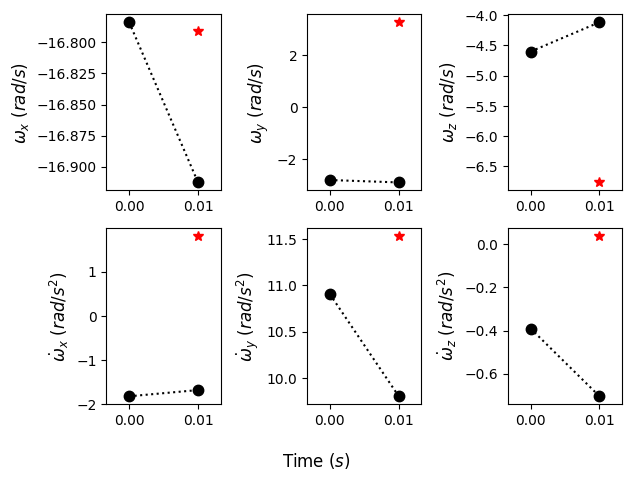

Current Batch Train Loss: 179.2545623779297

Current Batch Train Loss: 165.255859375

Current Batch Train Loss: 166.6973419189453

Current Batch Train Loss: 166.58802795410156

Current Batch Train Loss: 170.8610076904297

Current Batch Train Loss: 168.80799865722656

Current Batch Train Loss: 166.79428100585938

Current Batch Train Loss: 165.48907470703125

Current Batch Train Loss: 168.04501342773438

Current Batch Train Loss: 173.28919982910156

Current Batch Train Loss: 164.92872619628906

Current Batch Train Loss: 168.69039916992188

Current Batch Train Loss: 168.11305236816406

Current Batch Train Loss: 167.91470336914062

Current Batch Train Loss: 170.5662078857422

Current Batch Train Loss: 170.00050354003906

Current Batch Train Loss: 168.07122802734375

Current Batch Train Loss: 169.14315795898438

Current Batch Train Loss: 163.51869201660156

Current Batch Train Loss: 169.2237091064453

Current Batch Train Loss: 165.0760955810547

Current Batch Train Loss: 167.2045135498047



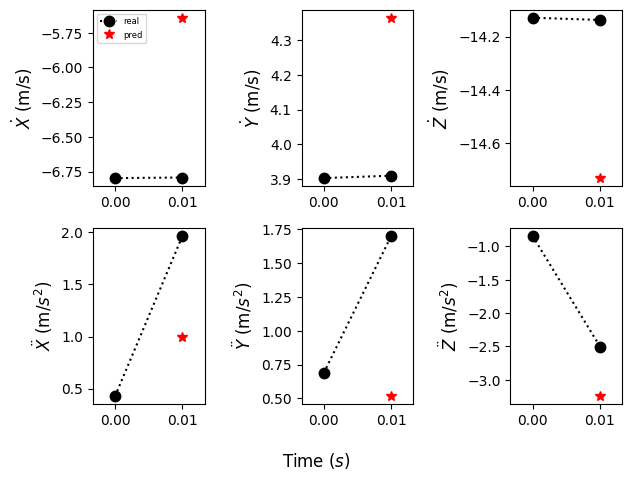

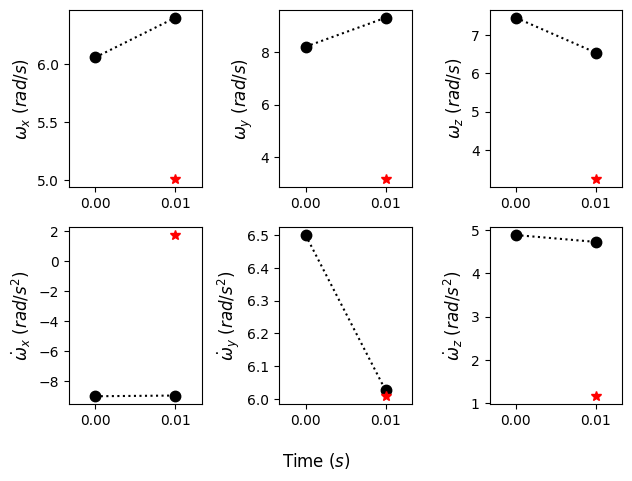

Current Batch Train Loss: 166.57215881347656

Current Batch Train Loss: 164.6282196044922

Current Batch Train Loss: 167.151123046875

Current Batch Train Loss: 167.71006774902344

Current Batch Train Loss: 170.0746612548828

Current Batch Train Loss: 163.45916748046875

Current Batch Train Loss: 167.2563934326172

Current Batch Train Loss: 166.59149169921875

Current Batch Train Loss: 163.1876678466797

Current Batch Train Loss: 163.9725341796875

Current Batch Train Loss: 165.67306518554688

Current Batch Train Loss: 172.45425415039062

Current Batch Train Loss: 162.6844024658203

Current Batch Train Loss: 160.64312744140625

Current Batch Train Loss: 164.1965789794922

Current Batch Train Loss: 168.4425048828125

Current Batch Train Loss: 165.09921264648438

Current Batch Train Loss: 167.64730834960938

Current Batch Train Loss: 162.987548828125

Current Batch Train Loss: 166.53692626953125

Current Batch Train Loss: 163.91456604003906

Current Batch Train Loss: 162.39492797851562



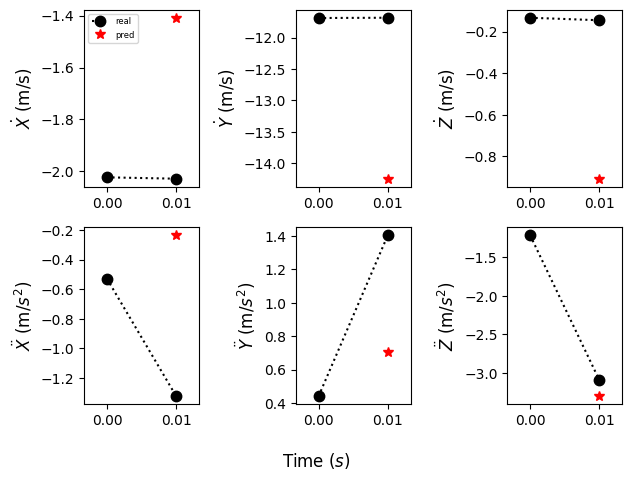

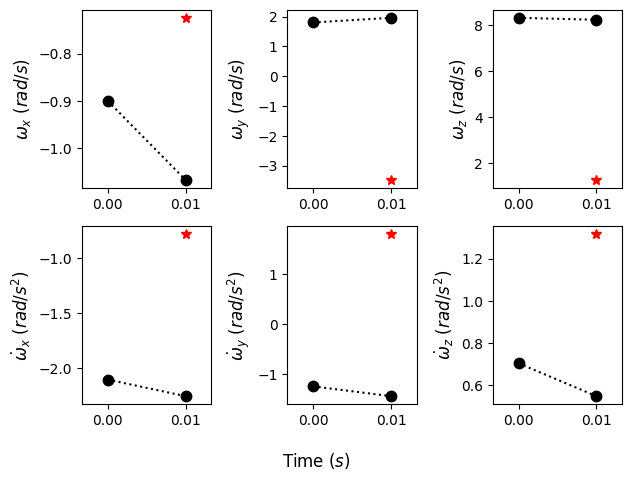

Current Batch Train Loss: 163.95021057128906

Current Batch Train Loss: 167.6852569580078

Current Batch Train Loss: 166.3777618408203

Current Batch Train Loss: 167.40579223632812

Current Batch Train Loss: 163.0723114013672

Current Batch Train Loss: 162.92860412597656

Current Batch Train Loss: 164.59693908691406

Current Batch Train Loss: 164.48890686035156

Current Batch Train Loss: 163.98947143554688

Current Batch Train Loss: 165.43983459472656

Current Batch Train Loss: 161.9219970703125

Current Batch Train Loss: 161.7529296875

Current Batch Train Loss: 161.8596649169922

Current Batch Train Loss: 165.1332244873047

Current Batch Train Loss: 162.2745361328125

Current Batch Train Loss: 161.9134979248047

Current Batch Train Loss: 162.0126495361328

Current Batch Train Loss: 164.95022583007812

Current Batch Train Loss: 166.85031127929688

Current Batch Train Loss: 165.91920471191406

Current Batch Train Loss: 164.8365936279297

Current Batch Train Loss: 161.73648071289062

Cu

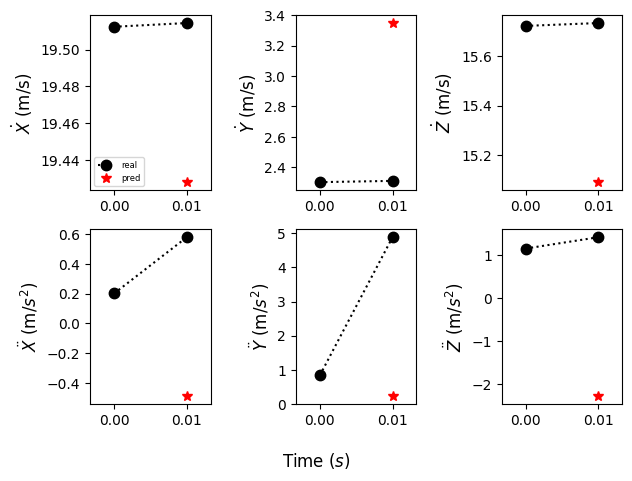

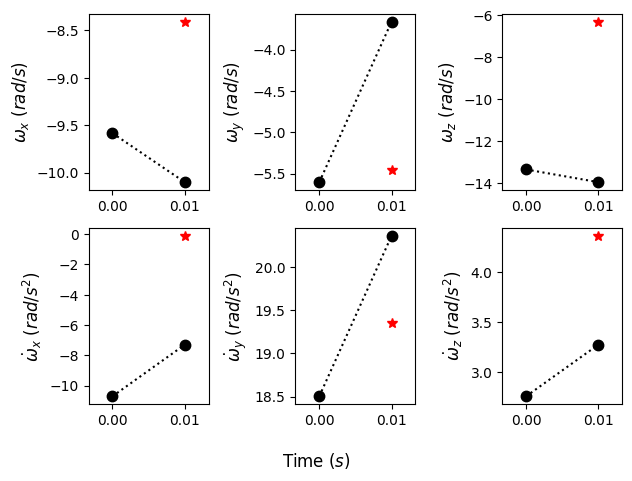

Current Batch Train Loss: 163.4943389892578

Current Batch Train Loss: 162.50173950195312

Current Batch Train Loss: 159.88827514648438

Current Batch Train Loss: 162.11090087890625

Current Batch Train Loss: 161.2897491455078

Current Batch Train Loss: 160.86878967285156

Current Batch Train Loss: 165.6253662109375

Current Batch Train Loss: 162.49778747558594

Current Batch Train Loss: 163.39443969726562

Current Batch Train Loss: 161.86265563964844

Current Batch Train Loss: 167.0509033203125

Current Batch Train Loss: 161.7454376220703

Current Batch Train Loss: 160.3292694091797

Current Batch Train Loss: 162.6365509033203

Current Batch Train Loss: 159.84718322753906

Current Batch Train Loss: 161.52743530273438

Current Batch Train Loss: 163.71603393554688

Current Batch Train Loss: 160.27627563476562

Current Batch Train Loss: 163.00267028808594

Current Batch Train Loss: 162.95384216308594

Current Batch Train Loss: 161.6645050048828

Current Batch Train Loss: 158.395629882812

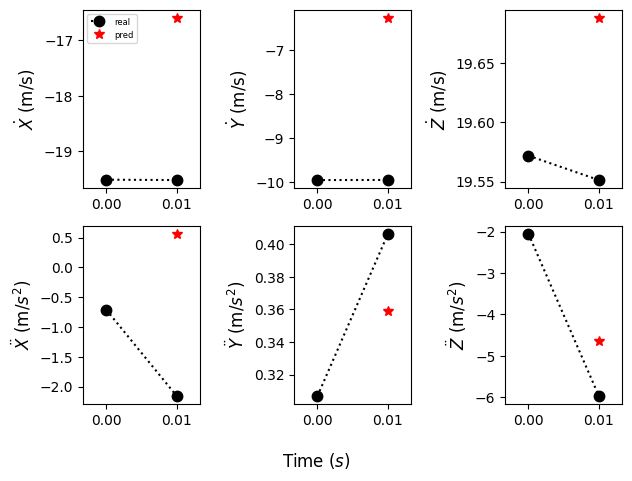

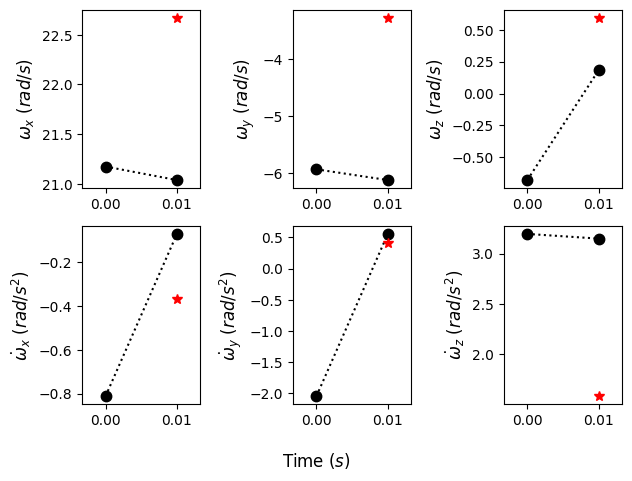

Current Batch Train Loss: 164.2518310546875

Current Batch Train Loss: 159.67984008789062

Current Batch Train Loss: 157.89437866210938

Current Batch Train Loss: 158.5124053955078

Current Batch Train Loss: 163.07870483398438

Current Batch Train Loss: 158.08937072753906

Current Batch Train Loss: 157.73968505859375

Current Batch Train Loss: 162.3165740966797

Current Batch Train Loss: 162.90557861328125

Current Batch Train Loss: 159.46778869628906

Current Batch Train Loss: 159.05169677734375

Current Batch Train Loss: 158.5999755859375

Current Batch Train Loss: 159.11911010742188

Current Batch Train Loss: 156.078125

Current Batch Train Loss: 160.58779907226562

Current Batch Train Loss: 158.470703125

Current Batch Train Loss: 159.91030883789062

Current Batch Train Loss: 158.97293090820312

Current Batch Train Loss: 163.16270446777344

Current Batch Train Loss: 162.37887573242188

Current Batch Train Loss: 161.10882568359375

Current Batch Train Loss: 156.58668518066406

Curre

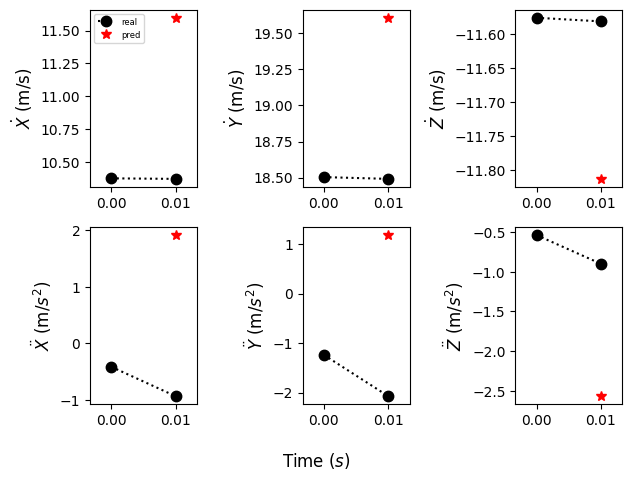

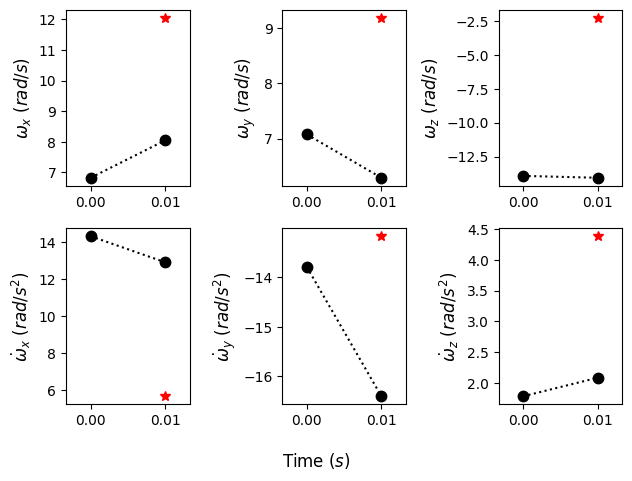

Current Batch Train Loss: 159.82888793945312

Current Batch Train Loss: 157.46664428710938

Current Batch Train Loss: 158.4866485595703

Current Batch Train Loss: 158.5690460205078

Current Batch Train Loss: 155.3419189453125

Current Batch Train Loss: 156.9655303955078

Current Batch Train Loss: 157.1307830810547

Current Batch Train Loss: 161.8638153076172

Current Batch Train Loss: 155.51034545898438

Current Batch Train Loss: 152.35430908203125

Current Batch Train Loss: 158.9905548095703

Current Batch Train Loss: 165.00064086914062

Current Batch Train Loss: 157.6723175048828

Current Batch Train Loss: 158.80934143066406

Current Batch Train Loss: 157.15365600585938

Current Batch Train Loss: 157.6533203125

Current Batch Train Loss: 153.3644256591797

Current Batch Train Loss: 154.9316864013672

Current Batch Train Loss: 156.44224548339844

Current Batch Train Loss: 154.640625

Current Batch Train Loss: 152.8740692138672

Current Batch Train Loss: 157.28724670410156

Current Bat

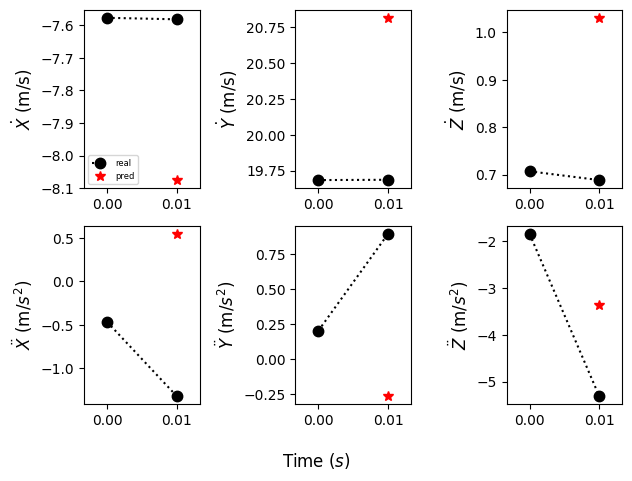

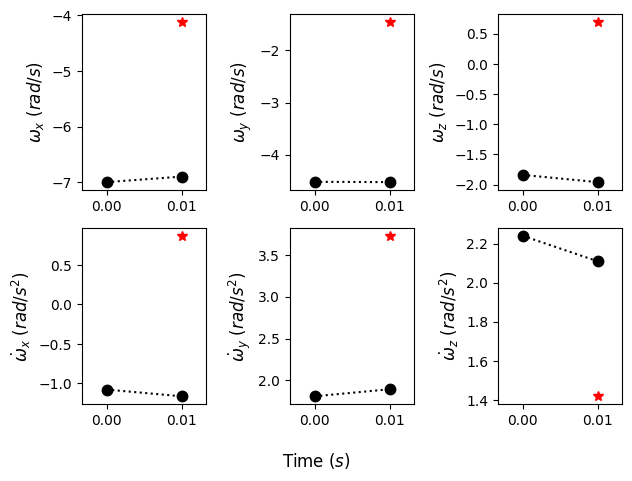

Current Batch Train Loss: 155.5215301513672

Current Batch Train Loss: 157.3090362548828

Current Batch Train Loss: 155.52342224121094

Current Batch Train Loss: 153.7586212158203

Current Batch Train Loss: 156.1786346435547

Current Batch Train Loss: 154.7822265625

Current Batch Train Loss: 150.1894989013672

Current Batch Train Loss: 156.17494201660156

Current Batch Train Loss: 155.14622497558594

Current Batch Train Loss: 150.0839385986328

Current Batch Train Loss: 152.67555236816406

Current Batch Train Loss: 148.20094299316406

Current Batch Train Loss: 150.86830139160156

Current Batch Train Loss: 152.6713104248047

Current Batch Train Loss: 152.65365600585938

Current Batch Train Loss: 158.7393035888672

Current Batch Train Loss: 150.3829345703125

Current Batch Train Loss: 153.92076110839844

Current Batch Train Loss: 151.3576202392578

Current Batch Train Loss: 151.25823974609375

Current Batch Train Loss: 151.80555725097656

Current Batch Train Loss: 148.6625213623047

Cur

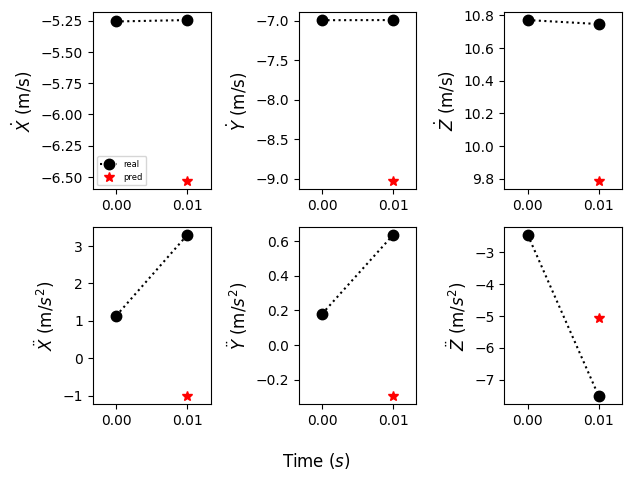

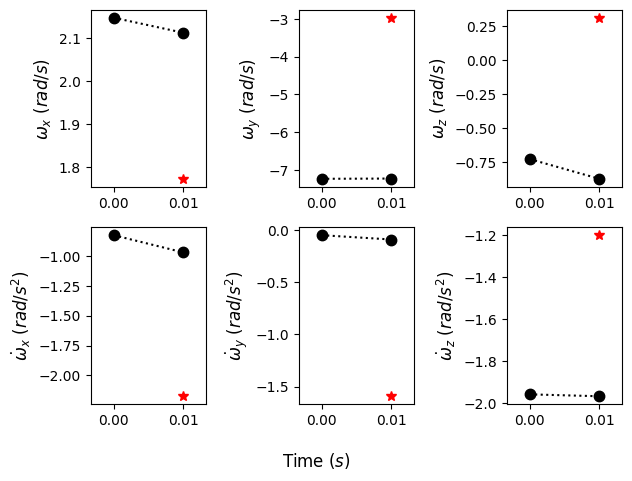

Current Batch Train Loss: 149.61512756347656

Current Batch Train Loss: 152.9677276611328

Current Batch Train Loss: 157.62245178222656

Current Batch Train Loss: 143.71533203125

Current Batch Train Loss: 144.35562133789062

Current Batch Train Loss: 151.1765899658203

Current Batch Train Loss: 146.92330932617188

Current Batch Train Loss: 149.23390197753906

Current Batch Train Loss: 145.7247314453125

Current Batch Train Loss: 146.6439666748047

Current Batch Train Loss: 147.4911651611328

Current Batch Train Loss: 148.30039978027344

Current Batch Train Loss: 147.81777954101562

Current Batch Train Loss: 146.3463134765625

Current Batch Train Loss: 152.275390625

Current Batch Train Loss: 145.42886352539062

Current Batch Train Loss: 148.7599639892578

Current Batch Train Loss: 146.89439392089844

Current Batch Train Loss: 144.60935974121094

Current Batch Train Loss: 146.79531860351562

Current Batch Train Loss: 142.80221557617188

Current Batch Train Loss: 143.00955200195312

Cur

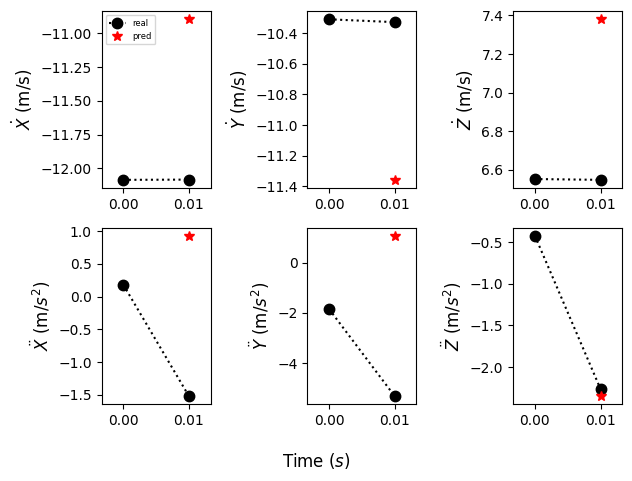

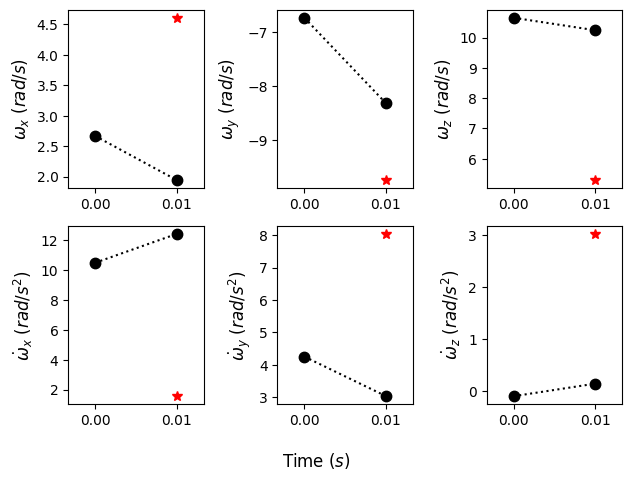

Current Batch Train Loss: 140.7571258544922

Current Batch Train Loss: 142.3521270751953

Current Batch Train Loss: 148.2860107421875

Current Batch Train Loss: 141.31150817871094

Current Batch Train Loss: 143.2173614501953

Current Batch Train Loss: 143.59658813476562

Current Batch Train Loss: 145.6356201171875

Current Batch Train Loss: 144.9610137939453

Current Batch Train Loss: 139.666259765625

Current Batch Train Loss: 140.73675537109375

Current Batch Train Loss: 142.22930908203125

Current Batch Train Loss: 141.93960571289062

Current Batch Train Loss: 142.71461486816406

Current Batch Train Loss: 142.18246459960938

Current Batch Train Loss: 141.0903778076172

Current Batch Train Loss: 155.73873901367188

Current Batch Train Loss: 140.4065704345703

Current Batch Train Loss: 139.3184814453125

Current Batch Train Loss: 139.9501953125

Current Batch Train Loss: 136.0013885498047

Current Batch Train Loss: 143.61424255371094

Current Batch Train Loss: 143.76498413085938

Curr

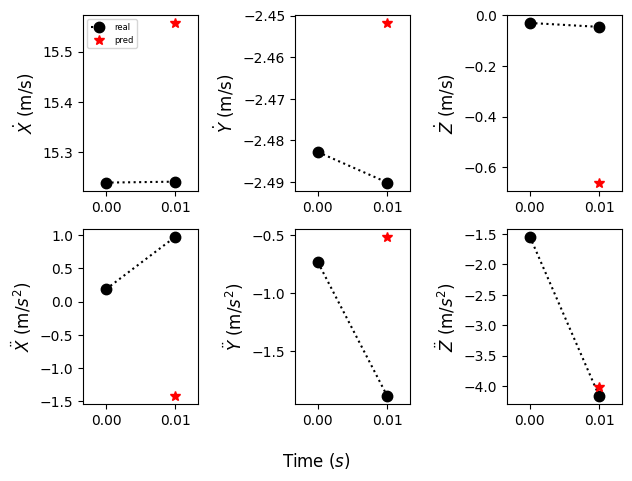

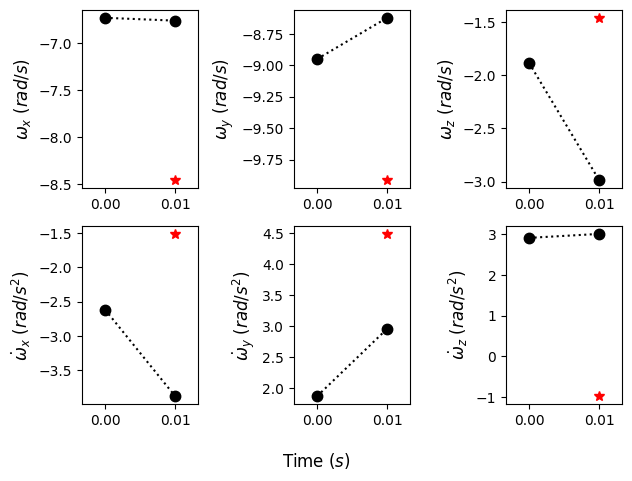

Current Batch Train Loss: 136.53579711914062

Current Batch Train Loss: 137.95346069335938

Current Batch Train Loss: 140.63909912109375

Current Batch Train Loss: 138.2400360107422

Current Batch Train Loss: 144.8822784423828

Current Batch Train Loss: 137.78097534179688

Current Batch Train Loss: 138.47555541992188

Current Batch Train Loss: 137.1770477294922

Current Batch Train Loss: 138.38919067382812

Current Batch Train Loss: 141.4052734375

Current Batch Train Loss: 135.83900451660156

Current Batch Train Loss: 136.5104217529297

Current Batch Train Loss: 136.78297424316406

Current Batch Train Loss: 138.18528747558594

Current Batch Train Loss: 136.5026397705078

Current Batch Train Loss: 136.15370178222656

Current Batch Train Loss: 139.49612426757812

Current Batch Train Loss: 144.3268280029297

Current Batch Train Loss: 132.79856872558594

Current Batch Train Loss: 141.27667236328125

Current Batch Train Loss: 132.00035095214844

Current Batch Train Loss: 138.11085510253906

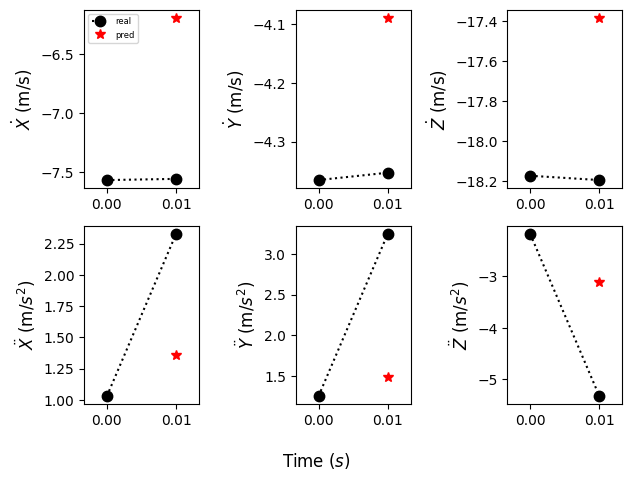

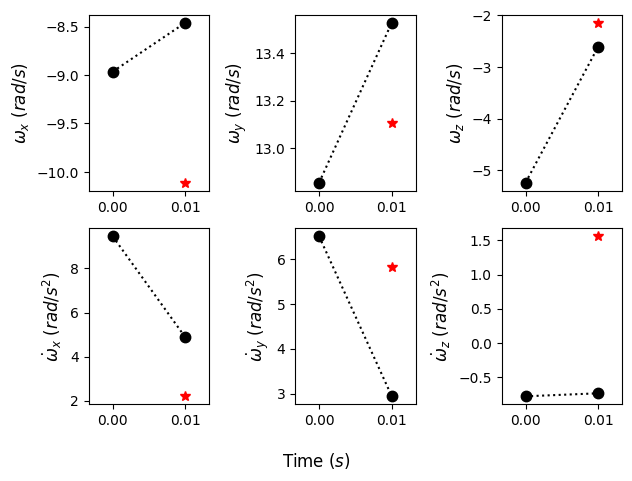

Current Batch Train Loss: 135.65956115722656

Current Batch Train Loss: 133.6248321533203

Current Batch Train Loss: 146.4679718017578

Current Batch Train Loss: 143.46600341796875

Current Batch Train Loss: 138.79257202148438

Current Batch Train Loss: 136.1368408203125

Current Batch Train Loss: 136.45338439941406

Current Batch Train Loss: 138.54852294921875

Current Batch Train Loss: 135.84945678710938

Current Batch Train Loss: 136.94961547851562

Current Batch Train Loss: 134.00672912597656

Current Batch Train Loss: 134.85137939453125

Current Batch Train Loss: 135.40333557128906

Current Batch Train Loss: 131.7123565673828

Current Batch Train Loss: 134.24481201171875

Current Batch Train Loss: 133.03955078125

Current Batch Train Loss: 132.5189666748047

Current Batch Train Loss: 135.07212829589844

Current Batch Train Loss: 136.95306396484375

Current Batch Train Loss: 131.806640625

Current Batch Train Loss: 132.68301391601562

Current Batch Train Loss: 132.93199157714844

C

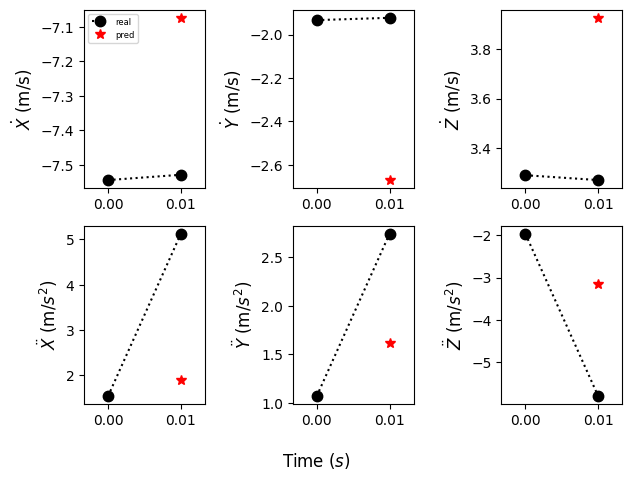

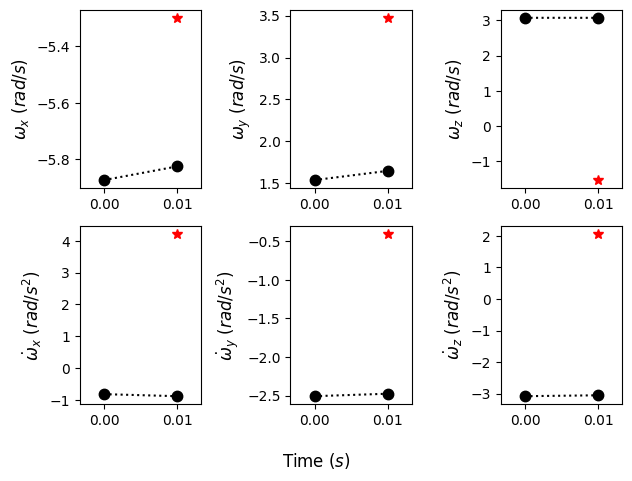

Current Batch Train Loss: 136.3948974609375

Current Batch Train Loss: 133.60964965820312

Current Batch Train Loss: 133.41615295410156

Current Batch Train Loss: 135.73196411132812

Current Batch Train Loss: 130.91139221191406

Current Batch Train Loss: 135.65594482421875

Current Batch Train Loss: 134.93052673339844

Current Batch Train Loss: 133.811767578125

Current Batch Train Loss: 133.3267059326172

Current Batch Train Loss: 136.2989044189453

Current Batch Train Loss: 134.26954650878906

Current Batch Train Loss: 133.64146423339844

Current Batch Train Loss: 130.10247802734375

Current Batch Train Loss: 132.5104217529297

Current Batch Train Loss: 131.2926025390625

Current Batch Train Loss: 129.803466796875

Current Batch Train Loss: 137.00991821289062

Current Batch Train Loss: 130.75982666015625

Current Batch Train Loss: 136.4692840576172

Current Batch Train Loss: 132.3710174560547

Current Batch Train Loss: 130.0525665283203

Current Batch Train Loss: 135.6429443359375

C

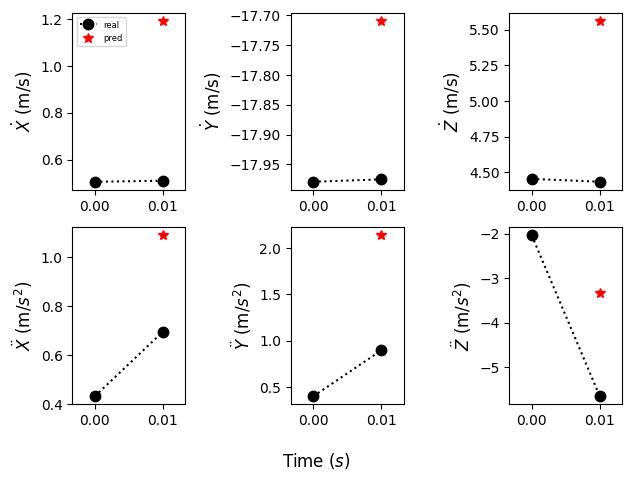

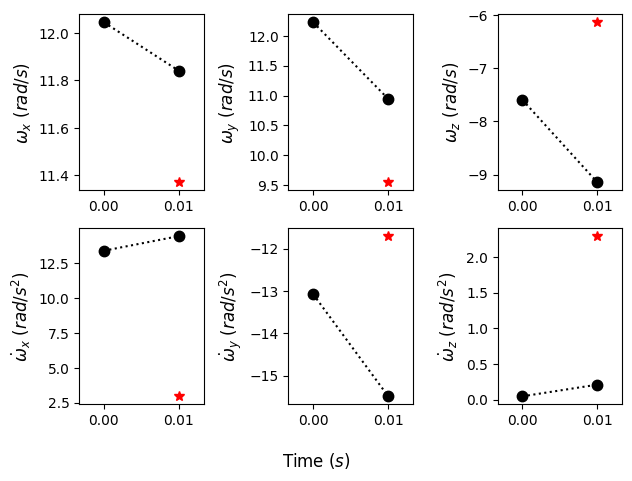

Current Batch Train Loss: 131.08621215820312

Current Batch Train Loss: 136.0086669921875

Current Batch Train Loss: 131.57554626464844

Current Batch Train Loss: 132.64744567871094

Current Batch Train Loss: 132.32444763183594

Current Batch Train Loss: 134.8987274169922

Current Batch Train Loss: 134.59776306152344

Current Batch Train Loss: 130.3191375732422

Current Batch Train Loss: 131.124755859375

Current Batch Train Loss: 128.99205017089844

Current Batch Train Loss: 136.54354858398438

Current Batch Train Loss: 132.49549865722656

Current Batch Train Loss: 131.43753051757812

Current Batch Train Loss: 130.75927734375

Current Batch Train Loss: 130.5919189453125

Current Batch Train Loss: 130.38333129882812

Current Batch Train Loss: 130.4081268310547

Current Batch Train Loss: 132.44834899902344

Current Batch Train Loss: 130.73593139648438

Current Batch Train Loss: 133.5420684814453

Current Batch Train Loss: 131.56161499023438

Current Batch Train Loss: 134.7908935546875



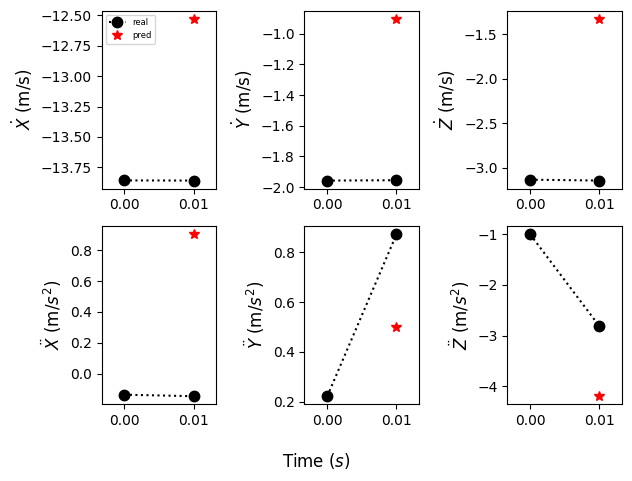

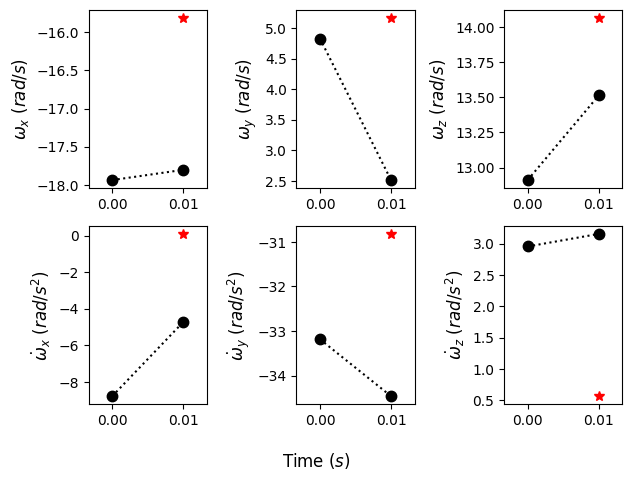

Current Batch Train Loss: 127.10579681396484

Current Batch Train Loss: 128.41531372070312

Current Batch Train Loss: 129.674560546875

Current Batch Train Loss: 129.6911163330078

Current Batch Train Loss: 132.5806427001953

Current Batch Train Loss: 134.27676391601562

Current Batch Train Loss: 129.02427673339844

Current Batch Train Loss: 130.52557373046875

Current Batch Train Loss: 134.57864379882812

Current Batch Train Loss: 128.78610229492188

Current Batch Train Loss: 128.35630798339844

Current Batch Train Loss: 129.63572692871094

Current Batch Train Loss: 127.22222900390625

Current Batch Train Loss: 129.42880249023438

Current Batch Train Loss: 133.20339965820312

Current Batch Train Loss: 136.7442169189453

Current Batch Train Loss: 136.00830078125

Current Batch Train Loss: 130.35813903808594

Current Batch Train Loss: 127.57250213623047

Current Batch Train Loss: 130.5066680908203

Current Batch Train Loss: 129.7609100341797

Current Batch Train Loss: 127.50672149658203

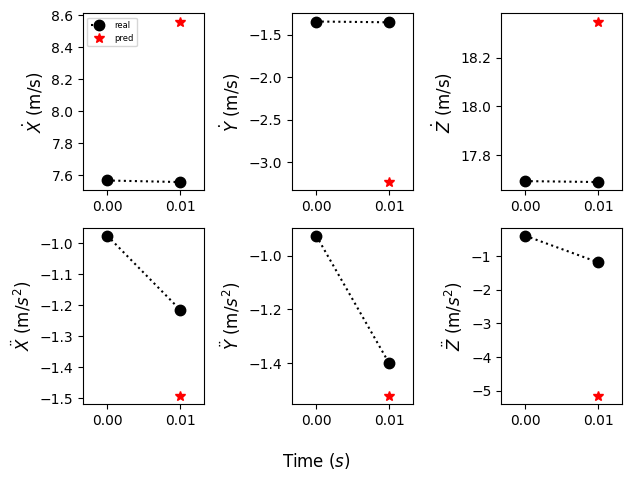

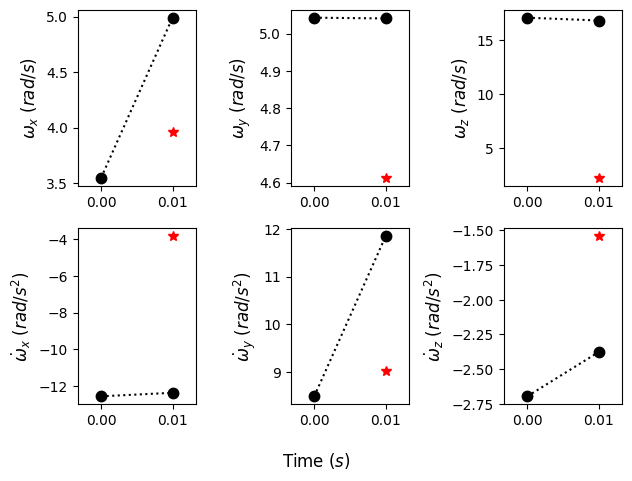

Current Batch Train Loss: 133.39584350585938

Current Batch Train Loss: 128.96914672851562

Current Batch Train Loss: 129.59237670898438

Current Batch Train Loss: 128.28500366210938

Current Batch Train Loss: 133.79612731933594

Current Batch Train Loss: 129.9635009765625

Current Batch Train Loss: 128.08502197265625

Current Batch Train Loss: 128.74517822265625

Current Batch Train Loss: 128.54530334472656

Current Batch Train Loss: 126.79145050048828

Current Batch Train Loss: 126.24911499023438

Current Batch Train Loss: 128.2498016357422

Current Batch Train Loss: 128.99334716796875

Current Batch Train Loss: 128.9769744873047

Current Batch Train Loss: 130.00160217285156

Current Batch Train Loss: 129.13795471191406

Current Batch Train Loss: 130.49179077148438

Current Batch Train Loss: 129.24911499023438

Current Batch Train Loss: 130.04986572265625

Current Batch Train Loss: 128.85215759277344

Current Batch Train Loss: 127.53178405761719

Current Batch Train Loss: 130.0846099

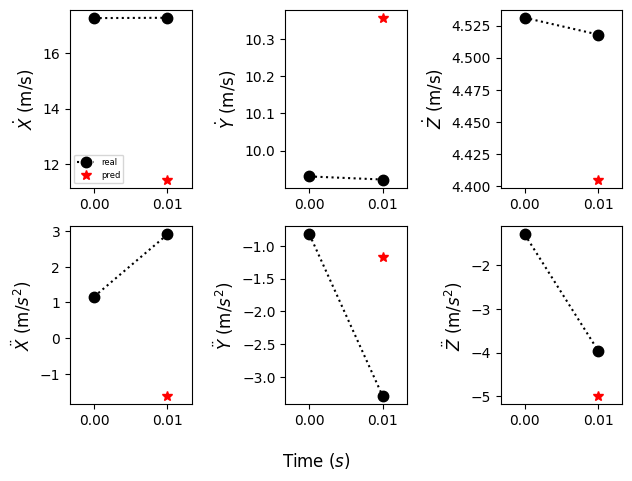

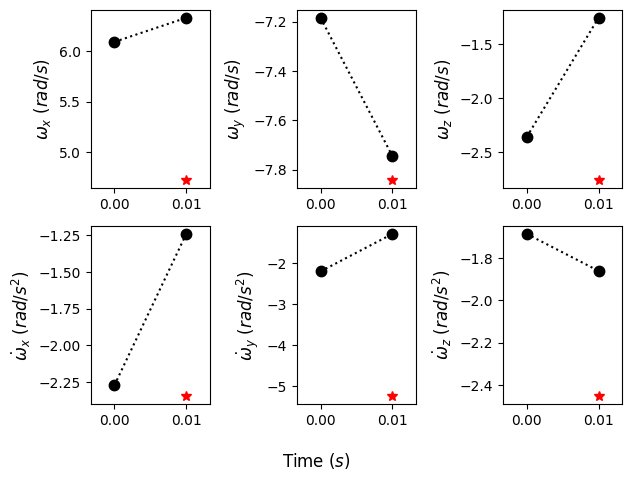

Current Batch Train Loss: 130.3622283935547

Current Batch Train Loss: 131.18955993652344

Current Batch Train Loss: 128.90478515625

Current Batch Train Loss: 128.56353759765625

Current Batch Train Loss: 129.5128631591797

Current Batch Train Loss: 131.75950622558594

Current Batch Train Loss: 126.87373352050781

Current Batch Train Loss: 127.96141052246094

Current Batch Train Loss: 131.52481079101562

Current Batch Train Loss: 127.79357147216797

Current Batch Train Loss: 128.21353149414062

Current Batch Train Loss: 126.83740234375

Current Batch Train Loss: 132.14395141601562

Current Batch Train Loss: 128.3469696044922

Current Batch Train Loss: 130.0404815673828

Current Batch Train Loss: 126.45296478271484

Current Batch Train Loss: 131.0597381591797

Current Batch Train Loss: 129.41049194335938

Current Batch Train Loss: 129.58816528320312

Current Batch Train Loss: 127.08748626708984

Current Batch Train Loss: 129.79513549804688

Current Batch Train Loss: 128.5319061279297



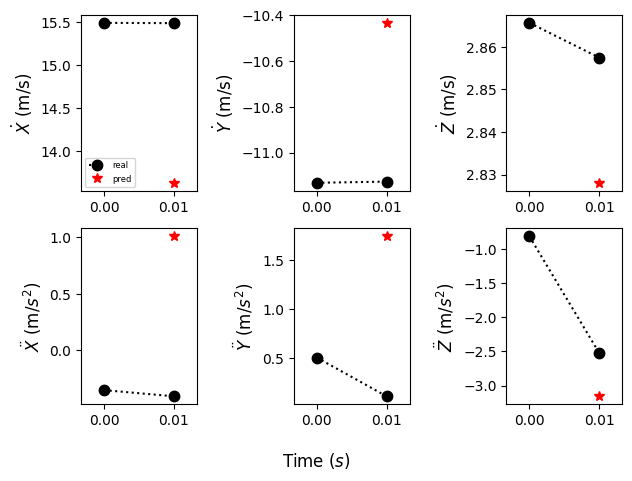

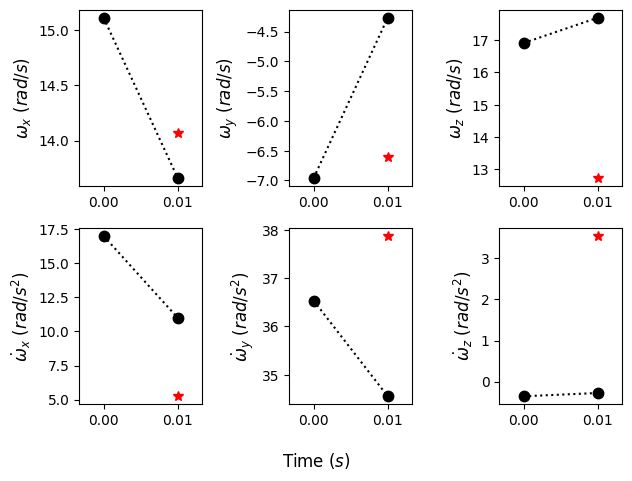

Current Batch Train Loss: 122.20330810546875

Current Batch Train Loss: 128.08135986328125

Current Batch Train Loss: 128.04702758789062

Current Batch Train Loss: 128.36727905273438

Current Batch Train Loss: 126.45880889892578

Current Batch Train Loss: 127.98312377929688

Current Batch Train Loss: 127.41764831542969

Current Batch Train Loss: 129.3335418701172

Current Batch Train Loss: 125.82205200195312

Current Batch Train Loss: 129.1248321533203

Current Batch Train Loss: 129.70709228515625

Current Batch Train Loss: 128.7342987060547

Current Batch Train Loss: 127.60364532470703

Current Batch Train Loss: 126.93495178222656

Current Batch Train Loss: 130.16561889648438

Current Batch Train Loss: 129.48214721679688

Current Batch Train Loss: 128.42649841308594

Current Batch Train Loss: 126.461181640625

Current Batch Train Loss: 129.09263610839844

Current Batch Train Loss: 127.21344757080078

Current Batch Train Loss: 126.51461029052734

Current Batch Train Loss: 126.773849487

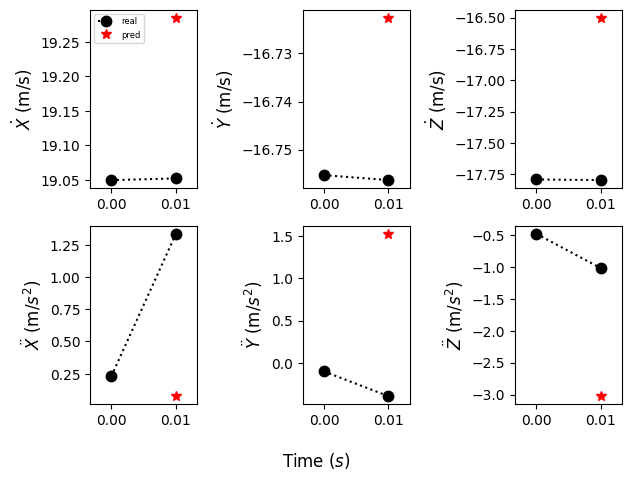

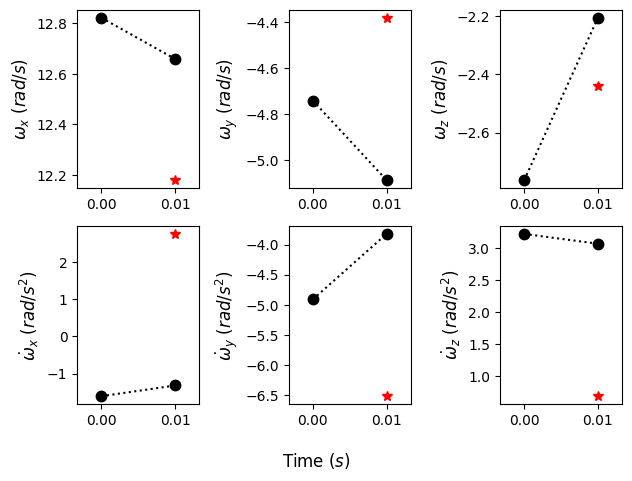

Current Batch Train Loss: 125.82339477539062

Current Batch Train Loss: 128.075439453125

Current Batch Train Loss: 128.94515991210938

Current Batch Train Loss: 128.38792419433594

Current Batch Train Loss: 126.36534881591797

Current Batch Train Loss: 127.14330291748047

Current Batch Train Loss: 125.57317352294922

Current Batch Train Loss: 126.23702239990234

Current Batch Train Loss: 128.01632690429688

Current Batch Train Loss: 130.6176300048828

Current Batch Train Loss: 124.06797790527344

Current Batch Train Loss: 124.42100524902344

Current Batch Train Loss: 127.4181137084961

Current Batch Train Loss: 127.57041931152344

Current Batch Train Loss: 129.052734375

Current Batch Train Loss: 127.3336181640625

Current Batch Train Loss: 123.44688415527344

Current Batch Train Loss: 124.5605239868164

Current Batch Train Loss: 127.01557922363281

Current Batch Train Loss: 126.00115966796875

Current Batch Train Loss: 128.28993225097656

Current Batch Train Loss: 126.33059692382812


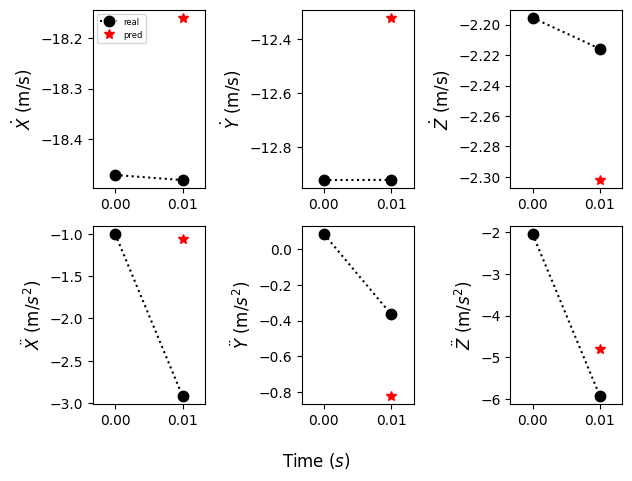

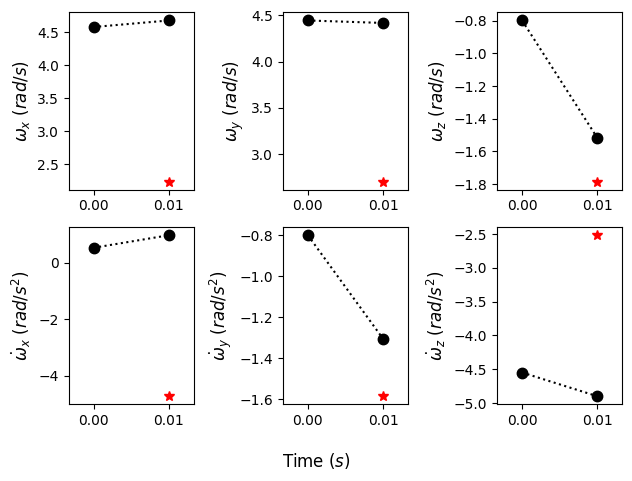

Current Batch Train Loss: 124.48594665527344

Current Batch Train Loss: 127.21546936035156

Current Batch Train Loss: 126.31011962890625

Current Batch Train Loss: 128.84014892578125

Current Batch Train Loss: 126.41971588134766

Current Batch Train Loss: 130.72552490234375

Current Batch Train Loss: 128.29661560058594

Current Batch Train Loss: 125.0289535522461

Current Batch Train Loss: 126.8856430053711

Current Batch Train Loss: 125.35763549804688

Current Batch Train Loss: 124.36273193359375

Current Batch Train Loss: 129.47373962402344

Current Batch Train Loss: 123.51383209228516

Current Batch Train Loss: 126.37638854980469

Current Batch Train Loss: 126.54741668701172

Current Batch Train Loss: 123.27462005615234

Current Batch Train Loss: 124.11658477783203

Current Batch Train Loss: 129.45751953125

Current Batch Train Loss: 125.48394012451172



KeyboardInterrupt: 

In [47]:
# Initializing PINN model
model = LSTM_PINN(
    input_dim=29,
    output_dim=12,
    num_lstm_layers=2,
    hidden_dim=256
)

#model = torch.load('vel+accel-no-disturbance-no-noise-200epochs-PINN-pt2.pt')

# Initializing model's loss function and optimizer
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=2e-5, amsgrad=True)

# Initializing training + validation loss tracker
train_loss_array = np.array([])
train_iter_array = np.array([])
val_loss_array = np.array([])
val_epoch_array = np.linspace(0, NUM_EPOCHS, NUM_EPOCHS+1)
val_AAE_array = np.array([])

# Initializing training loop
i = 0
for epoch in range(NUM_EPOCHS+1):
  
  if epoch % PLOT_AFTER == 0:

    with torch.no_grad():
      
      # Sampling random validation batch
      idx = random.randint(0, test_dataset.shape[0]-BATCH_SIZE)
      input = torch.concat([test_dataset[idx:idx+BATCH_SIZE,:,:17], test_dataset[idx:idx+BATCH_SIZE,:,23:]], dim=-1)
      #batch_force_and_moments = test_forces_and_moments[idx:idx+BATCH_SIZE,-1,:]
      next_state_vecs = test_dataset[idx:idx+BATCH_SIZE,-1,23:]
      
      prev_unnorm_states = test_dataset_unnorm[idx:idx+BATCH_SIZE,-1,:12]
      add_unnorm_inputs = test_dataset_unnorm[idx:idx+BATCH_SIZE,-1,13:23]
      next_unnorm_states = test_dataset_unnorm[idx:idx+BATCH_SIZE,-1,23:]
      input_unnorm = torch.concat([prev_unnorm_states, add_unnorm_inputs], dim=-1)
      dt_array = test_dataset_unnorm[idx:idx+BATCH_SIZE,-1,12]

      # Collecting batch predicted testing outputs
      pred_state_vecs = model(input)
      
      # Collecting loss from prediction
      loss_test = mse_loss(pred_state_vecs, next_state_vecs) + compute_batch_residuals(input, input_unnorm, dt_array)
      
      # Collecting error info from comparing to ground-truth dynamical data
      pred_state_vecs = db.minmax_unnorm(pred_state_vecs)
      AE_array = compute_AE(next_unnorm_states.detach().numpy(), pred_state_vecs.detach().numpy())
      test_batch_AAE = np.mean(AE_array)
      test_batch_AAE_std = np.std(AE_array)
      
      # Recording performance after every 'PLOT_AFTER' iterations
      print(f"Epoch: {epoch}, Batch Testing Loss: {loss_test}, Batch AAE: {test_batch_AAE} w/ Std Dev: {test_batch_AAE_std}")
      
      # Plotting model prediction results
      plot_all_functions(pred_state_vecs, prev_unnorm_states, next_unnorm_states, dt_array)
      
      # Collecting validation loss history
      val_loss_array = np.concatenate([val_loss_array, np.array([loss_test.item()])], axis=0)
      val_AAE_array = np.concatenate([val_AAE_array, np.array([test_batch_AAE])], axis=0)


  # Executing per-batch training loop
  for batch in range(0, train_dataset.shape[0], BATCH_SIZE):
    # Parsing batch dataset
    input = torch.concat([train_dataset[batch:batch+BATCH_SIZE,:,:17], train_dataset[batch:batch+BATCH_SIZE,:,23:]], dim=-1)
    next_state_vecs = train_dataset[batch:batch+BATCH_SIZE,-1,23:]
    #batch_force_and_moments = train_forces_and_moments[batch:batch+BATCH_SIZE,-1,:]
    
    prev_unnorm_states = train_dataset_unnorm[batch:batch+BATCH_SIZE,-1,:12]
    add_unnorm_inputs = train_dataset_unnorm[batch:batch+BATCH_SIZE,-1,13:23]
    input_unnorm = torch.concat([prev_unnorm_states, add_unnorm_inputs], dim=-1)
    dt_array = train_dataset_unnorm[batch:batch+BATCH_SIZE,-1,12]

    # zero the parameter gradients for each batch
    optimizer.zero_grad()

    # Obtaining batch predictions via forward-prop
    pred_state_vecs = model(input)

    # Collecting loss from prediction
    loss_train = mse_loss(pred_state_vecs, next_state_vecs) + compute_batch_residuals(input, input_unnorm, dt_array)

    # back propogation + optimizer step
    loss_train.backward()
    optimizer.step()

    # Collecting training loss history after every 'COLLECT_LOSS_AFTER' iters
    if i % COLLECT_TRAINING_LOSS_AFTER == 1:
      print(f"Current Batch Train Loss: {loss_train.item()}\n")
      train_loss_array = np.concatenate([train_loss_array, np.array([loss_train.detach()])], axis=0)
      train_iter_array = np.concatenate([train_iter_array, np.array([i])], axis=0)
    i += 1
    
  train_dataset, train_dataset_unnorm = shuffle_data(train_dataset, train_dataset_unnorm)


In [23]:
train_dataset.shape

torch.Size([1500000, 2, 35])

In [48]:
torch.save(model, 'vel+accel-no-disturbance-no-noise-41-epochs-PINN.pt')

### Plotting Loss Histories

Text(0.5, 1.0, 'Training MSE + Residual Loss of Quadrotor Dynamics Predictor')

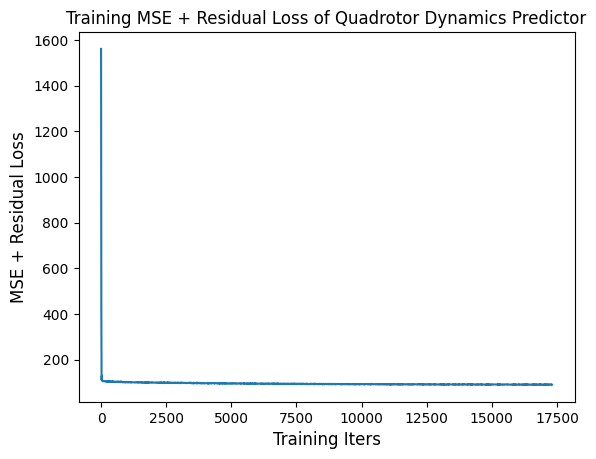

In [24]:
plt.plot(train_iter_array, train_loss_array)
plt.xlabel("Training Iters",fontsize=12), plt.ylabel("MSE + Residual Loss",fontsize=12) 
plt.title("Training MSE + Residual Loss of Quadrotor Dynamics Predictor")

Text(0.5, 1.0, 'Testing MSE + Residual Loss of Quadrotor Dynamics Predictor')

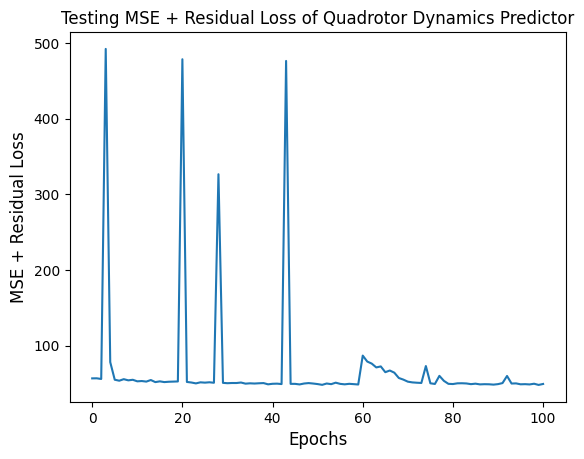

In [38]:
plt.plot(val_epoch_array, val_loss_array)
plt.xlabel("Epochs",fontsize=12), plt.ylabel("MSE + Residual Loss",fontsize=12) 
plt.title("Testing MSE + Residual Loss of Quadrotor Dynamics Predictor")

Text(0.5, 1.0, 'Testing MSE + Residual Loss of Quadrotor Dynamics Predictor')

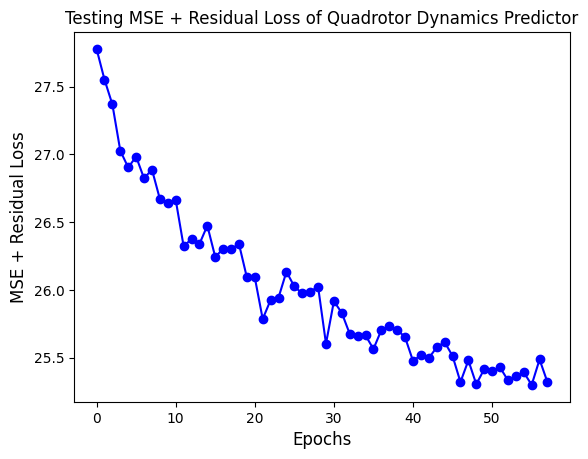

In [26]:
val_epoch_array = np.linspace(0,57,58)

plt.plot(val_epoch_array, val_AAE_array,'-bo')
plt.xlabel("Epochs",fontsize=12), plt.ylabel("MSE + Residual Loss",fontsize=12) 
plt.title("Testing MSE + Residual Loss of Quadrotor Dynamics Predictor")

In [40]:
np.save('AAE_array_PINN-LSTM_pt2', val_AAE_array)

### Evaluation: Trajectory Prediction

In [9]:
def compute_AE(state_vec, pred_state_vec):
  # Computing absolute prediction error (AE)
  state_diff = np.abs(state_vec - pred_state_vec)
  AE_array = np.sum(state_diff, axis=1)
  
  return AE_array

def scaled_compute_AE(state_vec, pred_state_vec):
  # Computing absolute prediction error (AE)
  scaled_state_diff = np.abs((state_vec - pred_state_vec) / state_vec) * 100
  scaled_AE_array = np.mean(scaled_state_diff)

  return scaled_AE_array

In [35]:
# Initializing models used in evaluation
model1 = torch.load('vel+accel-no-disturbance-no-noise-41-epochs-PINN.pt')
#model2 = torch.load('large-ss-medium-disturbance-medium-noise-model.pt')
#model3 = torch.load('large-ss-slow-vel-low-noise-model.pt')
model_list = [model1]
num_models = len(model_list)

# Initializing quadrotor sensor noise/disturbance parameters
'''
num_perturb_profiles = 1
perturb_params = np.zeros([num_perturb_profiles,6])
rotor_spike_profile = 100 * np.ones([num_perturb_profiles,]) #np.linspace(0,100,num_perturb_profiles)
gps_bias_profile = 1e-2 * np.ones([num_perturb_profiles,]) #np.linspace(0, 0.2, num_perturb_profiles)
gps_std_profile = 1e-1 * np.ones([num_perturb_profiles,]) #np.linspace(1e-5,0.6,num_perturb_profiles)
gyro_bias_profile = 1e-3 * np.ones([num_perturb_profiles,]) #np.linspace(0,0.5,num_perturb_profiles)
gyro_std_profile = 1e-5 * np.ones([num_perturb_profiles,]) #np.linspace(1e-5,1e-2,num_perturb_profiles)
disturb_quad_at_array = 100#np.linspace(1,100,num_perturb_profiles)

perturb_params[:,0] = rotor_spike_profile
perturb_params[:,1] = gps_bias_profile
perturb_params[:,2] = gps_std_profile
perturb_params[:,3] = gyro_bias_profile
perturb_params[:,4] = gyro_std_profile
perturb_params[:,5] = disturb_quad_at_array
'''

# Sampling random trajectory data 
sample_length = 100
test_db = Quadrotor_Dynamics_Generator()
#test_traj = test_db.generate_test_traj(seq_length=sample_length, gaussian_noise=True)
#test_traj = test_traj.unsqueeze(dim=0)
test_traj = torch.from_numpy(np.load('test_traj_GT.npy'))
test_traj = test_db.minmax_norm(test_traj)
test_AAE_array = np.zeros([num_models, sample_length])

# Defining test trajectory time array
time_array = np.zeros([sample_length,])

# Initializing array that will contain model predictions
eval_data = torch.zeros([num_models, 2, sample_length, 12])
eval_data[:,0:1,0:1,:] = torch.tile(torch.unsqueeze(test_traj[0:1,0:1,:12], dim=0), dims=[num_models, 1, 1, 1])


# Initializing plotting parameters
Xdot = np.zeros([num_models, sample_length])
Ydot = np.zeros([num_models, sample_length])
Zdot = np.zeros([num_models, sample_length])
ωx = np.zeros([num_models, sample_length])
ωy = np.zeros([num_models, sample_length])
ωz = np.zeros([num_models, sample_length])
Xdot_pred = np.zeros([num_models, sample_length])
Ydot_pred = np.zeros([num_models, sample_length])
Zdot_pred = np.zeros([num_models, sample_length])
ωx_pred = np.zeros([num_models, sample_length])
ωy_pred = np.zeros([num_models, sample_length])
ωz_pred = np.zeros([num_models, sample_length])

'''
Xdot_var = np.zeros([num_models, sample_length])
Ydot_var = np.zeros([num_models, sample_length])
Zdot_var = np.zeros([num_models, sample_length])
ωx_var = np.zeros([num_models, sample_length])
ωy_var = np.zeros([num_models, sample_length])
ωz_var = np.zeros([num_models, sample_length])
'''

# Looping through entire test trajectory
for nn in range(num_models):

  # Setting 'curr_model' to next model in list
  curr_model = model_list[nn]
  
  # Resetting time counter
  curr_time = 0

  for i in range(sample_length):

    curr_sample = test_traj[i:i+1,:,:]
    #curr_sample[:,0:1,8:] = next_context

    curr_dt = curr_sample[:,1:2,0]
    curr_time += curr_dt 
    time_array[i] = curr_time.detach().numpy()
    
    input = torch.concat([curr_sample[:,:,:17], curr_sample[:,:,26:]], dim=-1)
    #batch_force_and_moments = test_forces_and_moments[idx:idx+BATCH_SIZE,-1,:]
    next_state_vecs = curr_sample[:,-1,26:]

    # Collecting batch predicted testing outputs
    pred_state_vecs = curr_model(input)

    # Computing AE of current prediction
    pred_state_vecs = test_db.minmax_unnorm(pred_state_vecs)
    next_state_vecs = test_db.minmax_unnorm(next_state_vecs)
    AE_array = compute_AE(next_state_vecs.detach().numpy(), pred_state_vecs.detach().numpy())
    test_AAE_array[nn, i] = AE_array

    eval_data[nn,0:1,i,:] = next_state_vecs
    eval_data[nn,1:2,i,:] = pred_state_vecs

    #next_context = test_traj[i:i+1,1:2,8:] #pred_y[:,1:2,:]


  # Unnormalizing true states, their predictions, and associated variances for plotting
  Xdot[nn,:] = eval_data[nn,0,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0]) + minmax_data[8,0]).detach().numpy()
  Ydot[nn,:] = eval_data[nn,0,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0]) + minmax_data[9,0]).detach().numpy()
  Zdot[nn,:] = eval_data[nn,0,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0]) + minmax_data[10,0]).detach().numpy()

  Xdot_pred[nn,:] = eval_data[nn,1,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0]) + minmax_data[8,0]).detach().numpy()
  Ydot_pred[nn,:] = eval_data[nn,1,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0]) + minmax_data[9,0]).detach().numpy()
  Zdot_pred[nn,:] = eval_data[nn,1,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0]) + minmax_data[10,0]).detach().numpy()
  
  ωx[nn,:] = eval_data[nn,0,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy()
  ωy[nn,:] = eval_data[nn,0,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy()
  ωz[nn,:] = eval_data[nn,0,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy()
  
  ωx_pred[nn,:] = eval_data[nn,1,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy()
  ωy_pred[nn,:] = eval_data[nn,1,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy()
  ωz_pred[nn,:] = eval_data[nn,1,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy()
  
  '''
  Xdot_var[nn,:] = eval_data[nn,2,:,0].detach().numpy() #* ((minmax_data[8,1] - minmax_data[8,0])).detach().numpy())
  Ydot_var[nn,:] = eval_data[nn,2,:,1].detach().numpy() #* ((minmax_data[9,1] - minmax_data[9,0])).detach().numpy())
  Zdot_var[nn,:] = eval_data[nn,2,:,2].detach().numpy() #* ((minmax_data[10,1] - minmax_data[10,0])).detach().numpy())
  
  ωx_var[nn,:] = eval_data[nn,2,:,6].detach().numpy() #* ((minmax_data[14,1] - minmax_data[14,0]) + minmax_data[14,0]).detach().numpy())
  ωy_var[nn,:] = eval_data[nn,2,:,7].detach().numpy() #* ((minmax_data[15,1] - minmax_data[15,0]) + minmax_data[15,0]).detach().numpy())
  ωz_var[nn,:] = eval_data[nn,2,:,8].detach().numpy() #* ((minmax_data[16,1] - minmax_data[16,0]) + minmax_data[16,0]).detach().numpy())
  '''

model_AAE_array = np.mean(test_AAE_array, axis=1)
#print(f"AAE Results\nNo Noise/Disturbance: {model_AAE_array[2]}, Medium Noise/Disturbance: {model_AAE_array[1]}, High Noise/Disturbance: {model_AAE_array[0]}")

/tmp/ipykernel_14660/660490408.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_array[i] = curr_time.detach().numpy()
/tmp/ipykernel_14660/660490408.py:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_AAE_array[nn, i] = AE_array


In [36]:
model_AAE_array

array([23.45594269])

In [38]:
test_traj.shape

torch.Size([100, 2, 38])

In [33]:
# Defining length of plotted trajectories (ensure its <= to sample_length)
plt_idx = 120

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{X}$ (m/s)'))

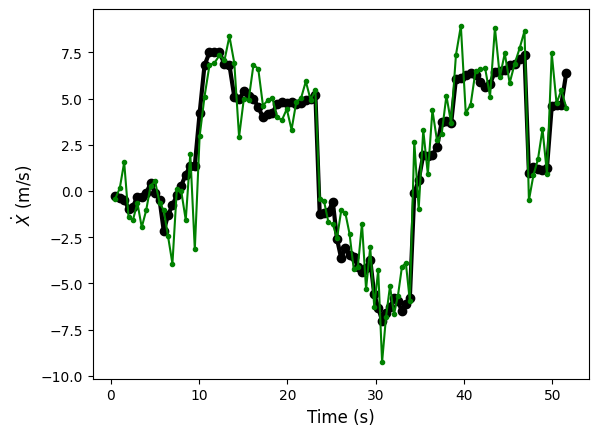

In [37]:
plt.plot(time_array[:plt_idx], Xdot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Xdot_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], X_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx] - Xdot_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], Xdot_pred[0,:plt_idx] + Xdot_var[0,:plt_idx], '--r')


plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{X}$ (m/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{Y}$ (m/s)'))

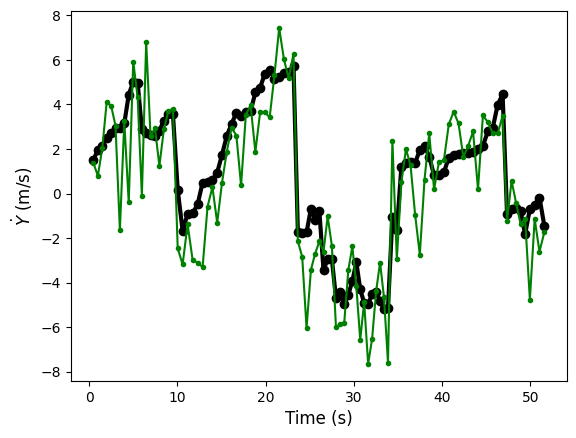

In [26]:
plt.plot(time_array[:plt_idx], Ydot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Y_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Y_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx] - Ydot_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], Ydot_pred[0,:plt_idx] + Ydot_var[0,:plt_idx], '--r')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{Y}$ (m/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{Z}$ (m/s)'))

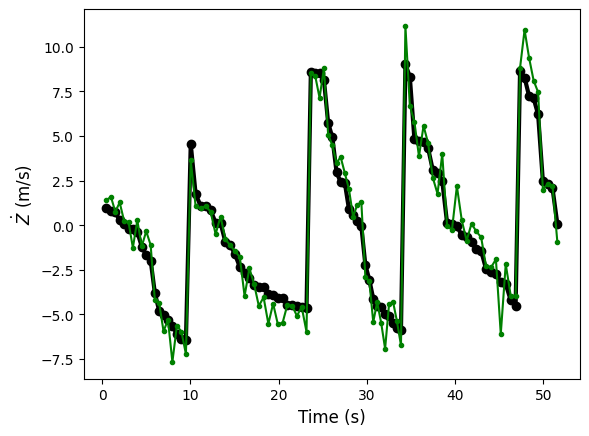

In [27]:
plt.plot(time_array[:plt_idx], Zdot[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx] - Zdot_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], Zdot_pred[0,:plt_idx] + Zdot_var[0,:plt_idx], '--r')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{Z}$ (m/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{\\omega}_{x}$ (rad/s)'))

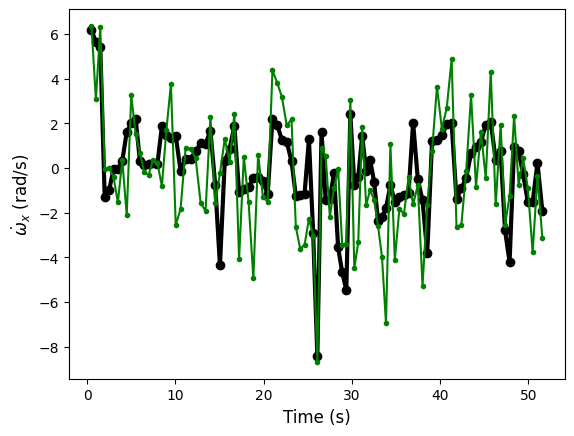

In [28]:
plt.plot(time_array[:plt_idx], ωx[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx] - ωx_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], ωx_pred[0,:plt_idx] + ωx_var[0,:plt_idx], '--r')

plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{\omega}_{x}$ (rad/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{\\omega}_{y}$ (rad/s)'))

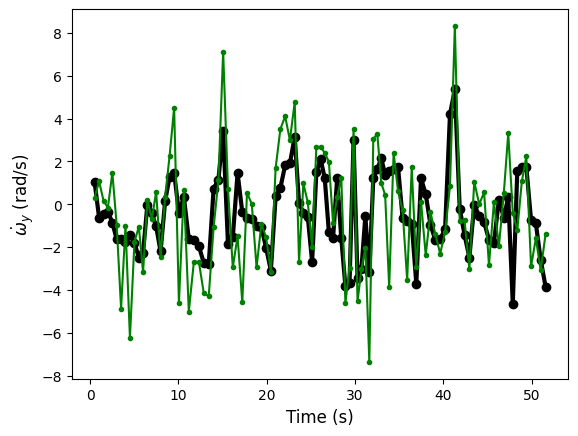

In [29]:
plt.plot(time_array[:plt_idx], ωy[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx] - ωy_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], ωy_pred[0,:plt_idx] + ωy_var[0,:plt_idx], '--r')

#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')
plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{\omega}_{y}$ (rad/s)", fontsize=12)

(Text(0.5, 0, 'Time (s)'), Text(0, 0.5, '$\\dot{\\omega}_{z}$ (rad/s)'))

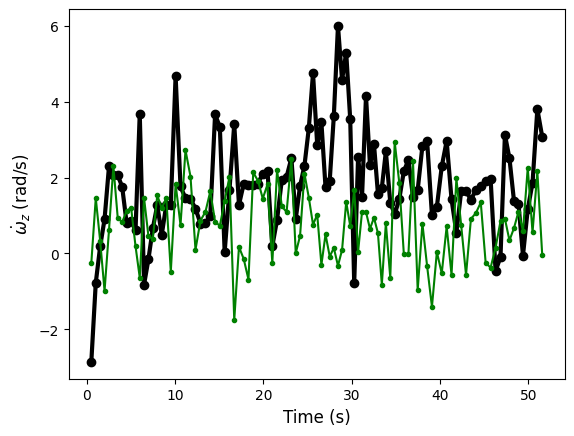

In [208]:
plt.plot(time_array[:plt_idx], ωz[0,:plt_idx], '-ko', linewidth=3)
plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx], '-go', markersize=3)
#plt.plot(time_array, Z_pred_PINN1, '-r')
#plt.plot(time_array[:plt_idx], Z_pred[2,:plt_idx], '-go')

#plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx] - ωz_var[0,:plt_idx], '--r')
#plt.plot(time_array[:plt_idx], ωz_pred[0,:plt_idx] + ωz_var[0,:plt_idx], '--r')


#plt.legend(['Ground-Truth','High-Noise/Peturb','Physics-Informed Model','Model Uncertainty Bounds'], loc='best')
plt.xlabel("Time (s)", fontsize=12), plt.ylabel(r"$\dot{\omega}_{z}$ (rad/s)", fontsize=12)

In [31]:
np.save('test_traj_xdot_PINN.npy', Xdot_pred)
np.save('test_traj_ydot_PINN.npy', Ydot_pred)
np.save('test_traj_zdot_PINN.npy', Zdot_pred)
np.save('test_traj_ωx_PINN.npy', ωx_pred)
np.save('test_traj_ωy_PINN.npy', ωy_pred)
np.save('test_traj_ωz_PINN.npy', ωz_pred)

In [27]:
np.save('mass_vary_results_PINN.npy', inertial_profile_AAE)

In [12]:
# Initializing model
model = torch.load('vel+accel-no-disturbance-no-noise-41-epochs-PINN.pt')

# Initializing quadrotor sensor noise/disturbance parameters
test_db = Quadrotor_Dynamics_Generator(normalize=True)
num_perturb_profiles = 100
perturb_params = torch.zeros([num_perturb_profiles,2])
rotor_spike_profile = torch.linspace(1, 100, num_perturb_profiles)
wind_vel_array = torch.linspace(0, 20, 100)
perturb_params[:,0] = rotor_spike_profile
perturb_params[:,1] = wind_vel_array

# Sampling random trajectory data 
sample_length = 10
num_trajs = 10
test_db = Quadrotor_Dynamics_Generator(normalize=False)

#test_traj = test_traj.unsqueeze(dim=0)
test_AAE_array = np.zeros([num_perturb_profiles, sample_length*num_trajs])

# Defining test trajectory time array
time_array = np.zeros([sample_length,])

# Looping through entire test trajectory
for profile in range(num_perturb_profiles):
    
    params = perturb_params[profile,:]
    
    count = 0
    for traj in range(num_trajs):
        
        # Sampling random trajectory data 
        test_traj = test_db.generate_test_traj(seq_length=sample_length, perturb_params=params, gaussian_noise=True)
        test_traj = test_db.minmax_norm(test_traj)
        
        # Resetting time counter
        curr_time = 0
        
        for i in range(sample_length):

            curr_sample = test_traj[i:i+1,:,:]
            #curr_sample[:,0:1,8:] = next_context

            curr_dt = curr_sample[:,1:2,0]
            curr_time += curr_dt 
            time_array[i] = curr_time.detach().numpy()
            
            input = torch.concat([curr_sample[:,:,:17], curr_sample[:,:,26:]], dim=-1)
            #batch_force_and_moments = test_forces_and_moments[idx:idx+BATCH_SIZE,-1,:]
            next_state_vecs = curr_sample[:,-1,26:]

            # Collecting batch predicted testing outputs
            pred_state_vecs = model(input)

            # Computing AE of current prediction
            pred_state_vecs = test_db.minmax_unnorm(pred_state_vecs)
            next_state_vecs = test_db.minmax_unnorm(next_state_vecs)
            AE_array = compute_AE(next_state_vecs.detach().numpy(), pred_state_vecs.detach().numpy())
            test_AAE_array[profile, count] = AE_array
            count += 1

/tmp/ipykernel_14660/545409123.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_array[i] = curr_time.detach().numpy()
/tmp/ipykernel_14660/545409123.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_AAE_array[profile, count] = AE_array


In [18]:
np.mean(test_AAE_array, axis=1)

array([24.96771687, 19.29336403, 20.59194443, 20.13733019, 20.88169466,
       19.70270718, 22.18102905, 19.6498899 , 19.35687217, 20.95952499,
       20.01689699, 23.22444441, 20.09797504, 21.88133121, 19.35260445,
       19.66232471, 20.93150286, 21.90964714, 23.82352728, 19.91407568,
       20.06953646, 22.65754993, 19.1165926 , 18.68196196, 22.8358917 ,
       21.97528473, 21.55693775, 23.57843913, 21.51871584, 19.44892712,
       22.48443092, 23.46587847, 20.64160122, 19.68312311, 22.03114843,
       19.08293728, 18.83327192, 23.92045597, 21.6616993 , 19.21231852,
       22.95284412, 24.06999081, 21.53357071, 21.94696242, 21.6224758 ,
       22.23593147, 21.13989756, 20.66586211, 19.89002623, 19.4950305 ,
       20.6381002 , 17.68680595, 19.24671344, 21.28422163, 17.56548307,
       18.98785053, 23.94692774, 18.62687065, 19.17167986, 22.2634387 ,
       20.5556263 , 22.6970446 , 22.01414192, 21.93199062, 25.17869169,
       20.51909443, 18.50768654, 19.51736746, 24.73894953, 19.86

In [32]:
curr_sample

tensor([[[  0.4669,   0.5430,   0.3910,   0.5744,   0.5291,   0.5011,   0.4863,
            0.5156,   0.4672,   0.5155,   0.5286,   0.4672,   0.1134,   0.2164,
            0.8997,   0.5009,   0.7473,   0.6930,   0.8363,   0.6538,   0.0384,
           -0.6452,  -2.3734,   3.1986,   0.8433,  -7.5449,   0.4657,   0.5384,
            0.3794,   0.5458,   0.4868,   0.4911,   0.4916,   0.5038,   0.4621,
            0.5025,   0.5416,   0.4338],
         [  0.4675,   0.5413,   0.3861,   0.5543,   0.5016,   0.5041,   0.4963,
            0.5046,   0.4680,   0.5046,   0.5400,   0.4376,   0.1134,   0.2164,
            0.8997,   0.5009,   0.7473,   0.7479,   0.8220,   0.6694,   0.5061,
           -0.4589,   2.8884,   4.1259,   1.6434,  -9.0104,  -3.9125,   4.5452,
           -7.2741,  -0.9641,   0.4194,  -1.2083,   0.1349,  -2.4786,  -7.8623,
           -4.7248,   4.1029, -12.8751]]])

In [19]:
perturb_AAE_array = np.mean(test_AAE_array,axis=1)
np.save('LSTM-PINN-AAE-Perturb-array.npy', perturb_AAE_array)